In [2]:
from pathlib import Path
import re

import math
import scope
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd

sns.set_theme(style="whitegrid", font_scale=1.2, palette="Paired")
plt.rcParams['figure.dpi'] = 300

In [3]:
def _read_float_file(path: Path, cutoff=200, min_length=None):
    reader = scope.Reader(path)
    steps, episode_scores = reader['episode/score']
    if min_length is not None:
        actual_steps = [steps[i] - (steps[i-1] if i > 0 else 0) for i in range(len(steps))]
        episode_scores = [score for i, score in enumerate(episode_scores) if actual_steps[i] >= min_length]
    
    if len(episode_scores) < cutoff:
        print(f"Warning: {path} has only {len(episode_scores)} episodes, less than the cutoff of {cutoff}.")
    return np.asarray(episode_scores)[:cutoff]


def plot_maniskill(files_labels=[], output=None):
    plt.figure(figsize=(12, 6))
    rew_rand = _read_float_file(Path('./logdir/PICK_YCB/random/')).mean()
    print(f"Random reward: {rew_rand}")
    rew_max = 4 * 49 + 6 

    data = []
    for path, label in files_labels:
        reward = _read_float_file(Path(path)).mean()
        norm_reward = (reward - rew_rand) / (rew_max - rew_rand)
        *model, dist = label.split(" ")
        dist = dist.replace("_", " ")
        data.append({
            'reward': norm_reward,
            'model': " ".join(model),
            'Evaluation Distribution': dist,
        })
    print(data)
    df = pd.DataFrame(data)

    my_palette = {
        "In-Distribution":   "#4AAD53",   # a green
        "Out-Of-Distribution": "#6699CC",   # an orange
        "Out-Of-Distribution Texture": "#FF3C1C"    # a blue
    }

    g = sns.catplot(
        data=df, 
        kind="bar", 
        x="model", 
        y="reward", 
        hue="Evaluation Distribution",
        errorbar="se", 
        alpha=0.8, 
        height=6, 
        aspect=2,
        palette=my_palette,
    )
    g.despine(left=True)

    ax = g.ax  # grab the single Axes
    n_models = df['model'].nunique()

    baseline_rgb = [(126, 200, 133),(133, 173, 214),(255, 155, 153)]
    for i, bar in enumerate(ax.patches):
        j = math.floor(i / n_models)
        if j >= len(baseline_rgb):
            continue

        if i % n_models == 0:
            orig = bar.get_facecolor()
            bar.set_facecolor((*(v/255.0 for  v in baseline_rgb[j]), orig[3]))

        else:
            if i % n_models > 3:
                bar.set_hatch('..')


    plt.xlabel("Vision Model")
    plt.ylabel("Average Returns")
    plt.title(f"Average returns over 200 episodes and 3 seeds in ManiSkill")
    # plt.tight_layout()
    if output:
        plt.savefig(output, dpi=300)
        print(f"Saved figure → {output}")

    average_rewards = df.groupby(['model', 'Evaluation Distribution'])['reward'].mean().reset_index()
    print(average_rewards)

    pivot = df.pivot_table(index='model', columns='Evaluation Distribution', values='reward', aggfunc='mean')

    for model in pivot.index:
        id_val = pivot.loc[model, 'In-Distribution']
        ood_val = pivot.loc[model, 'Out-Of-Distribution']
        ood_texture_val = pivot.loc[model, 'Out-Of-Distribution Texture']
        ood_diff = ((ood_val - id_val) / abs(id_val)) * 100
        ood_texture_diff = ((ood_texture_val - id_val) / abs(id_val)) * 100
        print(f"{model}: OOD {ood_diff:.2f}%, OOD Texture {ood_texture_diff:.2f}% (relative to In-Distribution)")


def plot_carla(files_labels=[], output=None):
    plt.figure(figsize=(12, 6))
    rew_rand = _read_float_file(Path('./logdir/CARLA/random/')).mean()
    print(f"Random reward: {rew_rand}")
    rew_max = 1000 * (1 + 1.78)

    data = []
    for path, label in files_labels:
        reward = _read_float_file(Path(path), cutoff=50, min_length=21).mean()
        norm_reward = (reward - rew_rand) / (rew_max - rew_rand)
        *model, dist = label.split(" ")
        dist = dist.replace("_", " ")
        data.append({
            'reward': norm_reward,
            'model': " ".join(model),
            'Evaluation Distribution': dist,
        })
    print(data)
    df = pd.DataFrame(data)

    my_palette = {
        "In-Distribution":   "#4AAD53",   # a green
        "Out-Of-Distribution Weak": "#6699CC",   # an orange
        "Out-Of-Distribution Strong": "#FF3C1C"    # a blue
    }

    g = sns.catplot(
        data=df, 
        kind="bar", 
        x="model", 
        y="reward", 
        hue="Evaluation Distribution",
        errorbar="se", 
        alpha=0.8, 
        height=6, 
        aspect=2,
        palette=my_palette,
    )
    g.despine(left=True)

    ax = g.ax  # grab the single Axes
    n_models = df['model'].nunique()

    baseline_rgb = [(126, 200, 133),(133, 173, 214),(255, 155, 153)]
    for i, bar in enumerate(ax.patches):
        j = math.floor(i / n_models)
        if j >= len(baseline_rgb):
            continue

        if i % n_models == 0:
            orig = bar.get_facecolor()
            bar.set_facecolor((*(v/255.0 for  v in baseline_rgb[j]), orig[3]))

        else:
            if i % n_models > 3:
                bar.set_hatch('..')


    plt.xlabel("Vision Model")
    plt.ylabel("Average Returns")
    plt.title(f"Average returns over 50 episodes and 3 seeds in CARLA")
    # plt.tight_layout()
    if output:
        plt.savefig(output, dpi=300)
        print(f"Saved figure → {output}")

    average_rewards = df.groupby(['model', 'Evaluation Distribution'])['reward'].mean().reset_index()
    print(average_rewards)

    # Calculate percentage differences for both strong and weak OOD relative to in-distribution for each model in CARLA
    pivot = df.pivot_table(index='model', columns='Evaluation Distribution', values='reward', aggfunc='mean')

    for model in pivot.index:
        id_val = pivot.loc[model, 'In-Distribution']
        strong_val = pivot.loc[model, 'Out-Of-Distribution Strong']
        weak_val = pivot.loc[model, 'Out-Of-Distribution Weak']
        strong_diff = ((strong_val - id_val) / abs(id_val)) * 100
        weak_diff = ((weak_val - id_val) / abs(id_val)) * 100
        print(f"{model}: Strong OOD {strong_diff:.2f}%, Weak OOD {weak_diff:.2f}% (relative to In-Distribution)")

Random reward: 0.6872856302400759
[{'reward': 0.05078601028717795, 'model': 'Baseline', 'Evaluation Distribution': 'In-Distribution'}, {'reward': 0.04918613916398696, 'model': 'Baseline', 'Evaluation Distribution': 'In-Distribution'}, {'reward': 0.05027608115400429, 'model': 'Baseline', 'Evaluation Distribution': 'In-Distribution'}, {'reward': 0.0489865621812314, 'model': 'Baseline', 'Evaluation Distribution': 'Out-Of-Distribution'}, {'reward': 0.04932360952785731, 'model': 'Baseline', 'Evaluation Distribution': 'Out-Of-Distribution'}, {'reward': 0.05079944858648631, 'model': 'Baseline', 'Evaluation Distribution': 'Out-Of-Distribution'}, {'reward': -0.0028824559446209404, 'model': 'Baseline', 'Evaluation Distribution': 'Out-Of-Distribution Texture'}, {'reward': -0.0026814688960969065, 'model': 'Baseline', 'Evaluation Distribution': 'Out-Of-Distribution Texture'}, {'reward': -0.0027904699405792376, 'model': 'Baseline', 'Evaluation Distribution': 'Out-Of-Distribution Texture'}, {'reward'

<Figure size 3600x1800 with 0 Axes>

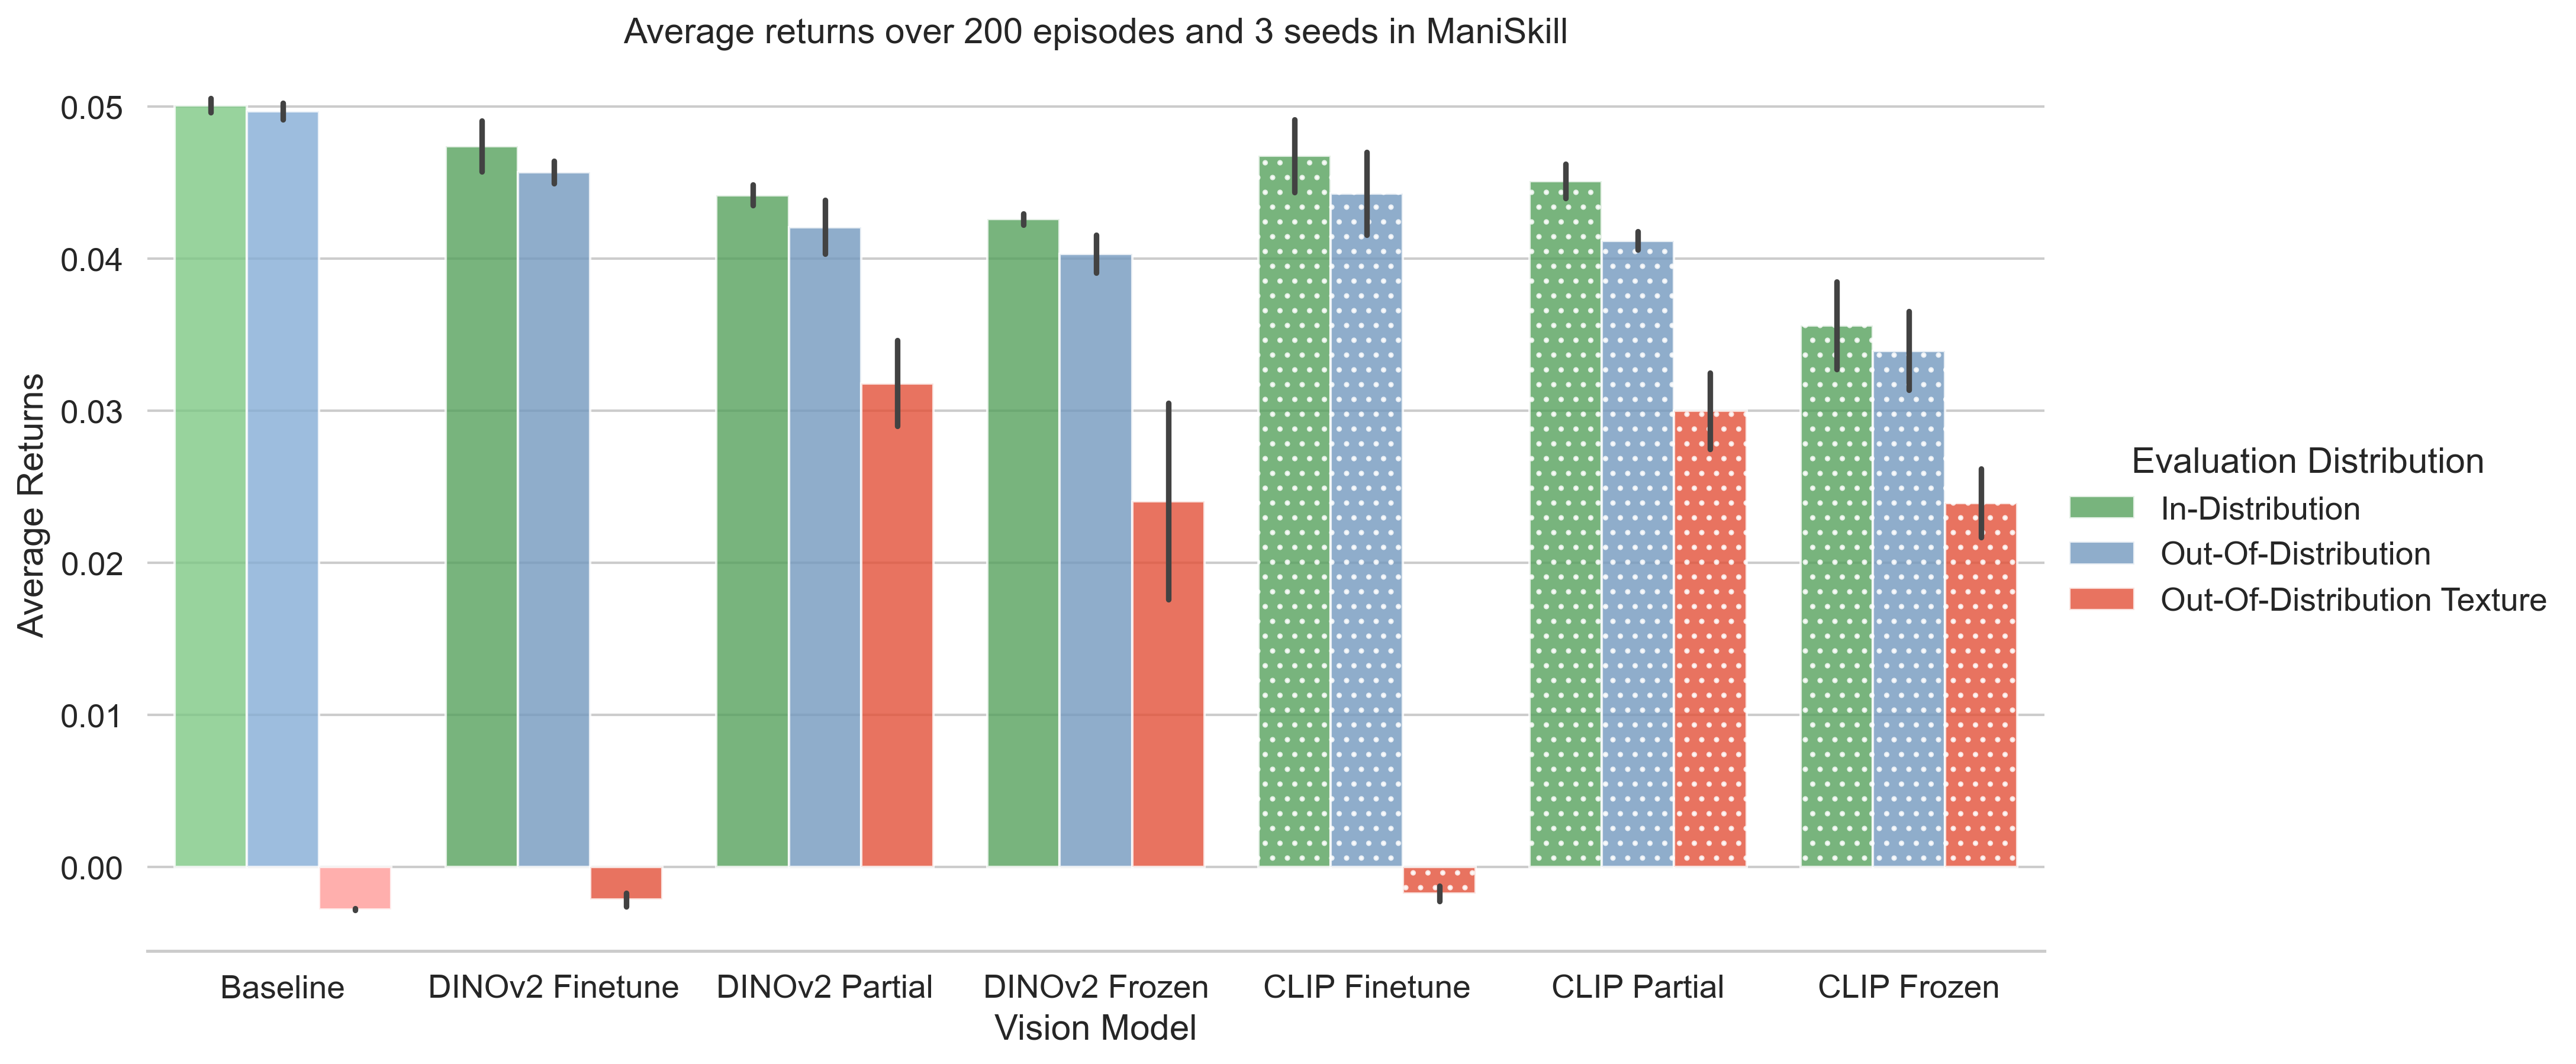

In [4]:
plot_maniskill(
    files_labels=[
        # ------- Baseline -------
        ("logdir/PICK_YCB/BASELINE/baseline_pick_ycb_eval_ID/", "Baseline In-Distribution"),
        ("logdir/PICK_YCB/BASELINE/baseline_pick_ycb_eval_ID_1/", "Baseline In-Distribution"),
        ("logdir/PICK_YCB/BASELINE/baseline_pick_ycb_eval_ID_2/", "Baseline In-Distribution"),
        
        ("logdir/PICK_YCB/BASELINE/baseline_pick_ycb_eval_OOD/", "Baseline Out-Of-Distribution"),
        ("logdir/PICK_YCB/BASELINE/baseline_pick_ycb_eval_OOD_1/", "Baseline Out-Of-Distribution"),
        ("logdir/PICK_YCB/BASELINE/baseline_pick_ycb_eval_OOD_2/", "Baseline Out-Of-Distribution"),

        ("logdir/PICK_YCB/BASELINE/baseline_pick_ycb_eval_dark_wood/", "Baseline Out-Of-Distribution_Texture"),
        ("logdir/PICK_YCB/BASELINE/baseline_pick_ycb_eval_dark_wood_1/", "Baseline Out-Of-Distribution_Texture"),
        ("logdir/PICK_YCB/BASELINE/baseline_pick_ycb_eval_dark_wood_2/", "Baseline Out-Of-Distribution_Texture"),

        # ------- DINOv2 FT -------
        ("logdir/PICK_YCB/DINO/DINOFT_pick_ycb_eval_ID/", "DINOv2 Finetune In-Distribution"),
        ("logdir/PICK_YCB/DINO/DINOFT_pick_ycb_eval_ID_1/", "DINOv2 Finetune In-Distribution"),
        ("logdir/PICK_YCB/DINO/DINOFT_pick_ycb_eval_ID_2/", "DINOv2 Finetune In-Distribution"),

        ("logdir/PICK_YCB/DINO/DINOFT_pick_ycb_eval_OOD/", "DINOv2 Finetune Out-Of-Distribution"),
        ("logdir/PICK_YCB/DINO/DINOFT_pick_ycb_eval_OOD_1/", "DINOv2 Finetune Out-Of-Distribution"),
        ("logdir/PICK_YCB/DINO/DINOFT_pick_ycb_eval_OOD_2/", "DINOv2 Finetune Out-Of-Distribution"),

        ("logdir/PICK_YCB/DINO/DINOFT_pick_ycb_eval_dark_wood/", "DINOv2 Finetune Out-Of-Distribution_Texture"),
        ("logdir/PICK_YCB/DINO/DINOFT_pick_ycb_eval_dark_wood_1/", "DINOv2 Finetune Out-Of-Distribution_Texture"),
        ("logdir/PICK_YCB/DINO/DINOFT_pick_ycb_eval_dark_wood_2/", "DINOv2 Finetune Out-Of-Distribution_Texture"),

        # ------- DINOv2 Partial -------
        ("logdir/PICK_YCB/DINO/DINOPartial_pick_ycb_eval_ID/", "DINOv2 Partial In-Distribution"),
        ("logdir/PICK_YCB/DINO/DINOPartial_pick_ycb_eval_ID_1/", "DINOv2 Partial In-Distribution"),
        ("logdir/PICK_YCB/DINO/DINOPartial_pick_ycb_eval_ID_2/", "DINOv2 Partial In-Distribution"),

        ("logdir/PICK_YCB/DINO/DINOPartial_pick_ycb_eval_OOD/", "DINOv2 Partial Out-Of-Distribution"),
        ("logdir/PICK_YCB/DINO/DINOPartial_pick_ycb_eval_OOD_1/", "DINOv2 Partial Out-Of-Distribution"),
        ("logdir/PICK_YCB/DINO/DINOPartial_pick_ycb_eval_OOD_2/", "DINOv2 Partial Out-Of-Distribution"),

        ("logdir/PICK_YCB/DINO/DINOPartial_pick_ycb_eval_dark_wood/", "DINOv2 Partial Out-Of-Distribution_Texture"),
        ("logdir/PICK_YCB/DINO/DINOPartial_pick_ycb_eval_dark_wood_1/", "DINOv2 Partial Out-Of-Distribution_Texture"),
        ("logdir/PICK_YCB/DINO/DINOPartial_pick_ycb_eval_dark_wood_2/", "DINOv2 Partial Out-Of-Distribution_Texture"),

        # ------- DINOv2 Frozen -------
        ("logdir/PICK_YCB/DINO/DINOFreeze_pick_ycb_eval_ID/", "DINOv2 Frozen In-Distribution"),
        ("logdir/PICK_YCB/DINO/DINOFreeze_pick_ycb_eval_ID_1/", "DINOv2 Frozen In-Distribution"),
        ("logdir/PICK_YCB/DINO/DINOFreeze_pick_ycb_eval_ID_2/", "DINOv2 Frozen In-Distribution"),

        ("logdir/PICK_YCB/DINO/DINOFreeze_pick_ycb_eval_OOD/", "DINOv2 Frozen Out-Of-Distribution"),
        ("logdir/PICK_YCB/DINO/DINOFreeze_pick_ycb_eval_OOD_1/", "DINOv2 Frozen Out-Of-Distribution"),
        ("logdir/PICK_YCB/DINO/DINOFreeze_pick_ycb_eval_OOD_2/", "DINOv2 Frozen Out-Of-Distribution"),

        ("logdir/PICK_YCB/DINO/DINOFreeze_pick_ycb_eval_dark_wood/", "DINOv2 Frozen Out-Of-Distribution_Texture"),
        ("logdir/PICK_YCB/DINO/DINOFreeze_pick_ycb_eval_dark_wood_1/", "DINOv2 Frozen Out-Of-Distribution_Texture"),
        ("logdir/PICK_YCB/DINO/DINOFreeze_pick_ycb_eval_dark_wood_2/", "DINOv2 Frozen Out-Of-Distribution_Texture"),

        # ------- CLIP FT -------
        ("logdir/PICK_YCB/CLIP/CLIPFT_pick_ycb_eval_ID/", "CLIP Finetune In-Distribution"),
        ("logdir/PICK_YCB/CLIP/CLIPFT_pick_ycb_eval_ID_1/", "CLIP Finetune In-Distribution"),
        ("logdir/PICK_YCB/CLIP/CLIPFT_pick_ycb_eval_ID_2/", "CLIP Finetune In-Distribution"),

        ("logdir/PICK_YCB/CLIP/CLIPFT_pick_ycb_eval_OOD/", "CLIP Finetune Out-Of-Distribution"),
        ("logdir/PICK_YCB/CLIP/CLIPFT_pick_ycb_eval_OOD_1/", "CLIP Finetune Out-Of-Distribution"),
        ("logdir/PICK_YCB/CLIP/CLIPFT_pick_ycb_eval_OOD_2/", "CLIP Finetune Out-Of-Distribution"),

        ("logdir/PICK_YCB/CLIP/CLIPFT_pick_ycb_eval_dark_wood/", "CLIP Finetune Out-Of-Distribution_Texture"),
        ("logdir/PICK_YCB/CLIP/CLIPFT_pick_ycb_eval_dark_wood_1/", "CLIP Finetune Out-Of-Distribution_Texture"),
        ("logdir/PICK_YCB/CLIP/CLIPFT_pick_ycb_eval_dark_wood_2/", "CLIP Finetune Out-Of-Distribution_Texture"),

        # ------- CLIP Partial -------
        ("logdir/PICK_YCB/CLIP/CLIPPartial_pick_ycb_eval_ID/", "CLIP Partial In-Distribution"),
        ("logdir/PICK_YCB/CLIP/CLIPPartial_pick_ycb_eval_ID_1/", "CLIP Partial In-Distribution"),
        ("logdir/PICK_YCB/CLIP/CLIPPartial_pick_ycb_eval_ID_2/", "CLIP Partial In-Distribution"),

        ("logdir/PICK_YCB/CLIP/CLIPPartial_pick_ycb_eval_OOD/", "CLIP Partial Out-Of-Distribution"),
        ("logdir/PICK_YCB/CLIP/CLIPPartial_pick_ycb_eval_OOD_1/", "CLIP Partial Out-Of-Distribution"),
        ("logdir/PICK_YCB/CLIP/CLIPPartial_pick_ycb_eval_OOD_2/", "CLIP Partial Out-Of-Distribution"),

        ("logdir/PICK_YCB/CLIP/CLIPPartial_pick_ycb_eval_dark_wood/", "CLIP Partial Out-Of-Distribution_Texture"),
        ("logdir/PICK_YCB/CLIP/CLIPPartial_pick_ycb_eval_dark_wood_1/", "CLIP Partial Out-Of-Distribution_Texture"),
        ("logdir/PICK_YCB/CLIP/CLIPPartial_pick_ycb_eval_dark_wood_2/", "CLIP Partial Out-Of-Distribution_Texture"),

        # ------- CLIP Frozen -------
        ("logdir/PICK_YCB/CLIP/CLIPFreeze_pick_ycb_eval_ID/", "CLIP Frozen In-Distribution"),
        ("logdir/PICK_YCB/CLIP/CLIPFreeze_pick_ycb_eval_ID_1/", "CLIP Frozen In-Distribution"),
        ("logdir/PICK_YCB/CLIP/CLIPFreeze_pick_ycb_eval_ID_2/", "CLIP Frozen In-Distribution"),

        ("logdir/PICK_YCB/CLIP/CLIPFreeze_pick_ycb_eval_OOD/", "CLIP Frozen Out-Of-Distribution"),
        ("logdir/PICK_YCB/CLIP/CLIPFreeze_pick_ycb_eval_OOD_1/", "CLIP Frozen Out-Of-Distribution"),
        ("logdir/PICK_YCB/CLIP/CLIPFreeze_pick_ycb_eval_OOD_2/", "CLIP Frozen Out-Of-Distribution"),

        ("logdir/PICK_YCB/CLIP/CLIPFreeze_pick_ycb_eval_dark_wood/", "CLIP Frozen Out-Of-Distribution_Texture"),
        ("logdir/PICK_YCB/CLIP/CLIPFreeze_pick_ycb_eval_dark_wood_1/", "CLIP Frozen Out-Of-Distribution_Texture"),
        ("logdir/PICK_YCB/CLIP/CLIPFreeze_pick_ycb_eval_dark_wood_2/", "CLIP Frozen Out-Of-Distribution_Texture"),
    ]
)

In [ ]:
# Calculate percentage differences for both OOD and OOD Texture relative to in-distribution for each model in ManiSkill
pivot = df.pivot_table(index='model', columns='Evaluation Distribution', values='reward', aggfunc='mean')

for model in pivot.index:
    id_val = pivot.loc[model, 'In-Distribution']
    ood_val = pivot.loc[model, 'Out-Of-Distribution']
    ood_texture_val = pivot.loc[model, 'Out-Of-Distribution Texture']
    ood_diff = ((ood_val - id_val) / abs(id_val)) * 100
    ood_texture_diff = ((ood_texture_val - id_val) / abs(id_val)) * 100
    print(f"{model}: OOD {ood_diff:.2f}%, OOD Texture {ood_texture_diff:.2f}% (relative to In-Distribution)")

Random reward: -37.40520750709501
[{'reward': 0.147193678819967, 'model': 'Baseline', 'Evaluation Distribution': 'In-Distribution'}, {'reward': 0.15915449483946378, 'model': 'Baseline', 'Evaluation Distribution': 'In-Distribution'}, {'reward': 0.11971628857507659, 'model': 'Baseline', 'Evaluation Distribution': 'In-Distribution'}, {'reward': 0.03529185536659617, 'model': 'Baseline', 'Evaluation Distribution': 'Out-Of-Distribution Weak'}, {'reward': 0.02808395517698343, 'model': 'Baseline', 'Evaluation Distribution': 'Out-Of-Distribution Weak'}, {'reward': 0.038302776879896264, 'model': 'Baseline', 'Evaluation Distribution': 'Out-Of-Distribution Weak'}, {'reward': 0.026883648161081655, 'model': 'Baseline', 'Evaluation Distribution': 'Out-Of-Distribution Weak'}, {'reward': 0.020826490516009308, 'model': 'Baseline', 'Evaluation Distribution': 'Out-Of-Distribution Weak'}, {'reward': 0.03827488967631226, 'model': 'Baseline', 'Evaluation Distribution': 'Out-Of-Distribution Weak'}, {'reward':

<Figure size 3600x1800 with 0 Axes>

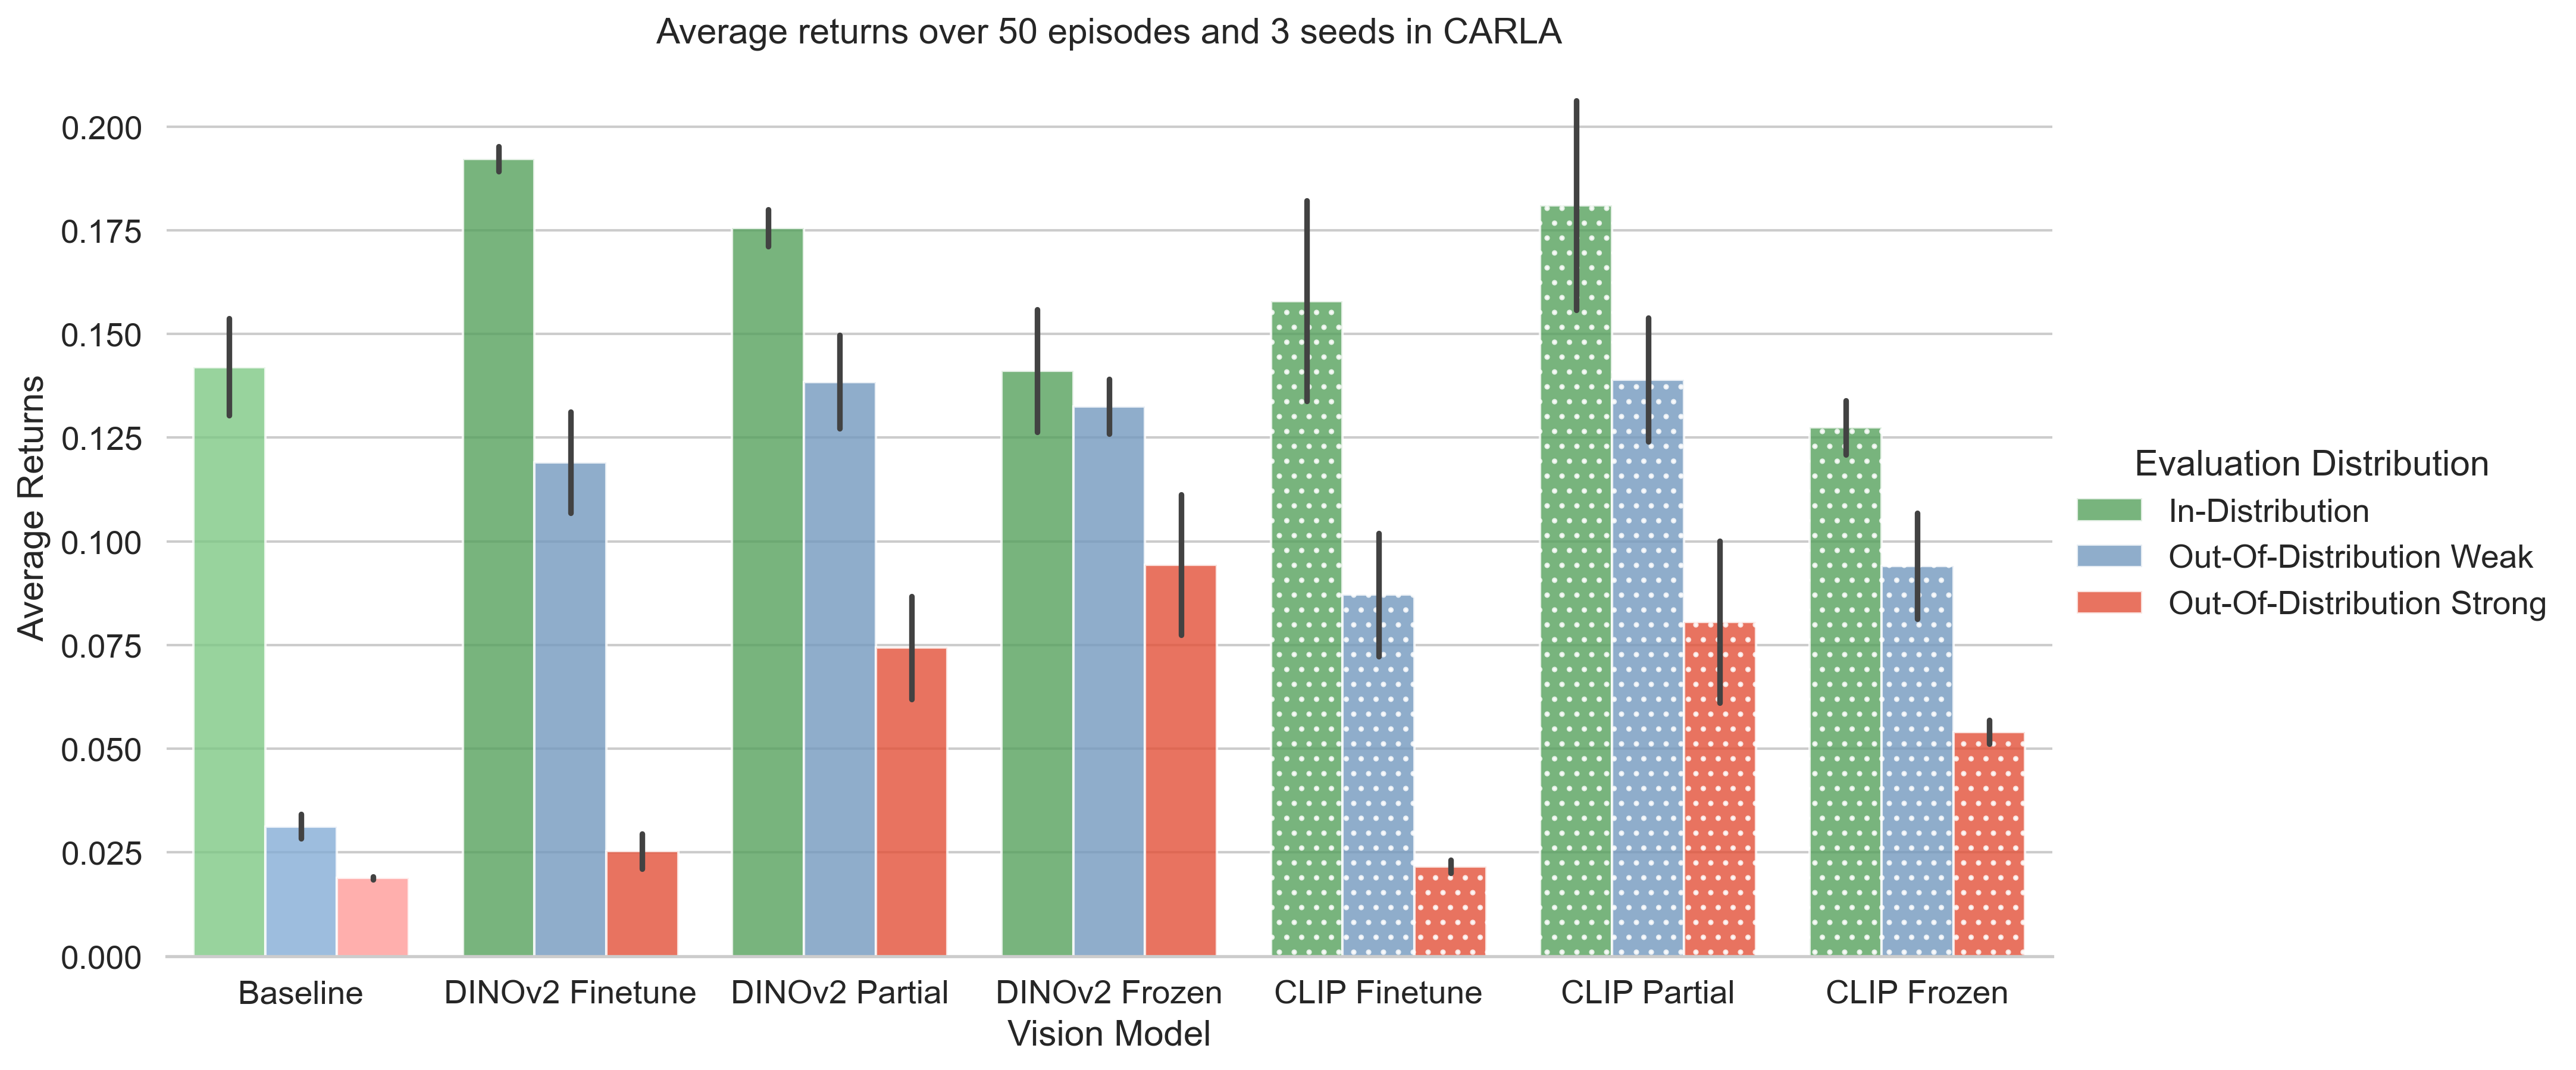

In [34]:
plot_carla(
    files_labels=[
        # ------- Baseline -------
        ("logdir/CARLA/BASELINE/baseline_carla_eval_ID", "Baseline In-Distribution"),
        ("logdir/CARLA/BASELINE/baseline_carla_eval_ID_1", "Baseline In-Distribution"),
        ("logdir/CARLA/BASELINE/baseline_carla_eval_ID_2", "Baseline In-Distribution"),

        ("logdir/CARLA/BASELINE/baseline_carla_eval_soft_high_light", "Baseline Out-Of-Distribution_Weak"),
        ("logdir/CARLA/BASELINE/baseline_carla_eval_soft_high_light_1", "Baseline Out-Of-Distribution_Weak"),
        ("logdir/CARLA/BASELINE/baseline_carla_eval_soft_high_light_2", "Baseline Out-Of-Distribution_Weak"),
        ("logdir/CARLA/BASELINE/baseline_carla_eval_soft_noisy_low_light", "Baseline Out-Of-Distribution_Weak"),
        ("logdir/CARLA/BASELINE/baseline_carla_eval_soft_noisy_low_light_1", "Baseline Out-Of-Distribution_Weak"),
        ("logdir/CARLA/BASELINE/baseline_carla_eval_soft_noisy_low_light_2", "Baseline Out-Of-Distribution_Weak"),

        ("logdir/CARLA/BASELINE/baseline_carla_eval_hard_low_light", "Baseline Out-Of-Distribution_Strong"),
        ("logdir/CARLA/BASELINE/baseline_carla_eval_hard_low_light_1", "Baseline Out-Of-Distribution_Strong"),
        ("logdir/CARLA/BASELINE/baseline_carla_eval_hard_low_light_2", "Baseline Out-Of-Distribution_Strong"),
        ("logdir/CARLA/BASELINE/baseline_carla_eval_hard_noisy_low_light", "Baseline Out-Of-Distribution_Strong"),
        ("logdir/CARLA/BASELINE/baseline_carla_eval_hard_noisy_low_light_1", "Baseline Out-Of-Distribution_Strong"),
        ("logdir/CARLA/BASELINE/baseline_carla_eval_hard_noisy_low_light_2", "Baseline Out-Of-Distribution_Strong"),

        # ------- DINO FT -------
        ("logdir/CARLA/DINO/DINOFT_carla_eval_ID", "DINOv2 Finetune In-Distribution"),
        ("logdir/CARLA/DINO/DINOFT_carla_eval_ID_1", "DINOv2 Finetune In-Distribution"),
        ("logdir/CARLA/DINO/DINOFT_carla_eval_ID_2", "DINOv2 Finetune In-Distribution"),

        ("logdir/CARLA/DINO/DINOFT_carla_eval_soft_high_light", "DINOv2 Finetune Out-Of-Distribution_Weak"),
        ("logdir/CARLA/DINO/DINOFT_carla_eval_soft_high_light_1", "DINOv2 Finetune Out-Of-Distribution_Weak"),
        ("logdir/CARLA/DINO/DINOFT_carla_eval_soft_high_light_2", "DINOv2 Finetune Out-Of-Distribution_Weak"),
        ("logdir/CARLA/DINO/DINOFT_carla_eval_soft_noisy_low_light", "DINOv2 Finetune Out-Of-Distribution_Weak"),
        ("logdir/CARLA/DINO/DINOFT_carla_eval_soft_noisy_low_light_1", "DINOv2 Finetune Out-Of-Distribution_Weak"),
        ("logdir/CARLA/DINO/DINOFT_carla_eval_soft_noisy_low_light_2", "DINOv2 Finetune Out-Of-Distribution_Weak"),

        ("logdir/CARLA/DINO/DINOFT_carla_eval_hard_low_light", "DINOv2 Finetune Out-Of-Distribution_Strong"),
        ("logdir/CARLA/DINO/DINOFT_carla_eval_hard_low_light_1", "DINOv2 Finetune Out-Of-Distribution_Strong"),
        ("logdir/CARLA/DINO/DINOFT_carla_eval_hard_low_light_2", "DINOv2 Finetune Out-Of-Distribution_Strong"),
        ("logdir/CARLA/DINO/DINOFT_carla_eval_hard_noisy_low_light", "DINOv2 Finetune Out-Of-Distribution_Strong"),
        ("logdir/CARLA/DINO/DINOFT_carla_eval_hard_noisy_low_light_1", "DINOv2 Finetune Out-Of-Distribution_Strong"),
        ("logdir/CARLA/DINO/DINOFT_carla_eval_hard_noisy_low_light_2", "DINOv2 Finetune Out-Of-Distribution_Strong"),
        
        # ------- DINOv2 Partial -------
        ("logdir/CARLA/DINO/DINOPartial_carla_eval_ID", "DINOv2 Partial In-Distribution"),
        ("logdir/CARLA/DINO/DINOPartial_carla_eval_ID_1", "DINOv2 Partial In-Distribution"),
        ("logdir/CARLA/DINO/DINOPartial_carla_eval_ID_2", "DINOv2 Partial In-Distribution"),

        ("logdir/CARLA/DINO/DINOPartial_carla_eval_soft_high_light", "DINOv2 Partial Out-Of-Distribution_Weak"),
        ("logdir/CARLA/DINO/DINOPartial_carla_eval_soft_high_light_1", "DINOv2 Partial Out-Of-Distribution_Weak"),
        ("logdir/CARLA/DINO/DINOPartial_carla_eval_soft_high_light_2", "DINOv2 Partial Out-Of-Distribution_Weak"),
        ("logdir/CARLA/DINO/DINOPartial_carla_eval_soft_noisy_low_light", "DINOv2 Partial Out-Of-Distribution_Weak"),
        ("logdir/CARLA/DINO/DINOPartial_carla_eval_soft_noisy_low_light_1", "DINOv2 Partial Out-Of-Distribution_Weak"),
        ("logdir/CARLA/DINO/DINOPartial_carla_eval_soft_noisy_low_light_2", "DINOv2 Partial Out-Of-Distribution_Weak"),

        ("logdir/CARLA/DINO/DINOPartial_carla_eval_hard_low_light", "DINOv2 Partial Out-Of-Distribution_Strong"),
        ("logdir/CARLA/DINO/DINOPartial_carla_eval_hard_low_light_1", "DINOv2 Partial Out-Of-Distribution_Strong"),
        ("logdir/CARLA/DINO/DINOPartial_carla_eval_hard_low_light_2", "DINOv2 Partial Out-Of-Distribution_Strong"),
        ("logdir/CARLA/DINO/DINOPartial_carla_eval_hard_noisy_low_light", "DINOv2 Partial Out-Of-Distribution_Strong"),
        ("logdir/CARLA/DINO/DINOPartial_carla_eval_hard_noisy_low_light_1", "DINOv2 Partial Out-Of-Distribution_Strong"),
        ("logdir/CARLA/DINO/DINOPartial_carla_eval_hard_noisy_low_light_2", "DINOv2 Partial Out-Of-Distribution_Strong"),

        # ------- DINOv2 Frozen -------
        ("logdir/CARLA/DINO/DINOFreeze_carla_eval_ID", "DINOv2 Frozen In-Distribution"),
        ("logdir/CARLA/DINO/DINOFreeze_carla_eval_ID_1", "DINOv2 Frozen In-Distribution"),
        ("logdir/CARLA/DINO/DINOFreeze_carla_eval_ID_2", "DINOv2 Frozen In-Distribution"),

        ("logdir/CARLA/DINO/DINOFreeze_carla_eval_soft_noisy_low_light", "DINOv2 Frozen Out-Of-Distribution_Weak"),
        ("logdir/CARLA/DINO/DINOFreeze_carla_eval_soft_noisy_low_light_1", "DINOv2 Frozen Out-Of-Distribution_Weak"),
        ("logdir/CARLA/DINO/DINOFreeze_carla_eval_soft_noisy_low_light_2", "DINOv2 Frozen Out-Of-Distribution_Weak"),
        ("logdir/CARLA/DINO/DINOFreeze_carla_eval_soft_high_light", "DINOv2 Frozen Out-Of-Distribution_Weak"),
        ("logdir/CARLA/DINO/DINOFreeze_carla_eval_soft_high_light_1", "DINOv2 Frozen Out-Of-Distribution_Weak"),
        ("logdir/CARLA/DINO/DINOFreeze_carla_eval_soft_high_light_2", "DINOv2 Frozen Out-Of-Distribution_Weak"),

        ("logdir/CARLA/DINO/DINOFreeze_carla_eval_hard_noisy_low_light", "DINOv2 Frozen Out-Of-Distribution_Strong"),
        ("logdir/CARLA/DINO/DINOFreeze_carla_eval_hard_noisy_low_light_1", "DINOv2 Frozen Out-Of-Distribution_Strong"),
        ("logdir/CARLA/DINO/DINOFreeze_carla_eval_hard_noisy_low_light_2", "DINOv2 Frozen Out-Of-Distribution_Strong"),
        ("logdir/CARLA/DINO/DINOFreeze_carla_eval_hard_low_light", "DINOv2 Frozen Out-Of-Distribution_Strong"),
        ("logdir/CARLA/DINO/DINOFreeze_carla_eval_hard_low_light_1", "DINOv2 Frozen Out-Of-Distribution_Strong"),
        ("logdir/CARLA/DINO/DINOFreeze_carla_eval_hard_low_light_2", "DINOv2 Frozen Out-Of-Distribution_Strong"),

        # ------- CLIP FT -------
        ("logdir/CARLA/CLIP/CLIPFT_carla_eval_ID", "CLIP Finetune In-Distribution"),
        ("logdir/CARLA/CLIP/CLIPFT_carla_eval_ID_1", "CLIP Finetune In-Distribution"),
        ("logdir/CARLA/CLIP/CLIPFT_carla_eval_ID_2", "CLIP Finetune In-Distribution"),

        ("logdir/CARLA/CLIP/CLIPFT_carla_eval_soft_noisy_low_light", "CLIP Finetune Out-Of-Distribution_Weak"),
        ("logdir/CARLA/CLIP/CLIPFT_carla_eval_soft_noisy_low_light_1", "CLIP Finetune Out-Of-Distribution_Weak"),
        ("logdir/CARLA/CLIP/CLIPFT_carla_eval_soft_noisy_low_light_2", "CLIP Finetune Out-Of-Distribution_Weak"),
        ("logdir/CARLA/CLIP/CLIPFT_carla_eval_soft_high_light", "CLIP Finetune Out-Of-Distribution_Weak"),
        ("logdir/CARLA/CLIP/CLIPFT_carla_eval_soft_high_light_1", "CLIP Finetune Out-Of-Distribution_Weak"),
        ("logdir/CARLA/CLIP/CLIPFT_carla_eval_soft_high_light_2", "CLIP Finetune Out-Of-Distribution_Weak"),

        ("logdir/CARLA/CLIP/CLIPFT_carla_eval_hard_noisy_low_light", "CLIP Finetune Out-Of-Distribution_Strong"),
        ("logdir/CARLA/CLIP/CLIPFT_carla_eval_hard_noisy_low_light_1", "CLIP Finetune Out-Of-Distribution_Strong"),
        ("logdir/CARLA/CLIP/CLIPFT_carla_eval_hard_noisy_low_light_2", "CLIP Finetune Out-Of-Distribution_Strong"),
        ("logdir/CARLA/CLIP/CLIPFT_carla_eval_hard_low_light", "CLIP Finetune Out-Of-Distribution_Strong"),
        ("logdir/CARLA/CLIP/CLIPFT_carla_eval_hard_low_light_1", "CLIP Finetune Out-Of-Distribution_Strong"),
        ("logdir/CARLA/CLIP/CLIPFT_carla_eval_hard_low_light_2", "CLIP Finetune Out-Of-Distribution_Strong"),

        # ------- CLIP Partial -------
        ("logdir/CARLA/CLIP/CLIPPartial_carla_eval_ID", "CLIP Partial In-Distribution"),
        ("logdir/CARLA/CLIP/CLIPPartial_carla_eval_ID_1", "CLIP Partial In-Distribution"),
        ("logdir/CARLA/CLIP/CLIPPartial_carla_eval_ID_2", "CLIP Partial In-Distribution"),

        ("logdir/CARLA/CLIP/CLIPPartial_carla_eval_soft_noisy_low_light", "CLIP Partial Out-Of-Distribution_Weak"),
        ("logdir/CARLA/CLIP/CLIPPartial_carla_eval_soft_noisy_low_light_1", "CLIP Partial Out-Of-Distribution_Weak"),
        ("logdir/CARLA/CLIP/CLIPPartial_carla_eval_soft_noisy_low_light_2", "CLIP Partial Out-Of-Distribution_Weak"),
        ("logdir/CARLA/CLIP/CLIPPartial_carla_eval_soft_high_light", "CLIP Partial Out-Of-Distribution_Weak"),
        ("logdir/CARLA/CLIP/CLIPPartial_carla_eval_soft_high_light_1", "CLIP Partial Out-Of-Distribution_Weak"),
        ("logdir/CARLA/CLIP/CLIPPartial_carla_eval_soft_high_light_2", "CLIP Partial Out-Of-Distribution_Weak"),

        ("logdir/CARLA/CLIP/CLIPPartial_carla_eval_hard_noisy_low_light", "CLIP Partial Out-Of-Distribution_Strong"),
        ("logdir/CARLA/CLIP/CLIPPartial_carla_eval_hard_noisy_low_light_1", "CLIP Partial Out-Of-Distribution_Strong"),
        ("logdir/CARLA/CLIP/CLIPPartial_carla_eval_hard_noisy_low_light_2", "CLIP Partial Out-Of-Distribution_Strong"),
        ("logdir/CARLA/CLIP/CLIPPartial_carla_eval_hard_low_light", "CLIP Partial Out-Of-Distribution_Strong"),
        ("logdir/CARLA/CLIP/CLIPPartial_carla_eval_hard_low_light_1", "CLIP Partial Out-Of-Distribution_Strong"),
        ("logdir/CARLA/CLIP/CLIPPartial_carla_eval_hard_low_light_2", "CLIP Partial Out-Of-Distribution_Strong"),

        # ------- CLIP Frozen -------
        ("logdir/CARLA/CLIP/CLIPFreeze_carla_eval_ID", "CLIP Frozen In-Distribution"),
        ("logdir/CARLA/CLIP/CLIPFreeze_carla_eval_ID_1", "CLIP Frozen In-Distribution"),
        ("logdir/CARLA/CLIP/CLIPFreeze_carla_eval_ID_2", "CLIP Frozen In-Distribution"),

        ("logdir/CARLA/CLIP/CLIPFreeze_carla_eval_soft_noisy_low_light", "CLIP Frozen Out-Of-Distribution_Weak"),
        ("logdir/CARLA/CLIP/CLIPFreeze_carla_eval_soft_noisy_low_light_1", "CLIP Frozen Out-Of-Distribution_Weak"),
        ("logdir/CARLA/CLIP/CLIPFreeze_carla_eval_soft_noisy_low_light_2", "CLIP Frozen Out-Of-Distribution_Weak"),
        ("logdir/CARLA/CLIP/CLIPFreeze_carla_eval_soft_high_light", "CLIP Frozen Out-Of-Distribution_Weak"),
        ("logdir/CARLA/CLIP/CLIPFreeze_carla_eval_soft_high_light_1", "CLIP Frozen Out-Of-Distribution_Weak"),
        ("logdir/CARLA/CLIP/CLIPFreeze_carla_eval_soft_high_light_2", "CLIP Frozen Out-Of-Distribution_Weak"),

        ("logdir/CARLA/CLIP/CLIPFreeze_carla_eval_hard_noisy_low_light", "CLIP Frozen Out-Of-Distribution_Strong"),
        ("logdir/CARLA/CLIP/CLIPFreeze_carla_eval_hard_noisy_low_light_1", "CLIP Frozen Out-Of-Distribution_Strong"),
        ("logdir/CARLA/CLIP/CLIPFreeze_carla_eval_hard_noisy_low_light_2", "CLIP Frozen Out-Of-Distribution_Strong"),
        ("logdir/CARLA/CLIP/CLIPFreeze_carla_eval_hard_low_light", "CLIP Frozen Out-Of-Distribution_Strong"),
        ("logdir/CARLA/CLIP/CLIPFreeze_carla_eval_hard_low_light_1", "CLIP Frozen Out-Of-Distribution_Strong"),
        ("logdir/CARLA/CLIP/CLIPFreeze_carla_eval_hard_low_light_2", "CLIP Frozen Out-Of-Distribution_Strong"),
    ]
)

## Catastrophic Forgetting
In this experiment we train a K-Nearest Neighbours model on the output representation from the DinoV2 models before and after end-to-end finetuning with DreamerV3. In this small diagnostic test we trained using a 80:20 split from 20k ImageNet images.

/var/folders/sz/_6t9n1rn6b7bxg8p0wzyw0g00000gn/T/ipykernel_14653/3050328602.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=imagenet_df, x="Model Type", y="ImageNet Accuracy", palette=palette, errorbar="se", width=0.5, alpha=0.8)


<Axes: title={'center': 'ManiSkill ImageNet KNN Accuracy'}, xlabel='Model Type', ylabel='ImageNet Test Accuracy (%)'>

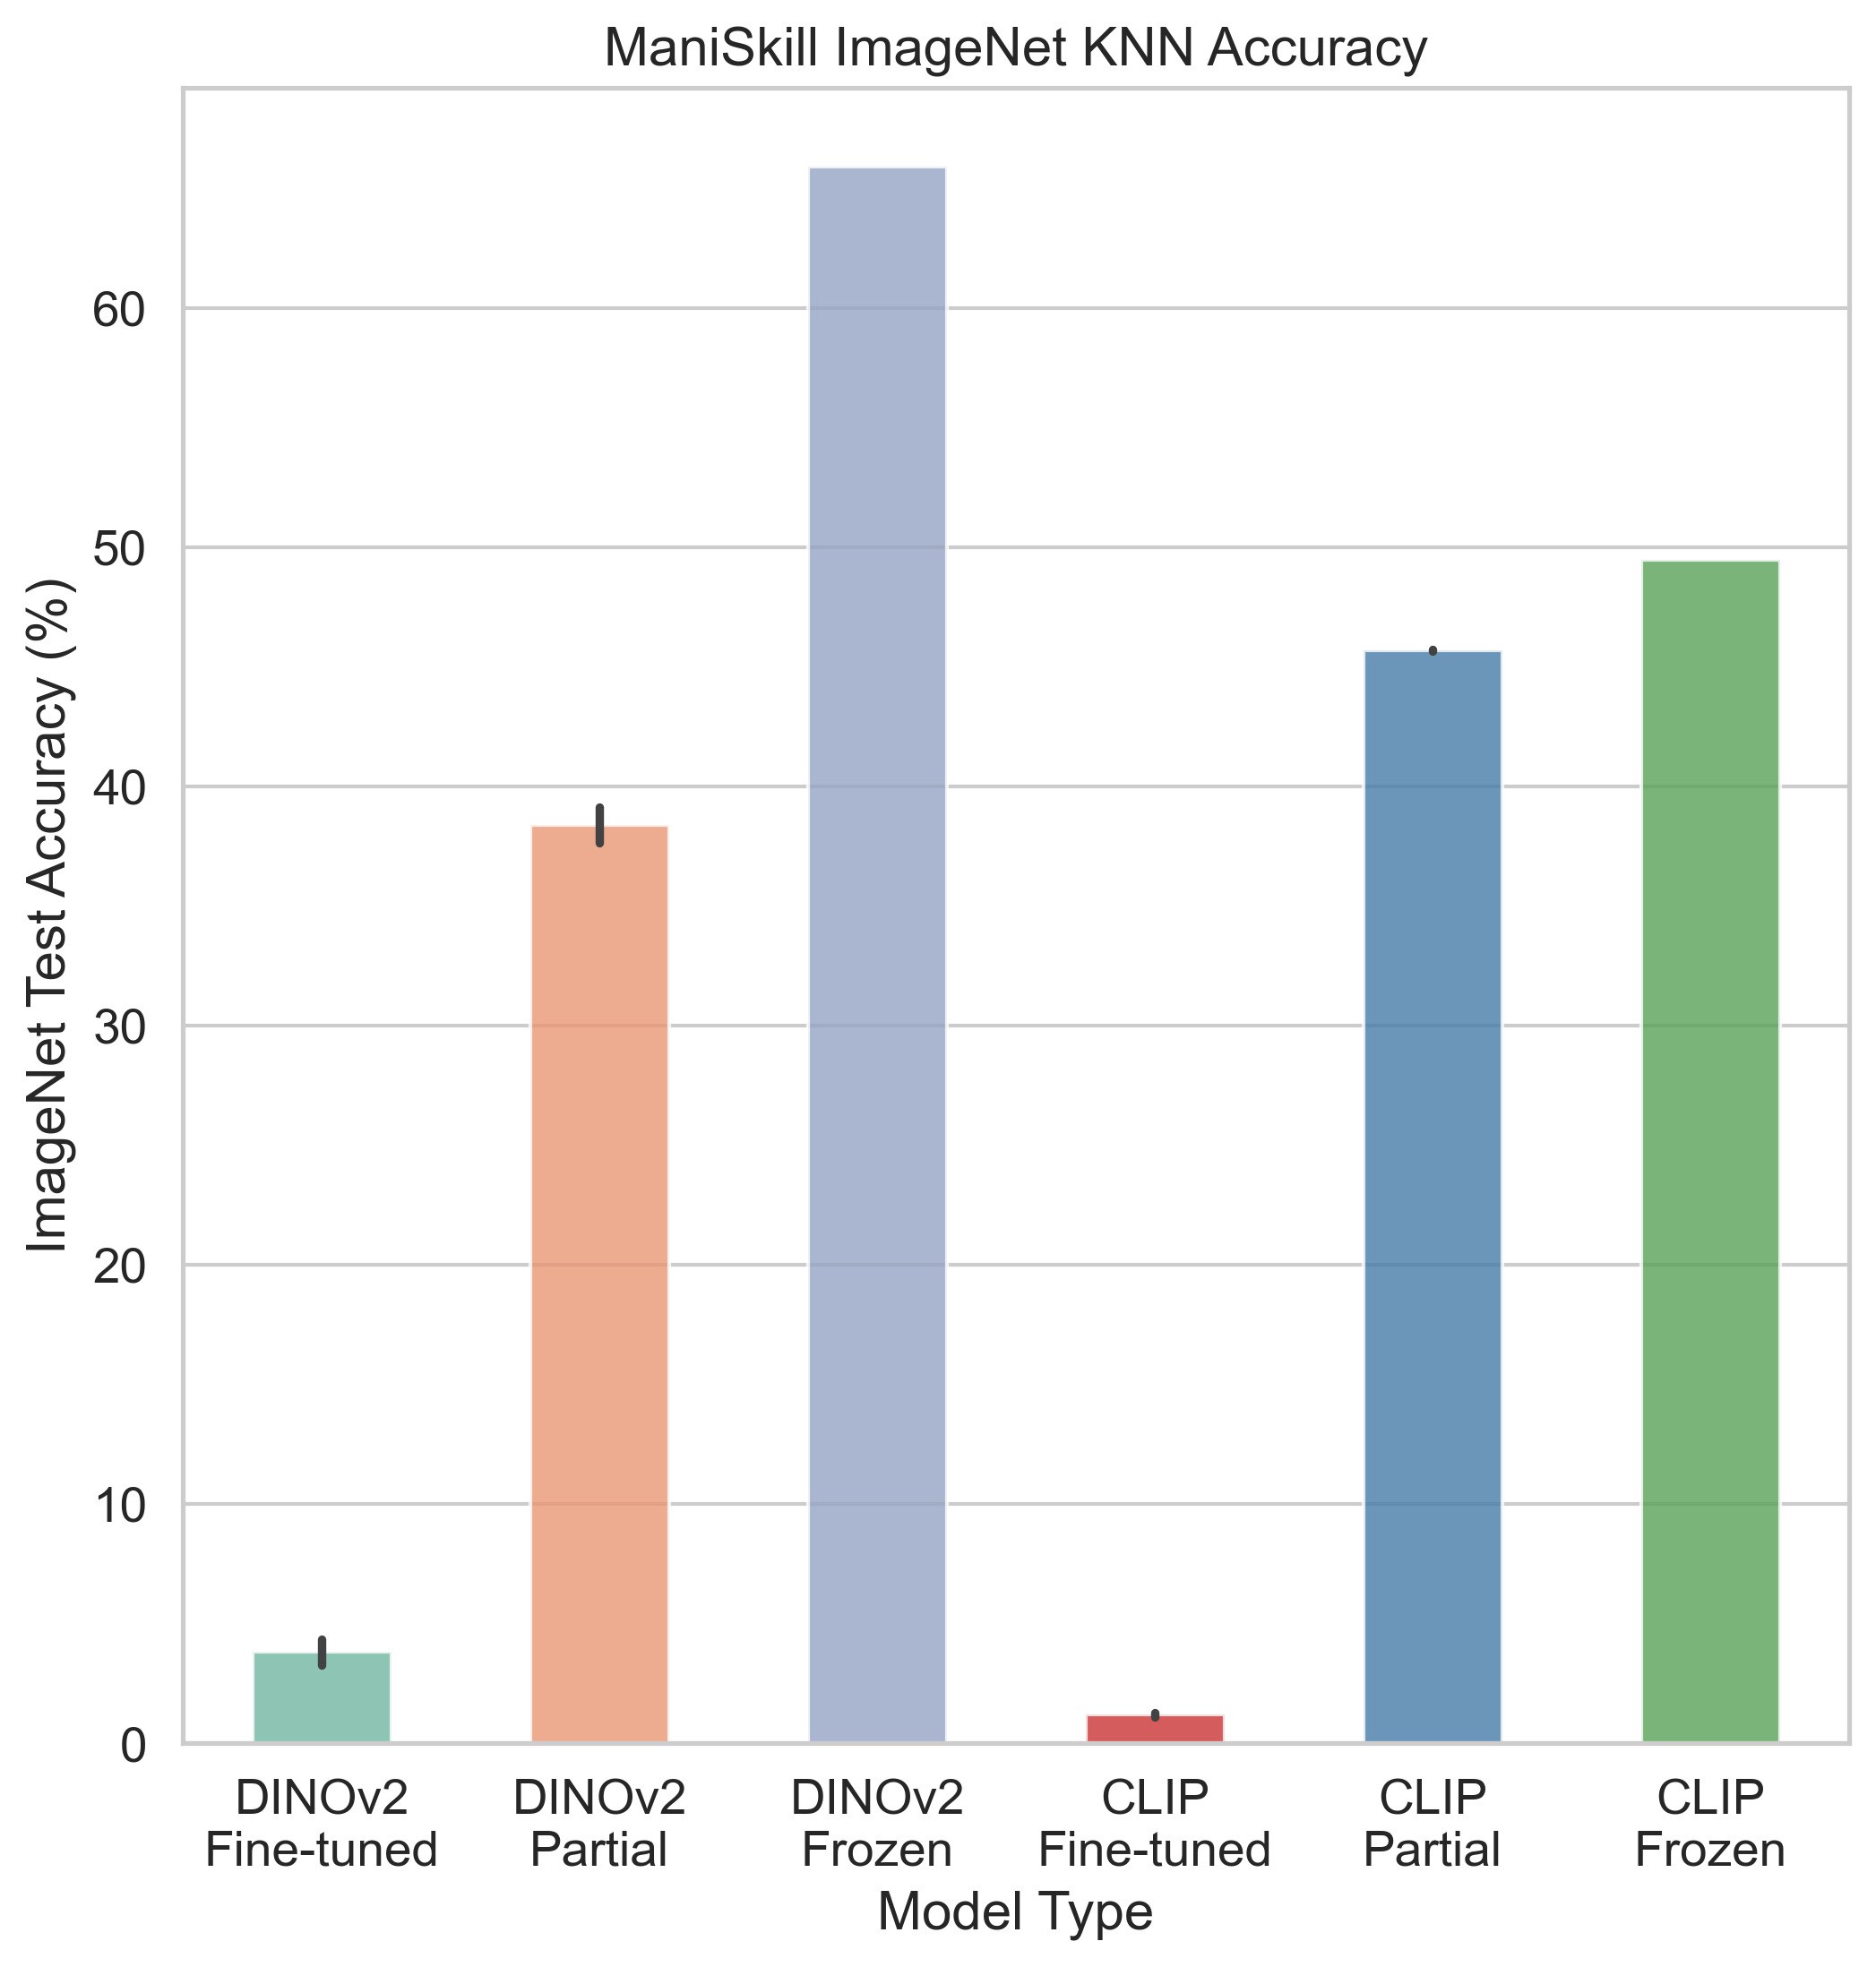

In [12]:
imagenet_knn_accuracy = [4.92, 39.77, 65.88, 1.27, 45.60, 49.45]
imagenet_knn_accuracy_1 = [3.17, 38.15, 65.88, 1.32, 45.70, 49.45]
imagenet_knn_accuracy_2 = [3.38, 37.23, 65.88, 1.00, 45.77, 49.45]

imagenet_labels = ["DINOv2\nFine-tuned", "DINOv2\nPartial", "DINOv2\nFrozen", "CLIP\nFine-tuned", "CLIP\nPartial","CLIP\nFrozen"]
imagenets = np.array([imagenet_knn_accuracy, imagenet_knn_accuracy_1, imagenet_knn_accuracy_2])
imagenet_mean = imagenets.mean(axis=0)
imagenet_df = pd.DataFrame(imagenets, columns=imagenet_labels)
imagenet_df = imagenet_df.melt(var_name="Model Type", value_name="ImageNet Accuracy")

plt.figure(figsize=(8, 8))
plt.xlabel("Model Type")
plt.ylabel("ImageNet Test Accuracy (%)")
plt.title(f"ManiSkill ImageNet KNN Accuracy")
palette = sns.color_palette("Set2", n_colors=3) + sns.color_palette("Set1", n_colors=3)
sns.barplot(data=imagenet_df, x="Model Type", y="ImageNet Accuracy", palette=palette, errorbar="se", width=0.5, alpha=0.8)

/var/folders/sz/_6t9n1rn6b7bxg8p0wzyw0g00000gn/T/ipykernel_14653/392902818.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=carla_imagenet_df, x="Model Type", y="ImageNet Accuracy", palette=palette, errorbar="se", width=0.5, alpha=0.8)


<Axes: title={'center': 'CARLA ImageNet KNN Accuracy'}, xlabel='Model Type', ylabel='ImageNet Test Accuracy (%)'>

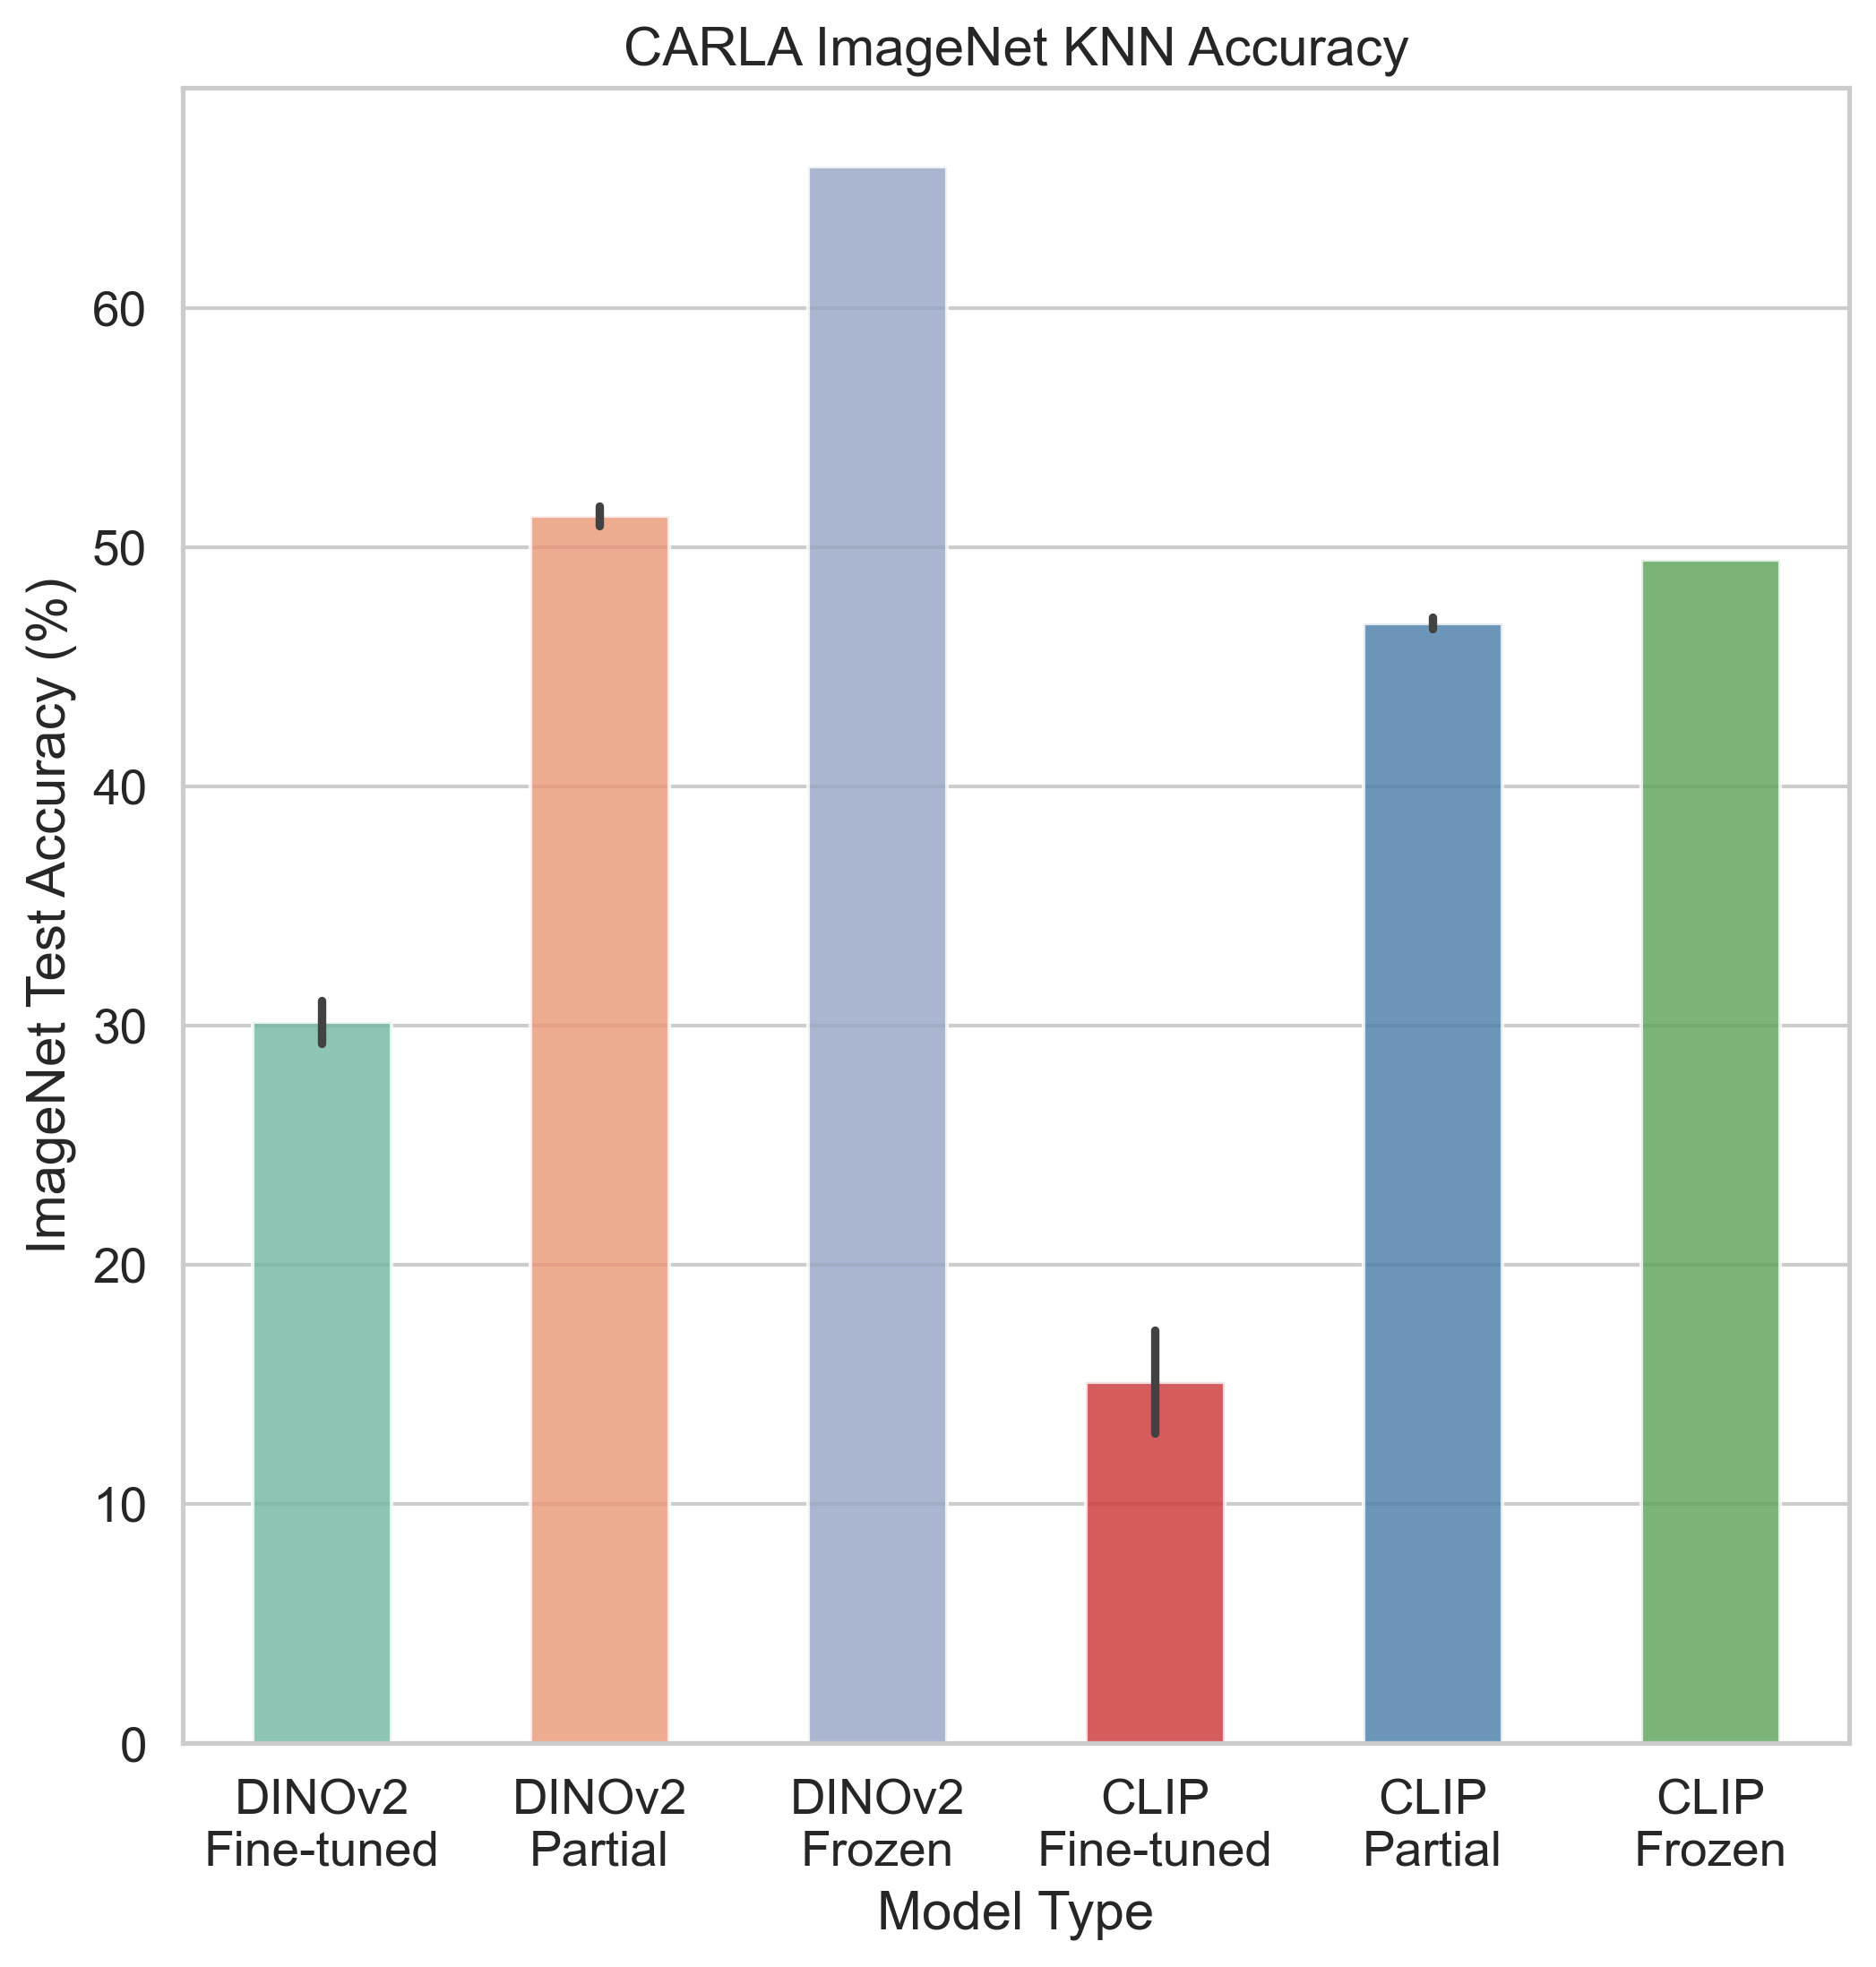

In [13]:
carla_imagenet_knn_accuracy = [30.00, 52.08, 65.88, 18.9, 46.35, 49.45]
carla_imagenet_knn_accuracy_1 = [31.80, 50.70, 65.88, 15.00, 46.98, 49.45]
carla_imagenet_knn_accuracy_2 = [28.70, 51.08, 65.88, 11.45, 47.12, 49.45]

carla_imagenet_labels = ["DINOv2\nFine-tuned", "DINOv2\nPartial", "DINOv2\nFrozen", "CLIP\nFine-tuned", "CLIP\nPartial","CLIP\nFrozen"]
carla_imagenets = np.array([carla_imagenet_knn_accuracy, carla_imagenet_knn_accuracy_1, carla_imagenet_knn_accuracy_2])
carla_imagenet_mean = carla_imagenets.mean(axis=0)
carla_imagenet_df = pd.DataFrame(carla_imagenets, columns=carla_imagenet_labels)
carla_imagenet_df = carla_imagenet_df.melt(var_name="Model Type", value_name="ImageNet Accuracy")

plt.figure(figsize=(8, 8))
plt.xlabel("Model Type")
plt.ylabel("ImageNet Test Accuracy (%)")
plt.title(f"CARLA ImageNet KNN Accuracy")
palette = sns.color_palette("Set2", n_colors=3) + sns.color_palette("Set1", n_colors=3)
sns.barplot(data=carla_imagenet_df, x="Model Type", y="ImageNet Accuracy", palette=palette, errorbar="se", width=0.5, alpha=0.8)

## Jaccard Index
With maniskill vision models

/var/folders/sz/_6t9n1rn6b7bxg8p0wzyw0g00000gn/T/ipykernel_14653/1600137824.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=jaccard_df, x="Model Type", y="Jaccard Index", palette="Set2", errorbar="se", width=0.5, alpha=0.8)


<Axes: title={'center': 'Segmentation abiltity: Jaccard Index ManiSkill'}, xlabel='Model Type', ylabel='Jaccard Index(%)'>

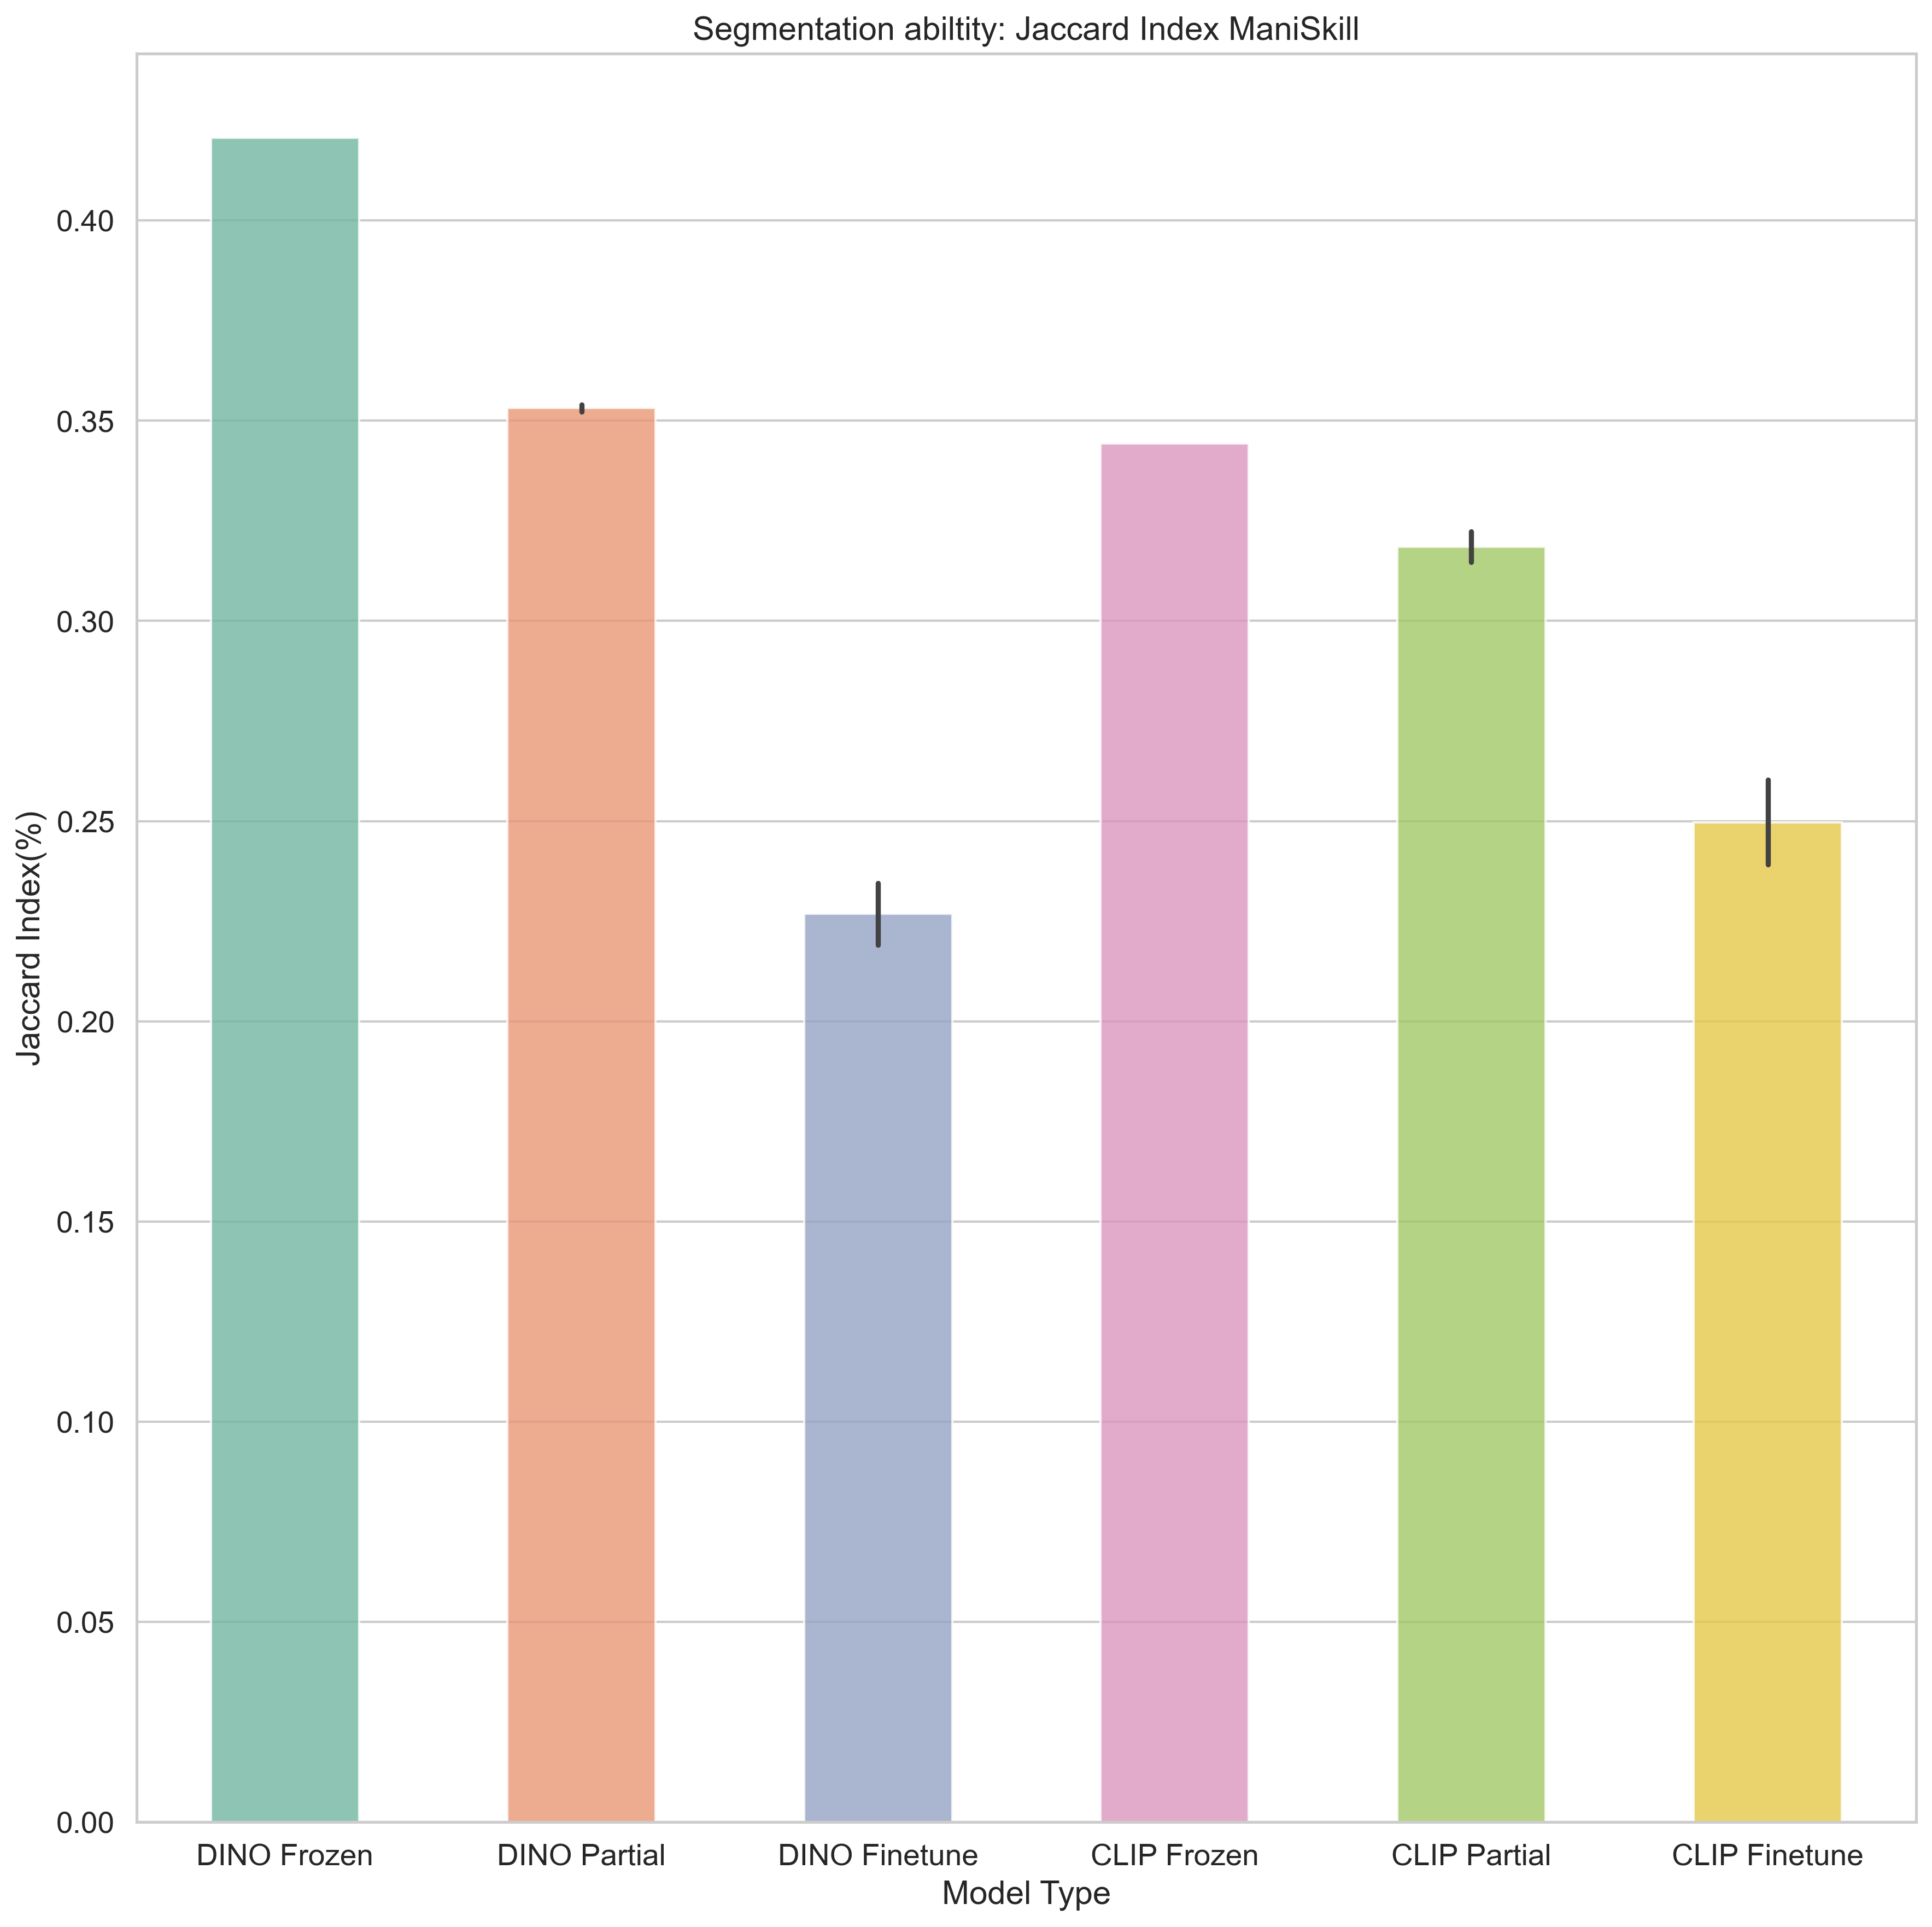

In [14]:
jaccard_index = [0.42062002258921743, 0.35423243885115097, 0.2416849635988227, 0.3443435035712217, 0.3142553214984212, 0.25605167583198163]
jaccard_index_1 = [0.42062002258921743, 0.35381684833794835, 0.21577311188132142, 0.3443435035712217, 0.31510576471562124, 0.22900103093479707]
jaccard_index_2 = [0.42062002258921743, 0.3514433099855191, 0.22299929772008062, 0.3443435035712217, 0.32617644590958433, 0.2640989261376772]
labels = ["DINO Frozen", "DINO Partial", "DINO Finetune", "CLIP Frozen", "CLIP Partial", "CLIP Finetune"]

jaccards = np.array([jaccard_index, jaccard_index_1, jaccard_index_2])
jaccard_mean = jaccards.mean(axis=0)
jaccard_df = pd.DataFrame(jaccards, columns=labels)
jaccard_df = jaccard_df.melt(var_name="Model Type", value_name="Jaccard Index")

plt.figure(figsize=(14, 14))
plt.xlabel("Model Type")
plt.ylabel("Jaccard Index(%)")
plt.title(f"Segmentation abiltity: Jaccard Index ManiSkill")
sns.barplot(data=jaccard_df, x="Model Type", y="Jaccard Index", palette="Set2", errorbar="se", width=0.5, alpha=0.8)

/var/folders/sz/_6t9n1rn6b7bxg8p0wzyw0g00000gn/T/ipykernel_14653/203294334.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=carla_jaccard_df, x="Model Type", y="Jaccard Index", palette="Set2", errorbar="se", width=0.5, alpha=0.8)


<Axes: title={'center': 'Segmentation abiltity: Jaccard Index CARLA'}, xlabel='Model Type', ylabel='Jaccard Index(%)'>

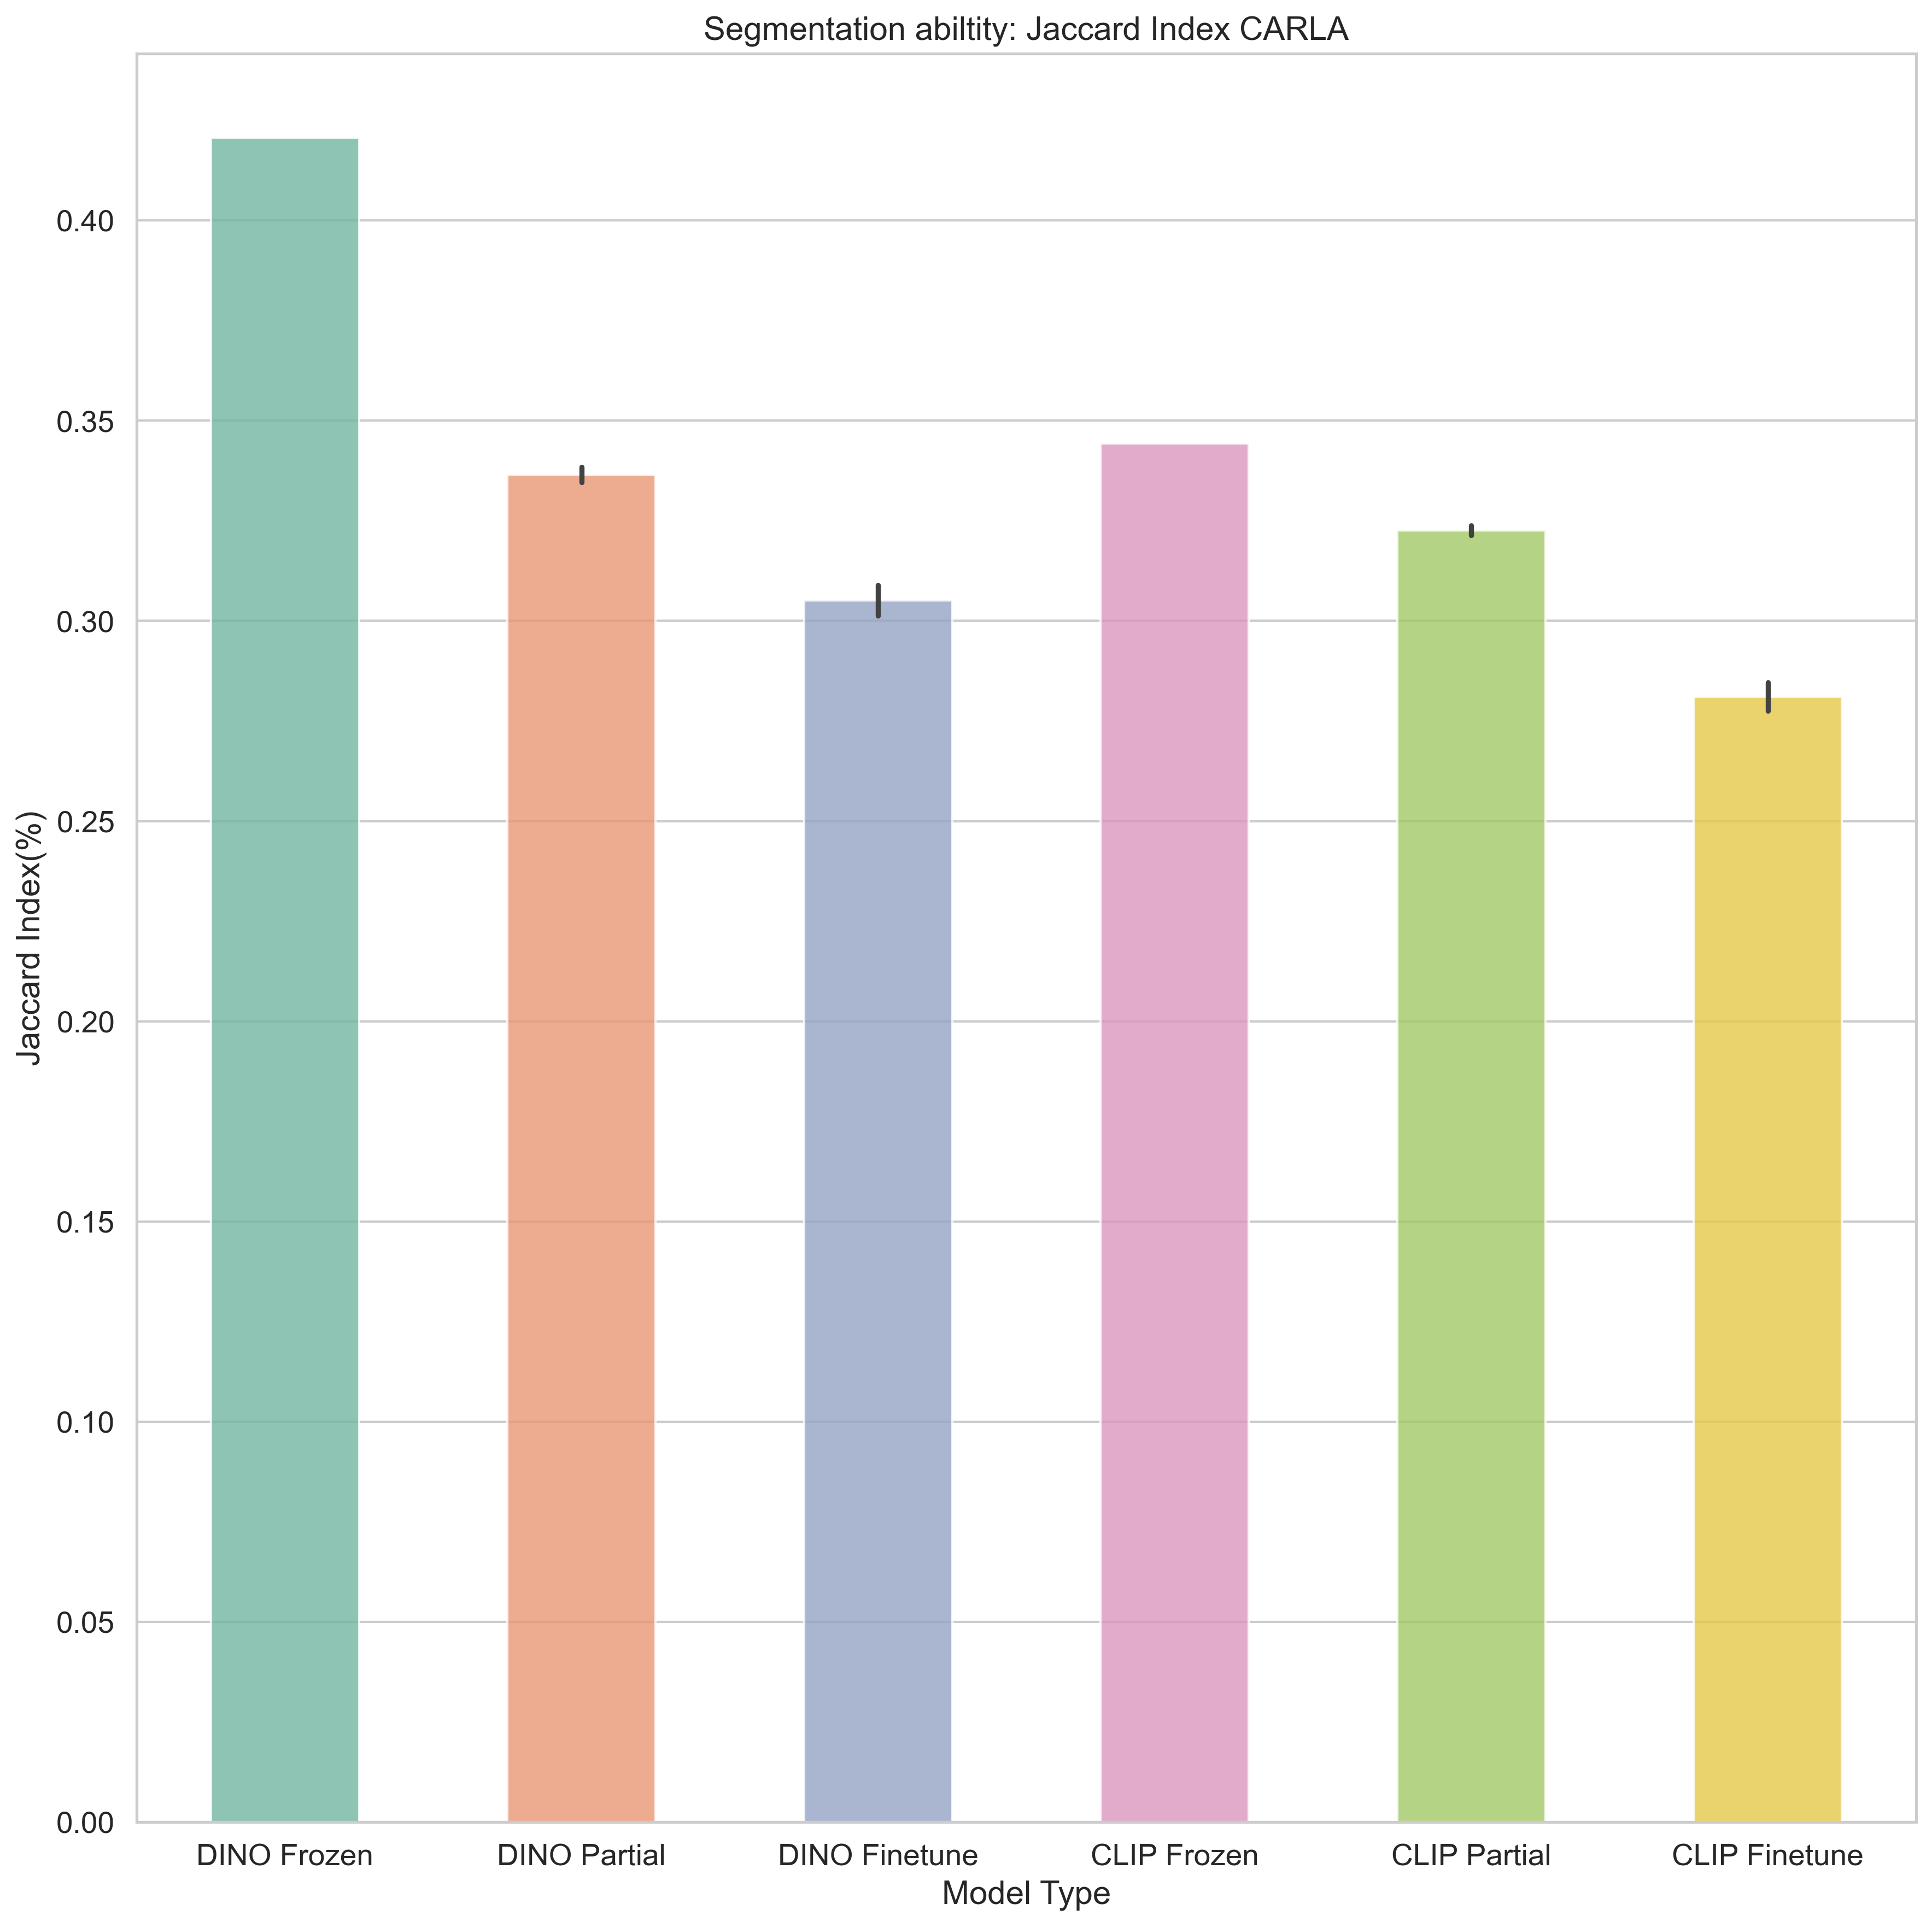

In [15]:
carla_jaccard_index = [0.42062002258921743, 0.3385418735277034, 0.30680819482240007, 0.34434350357122173, 0.3204477294238696, 0.27811764437070724]
carla_jaccard_index_1 = [0.42062002258921743, 0.3326359914666995, 0.31062349169721964, 0.34434350357122173, 0.32286260352209145, 0.2882331534705115]
carla_jaccard_index_2 = [0.42062002258921743, 0.3383682217096222, 0.2978009874869834, 0.34434350357122173, 0.32449156357639763, 0.2769207799674051]
labels = ["DINO Frozen", "DINO Partial", "DINO Finetune", "CLIP Frozen", "CLIP Partial", "CLIP Finetune"]

carla_jaccards = np.array([carla_jaccard_index, carla_jaccard_index_1, carla_jaccard_index_2])
carla_jaccard_mean = carla_jaccards.mean(axis=0)
carla_jaccard_df = pd.DataFrame(carla_jaccards, columns=labels)
carla_jaccard_df = carla_jaccard_df.melt(var_name="Model Type", value_name="Jaccard Index")

plt.figure(figsize=(14, 14))
plt.xlabel("Model Type")
plt.ylabel("Jaccard Index(%)")
plt.title(f"Segmentation abiltity: Jaccard Index CARLA")
sns.barplot(data=carla_jaccard_df, x="Model Type", y="Jaccard Index", palette="Set2", errorbar="se", width=0.5, alpha=0.8)

Pearson correlation: 0.81


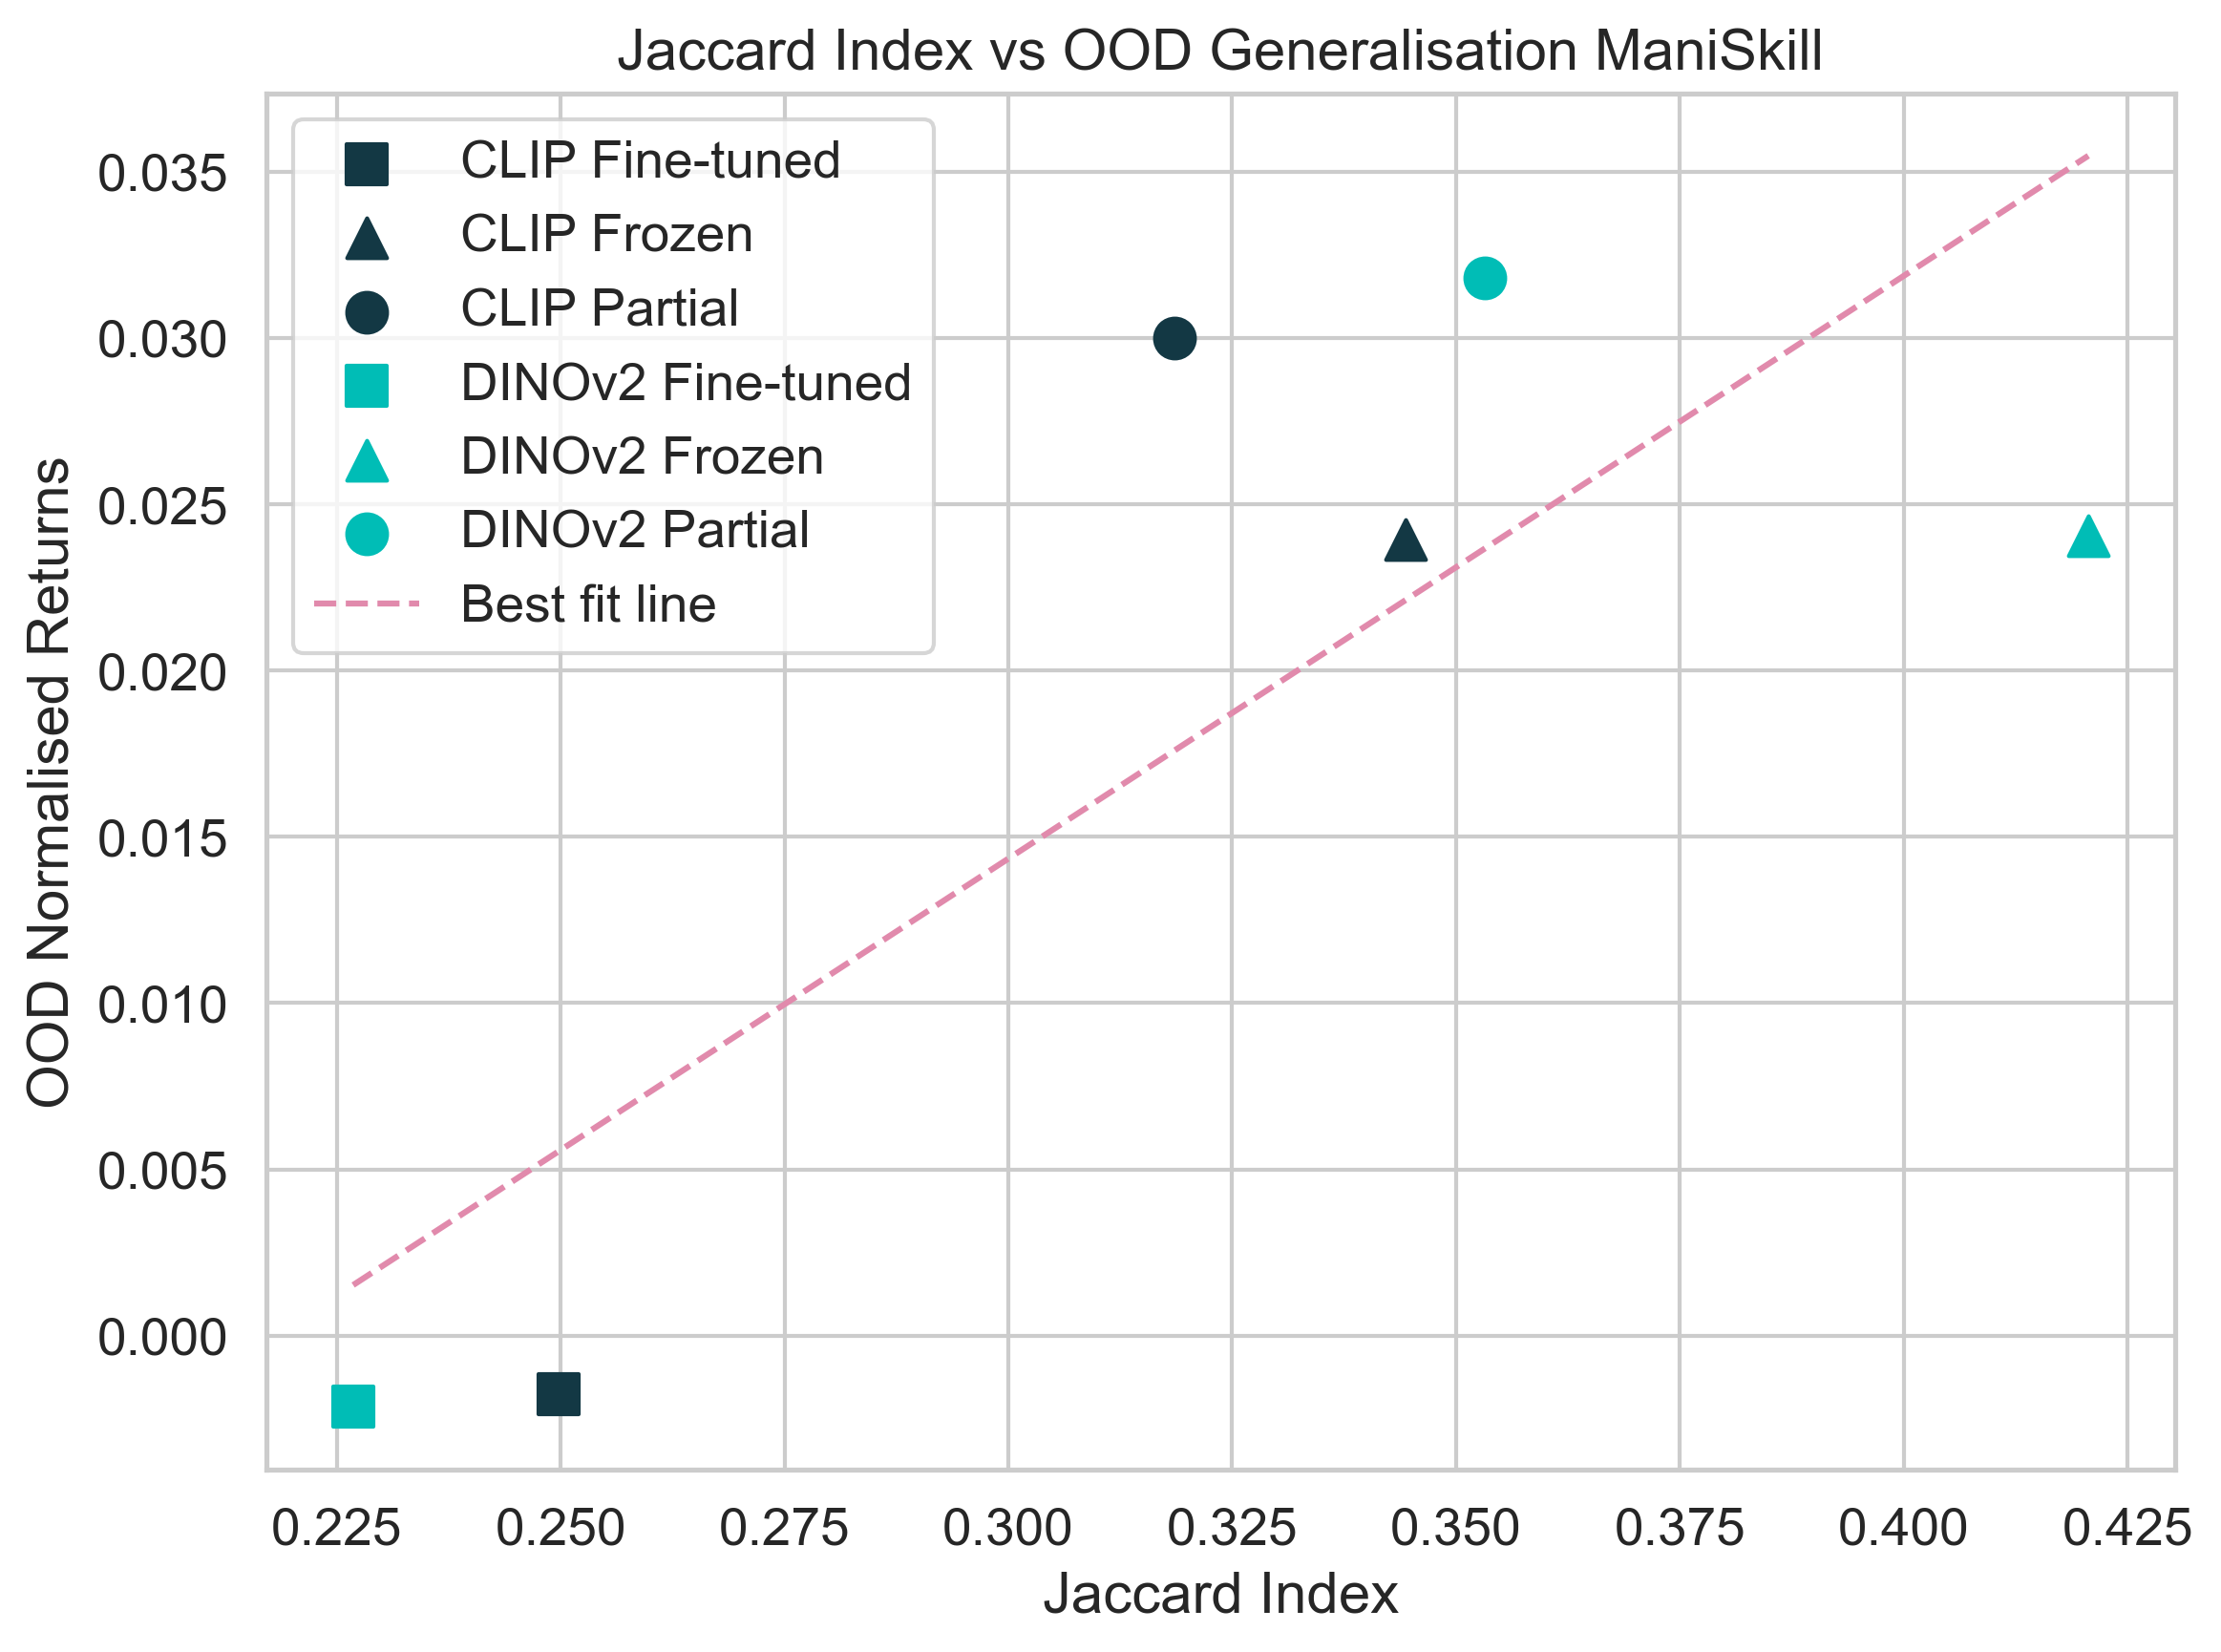

0.8063037148603059

In [24]:
def plot_correlation(x, y, models, configs, xlabel='X-axis', ylabel='Y-axis', title='Correlation Plot'):
    """
    Plots a scatter of x vs y, computes Pearson correlation, and draws a best-fit line.
    
    Parameters:
    - x, y: arrays of numerical values.
    - models: array of model names corresponding to each x/y pair.
    - configs: array of configuration names corresponding to each x/y pair.
    - xlabel, ylabel: labels for the axes.
    - title: plot title.
    
    Returns:
    - corr: float, Pearson correlation coefficient.
    """
    # Build DataFrame
    df = pd.DataFrame({'model': models, 'config': configs, 'x': x, 'y': y})
    
    # Compute Pearson correlation
    corr = np.corrcoef(df['x'], df['y'])[0, 1]
    print(f"Pearson correlation: {corr:.2f}")
    
    # Define default markers and colors
    markers = {'Partial': 'o', 'Fine-tuned': 's', 'Frozen': '^'}
    colors = {'DINOv2': '#00BDB6', 'CLIP': '#133844'}
    
    # Create scatter plot
    plt.figure(figsize=(8, 6))
    for (model, config), group in df.groupby(['model', 'config']):
        plt.scatter(
            group['x'],
            group['y'],
            marker=markers.get(config, 'o'),
            color=colors.get(model, 'gray'),
            label=f"{model} {config}",
            s=100
        )
    
    # Plot line of best fit
    m, b = np.polyfit(df['x'], df['y'], 1)
    x_vals = np.linspace(df['x'].min(), df['x'].max(), 100)
    plt.plot(x_vals, m*x_vals + b, linestyle='--', label='Best fit line', color='#E18AAC')
    
    # Labels and title
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return corr

# Example usage with your data:
data = {
    'model': [
        'DINOv2', 'DINOv2', 'DINOv2',
        'CLIP', 'CLIP', 'CLIP'
    ],
    'config': [
        'Frozen', 'Partial', 'Fine-tuned',
        'Frozen', 'Partial', 'Fine-tuned',
    ],
    'jaccard': jaccard_mean,
    'imagenet': sorted(imagenet_mean[:3], reverse=True) + sorted(imagenet_mean[3:], reverse=True),
    'id_performance': [
        0.042606, 0.044185, 0.047413,
        0.035608, 0.045121, 0.046785
    ],
    'ood_generalisation': [
        0.024064, 0.031808, -0.002142,
        0.023927, 0.029993, -0.001749
    ]
}

df = pd.DataFrame(data)
# Call the function
plot_correlation(
    df['jaccard'], 
    df['ood_generalisation'], 
    df['model'], 
    df['config'],
    xlabel='Jaccard Index', 
    ylabel='OOD Normalised Returns', 
    title='Jaccard Index vs OOD Generalisation ManiSkill'
)

Pearson correlation: 0.86


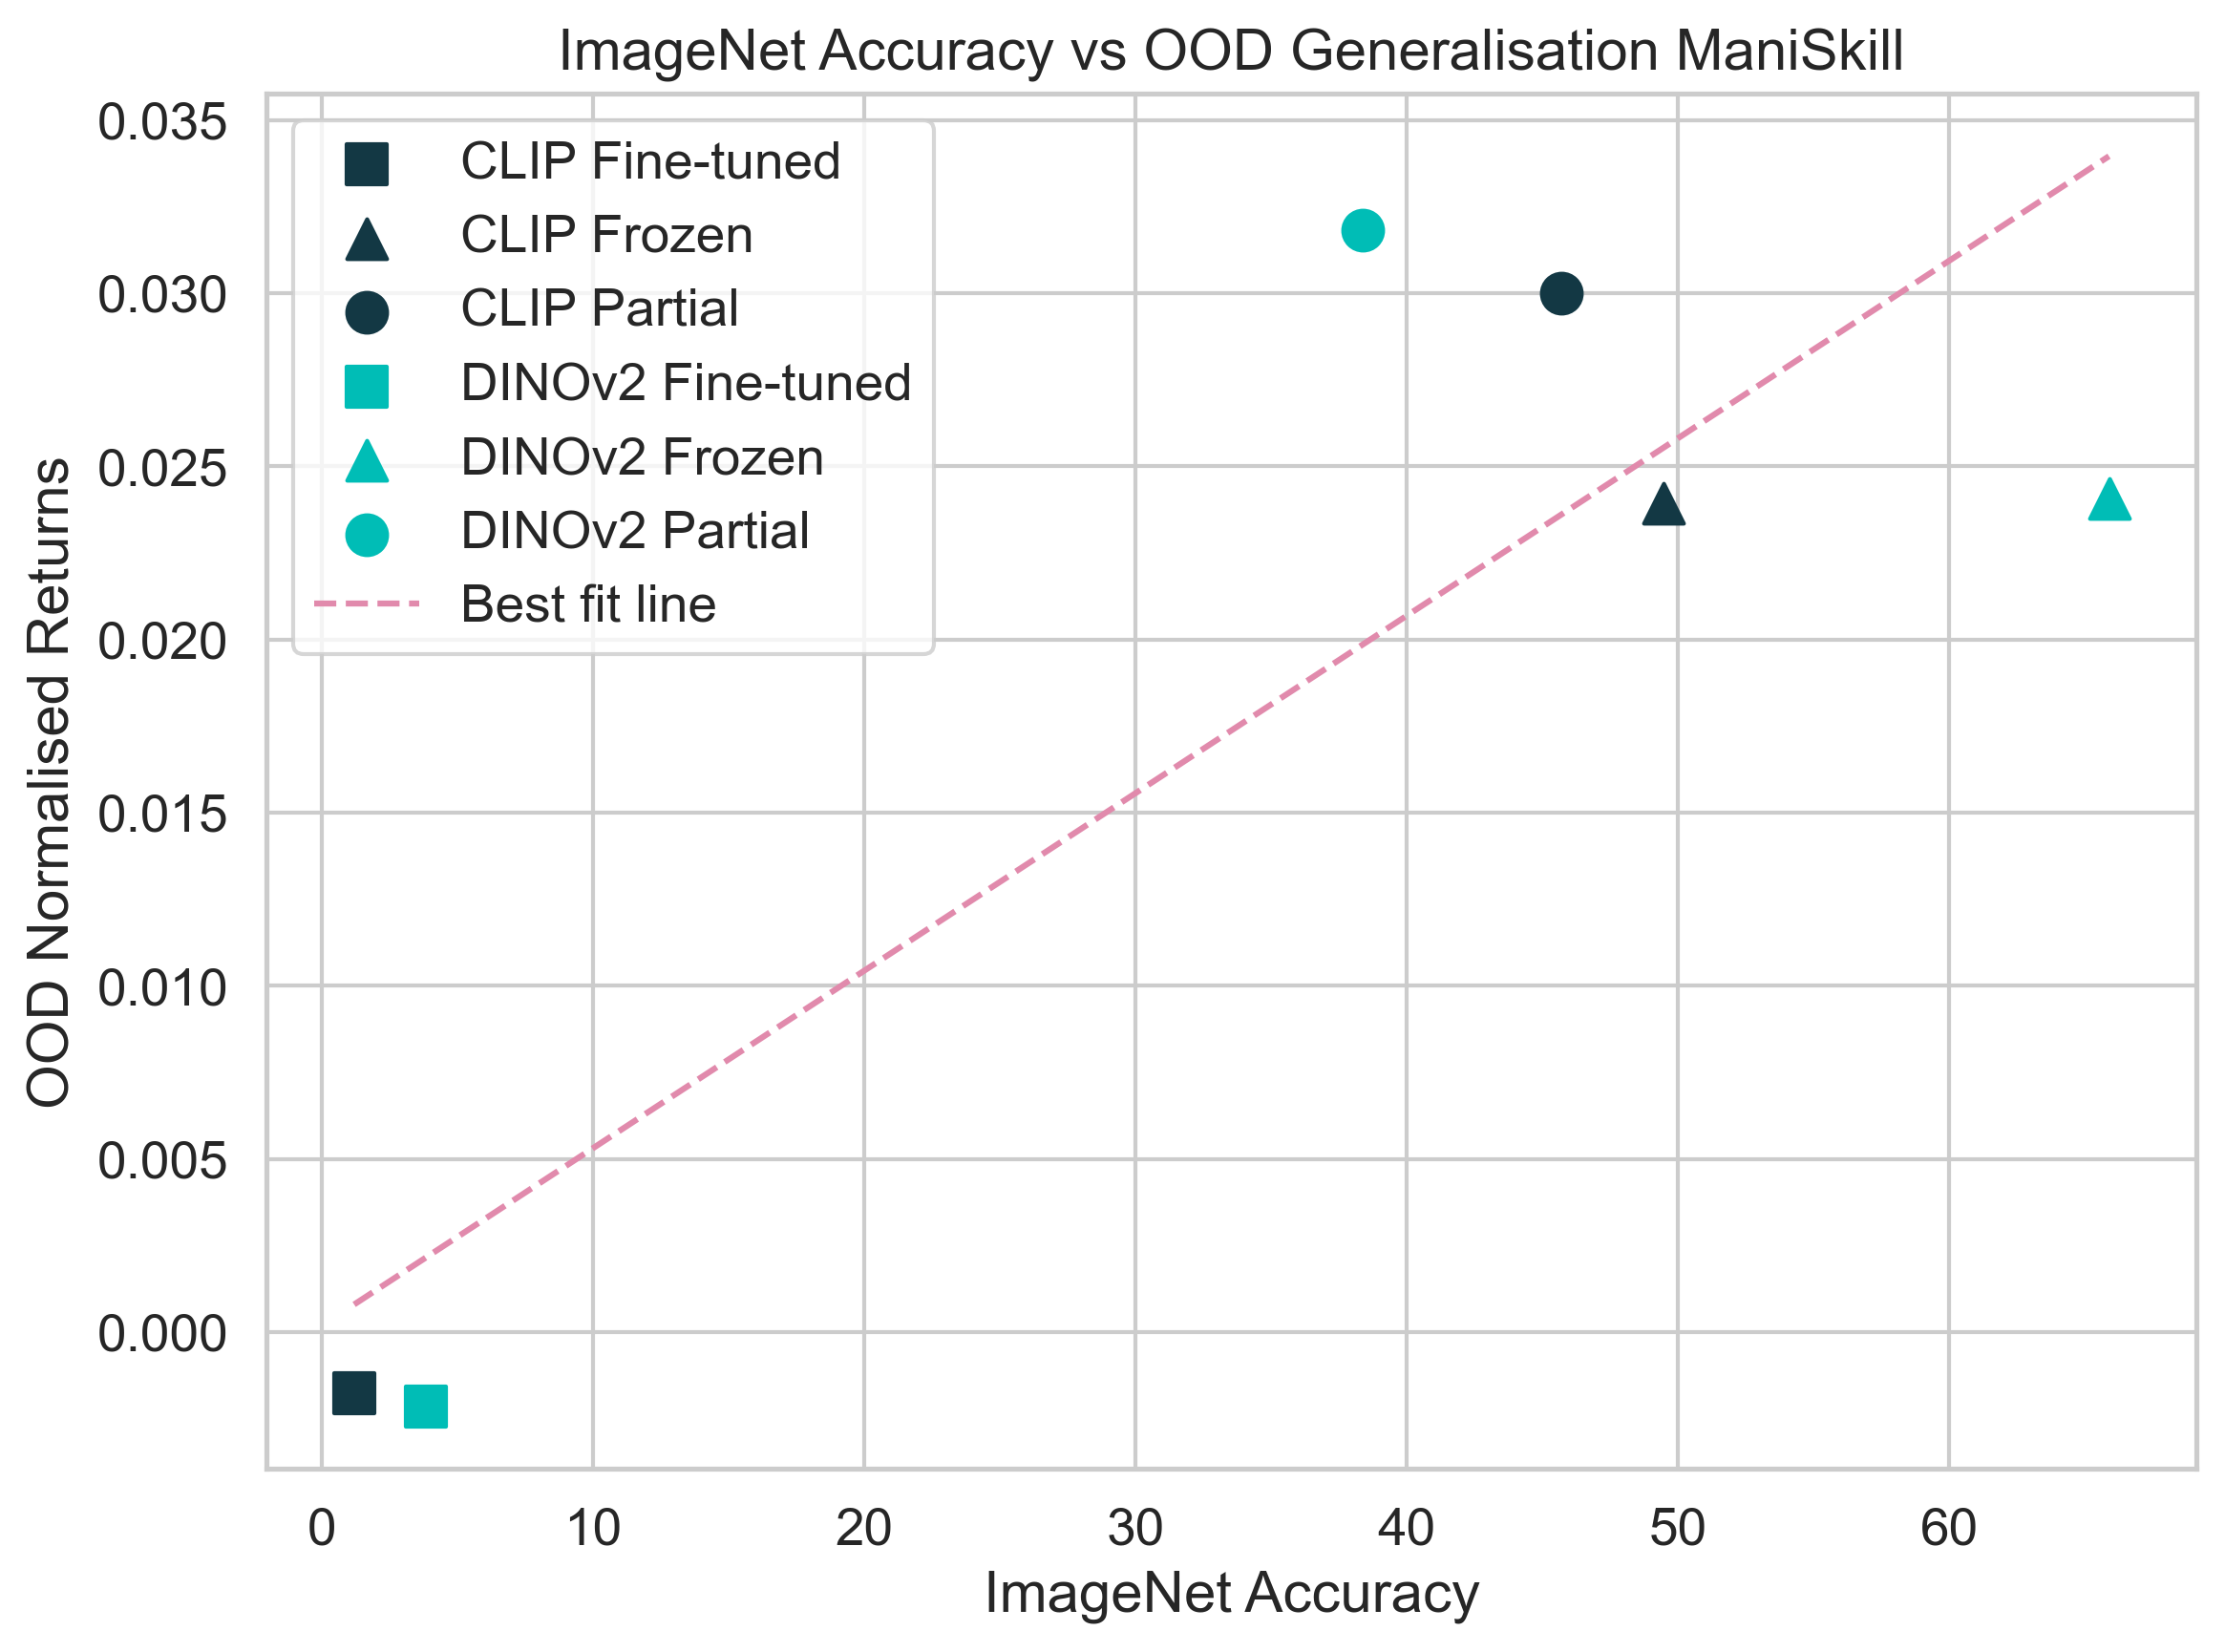

0.8619410707136842

In [25]:
plot_correlation(
    df['imagenet'], 
    df['ood_generalisation'], 
    df['model'], 
    df['config'],
    xlabel='ImageNet Accuracy', 
    ylabel='OOD Normalised Returns',
    title='ImageNet Accuracy vs OOD Generalisation ManiSkill'
)

Pearson correlation: -0.50


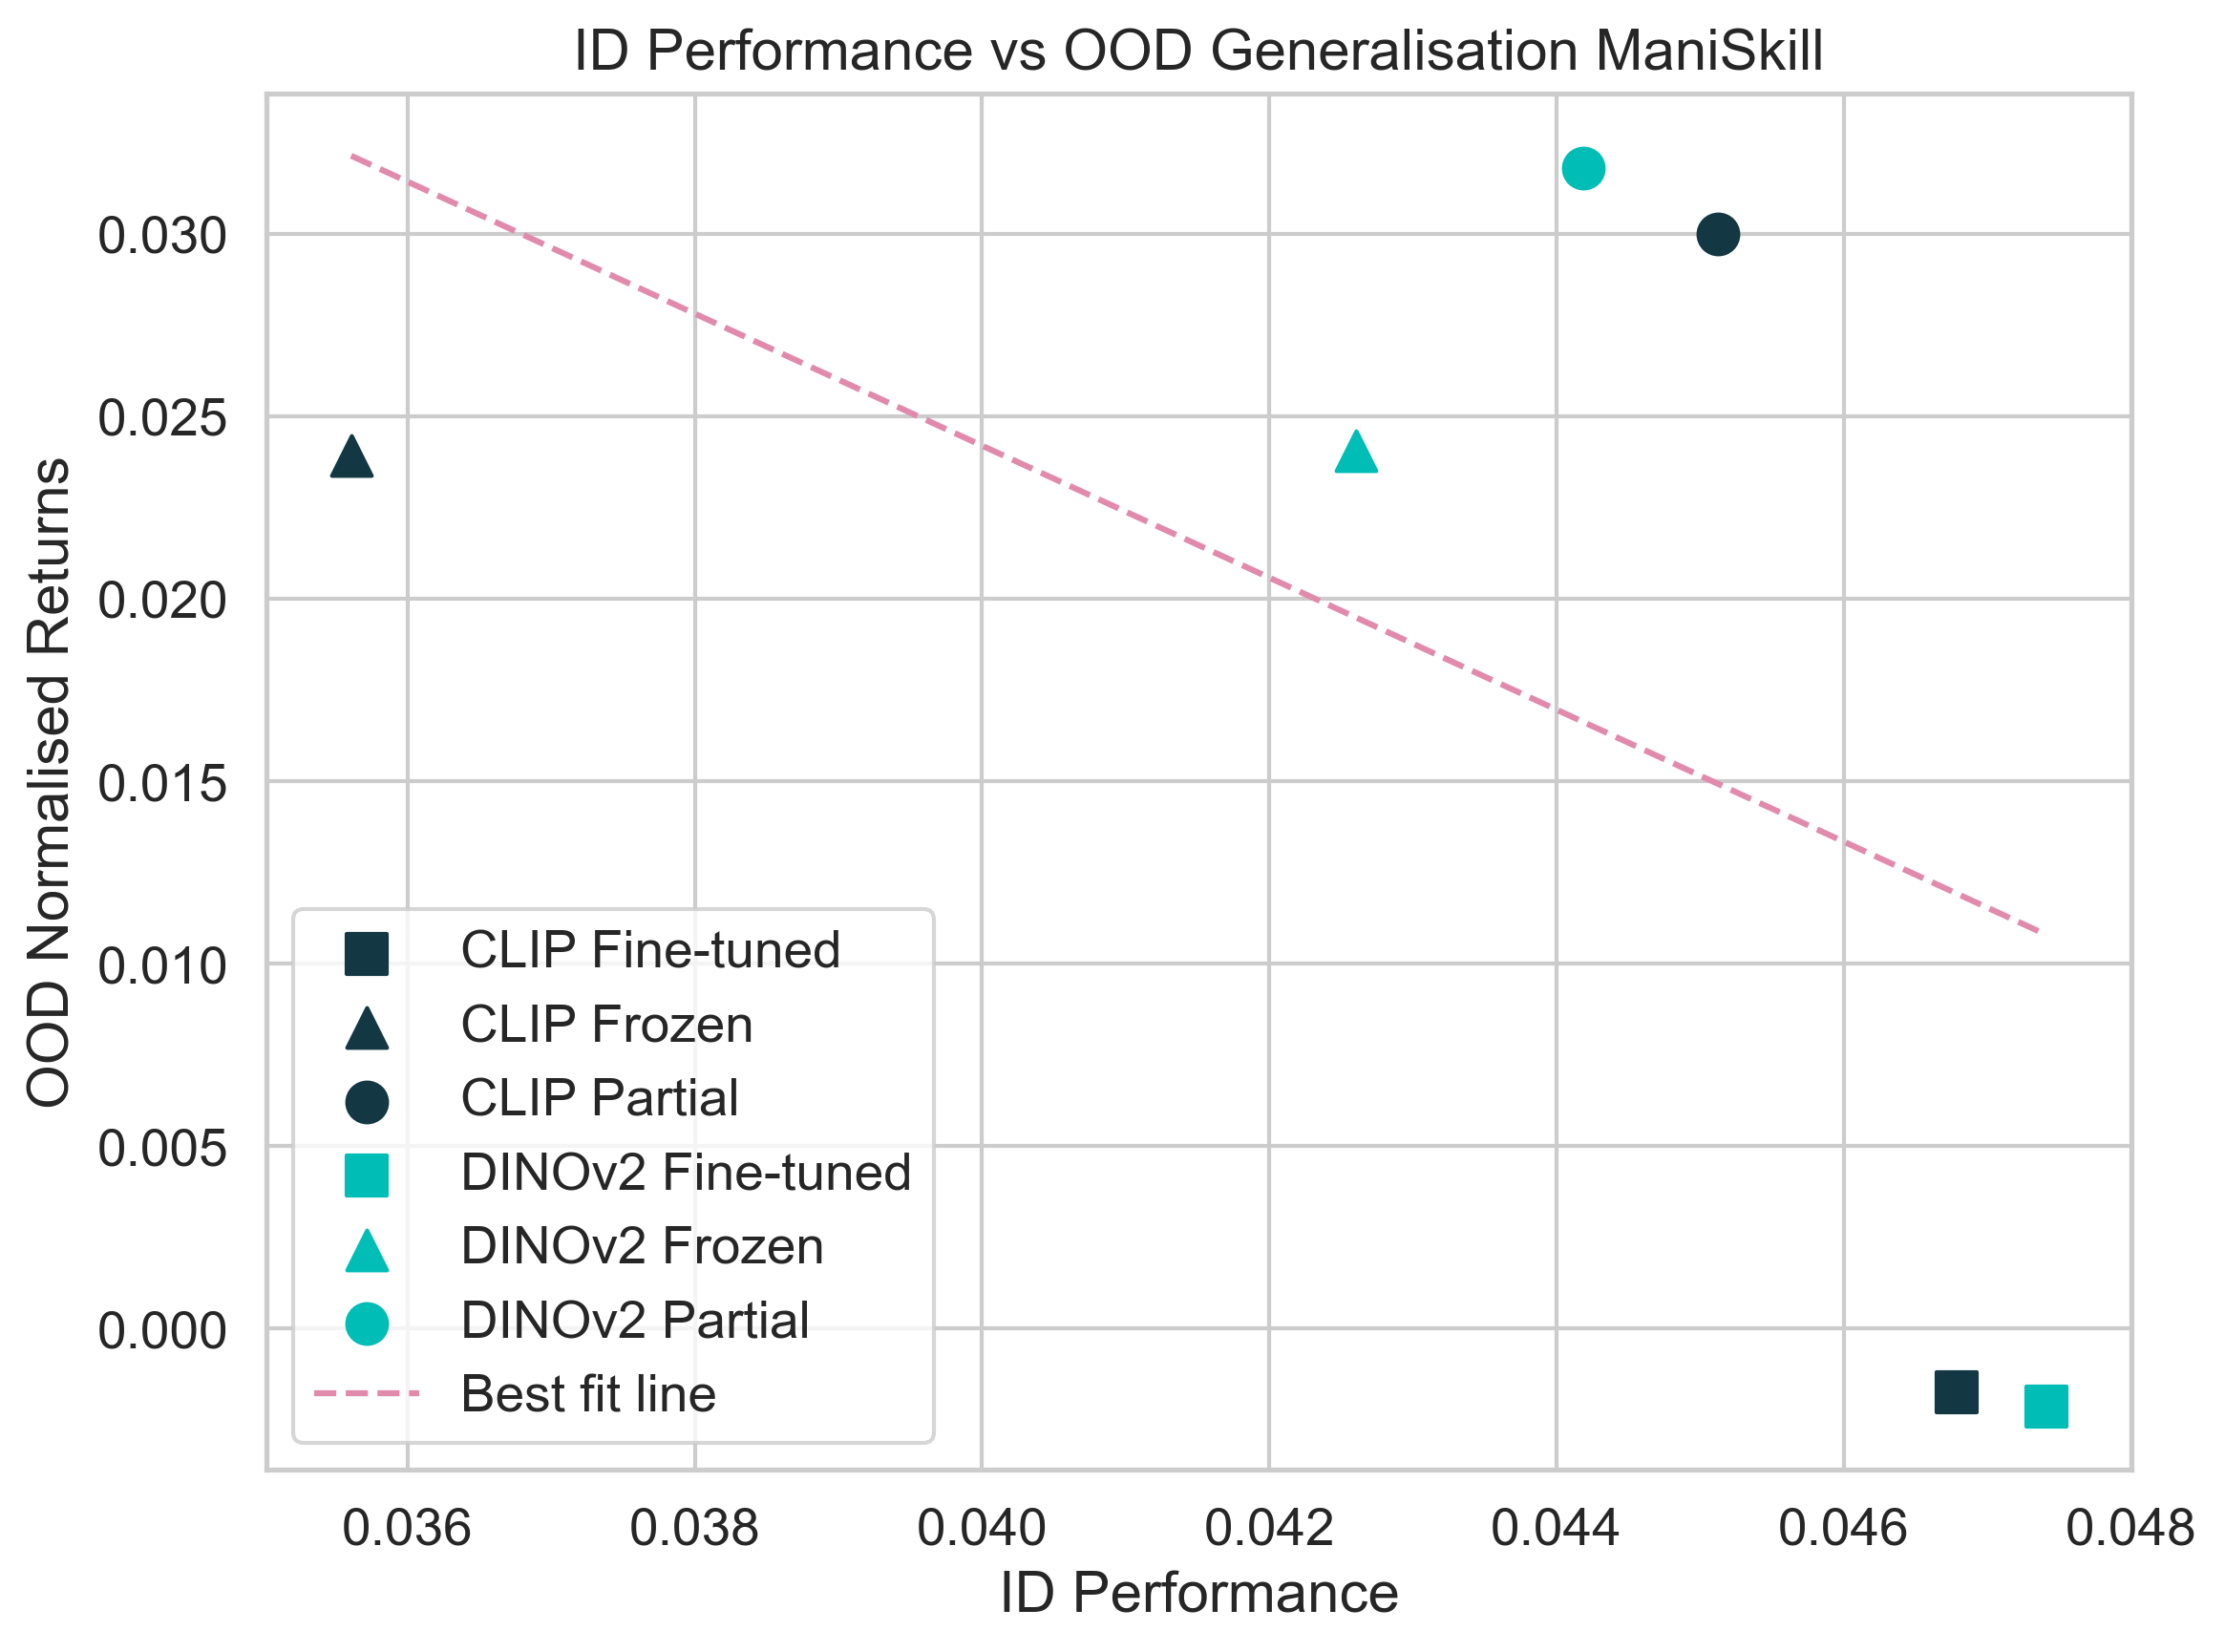

-0.5009980069141533

In [26]:
plot_correlation(
    df['id_performance'], 
    df['ood_generalisation'], 
    df['model'], 
    df['config'],
    xlabel='ID Performance', 
    ylabel='OOD Normalised Returns',
    title='ID Performance vs OOD Generalisation ManiSkill'
)

Pearson correlation: 0.80


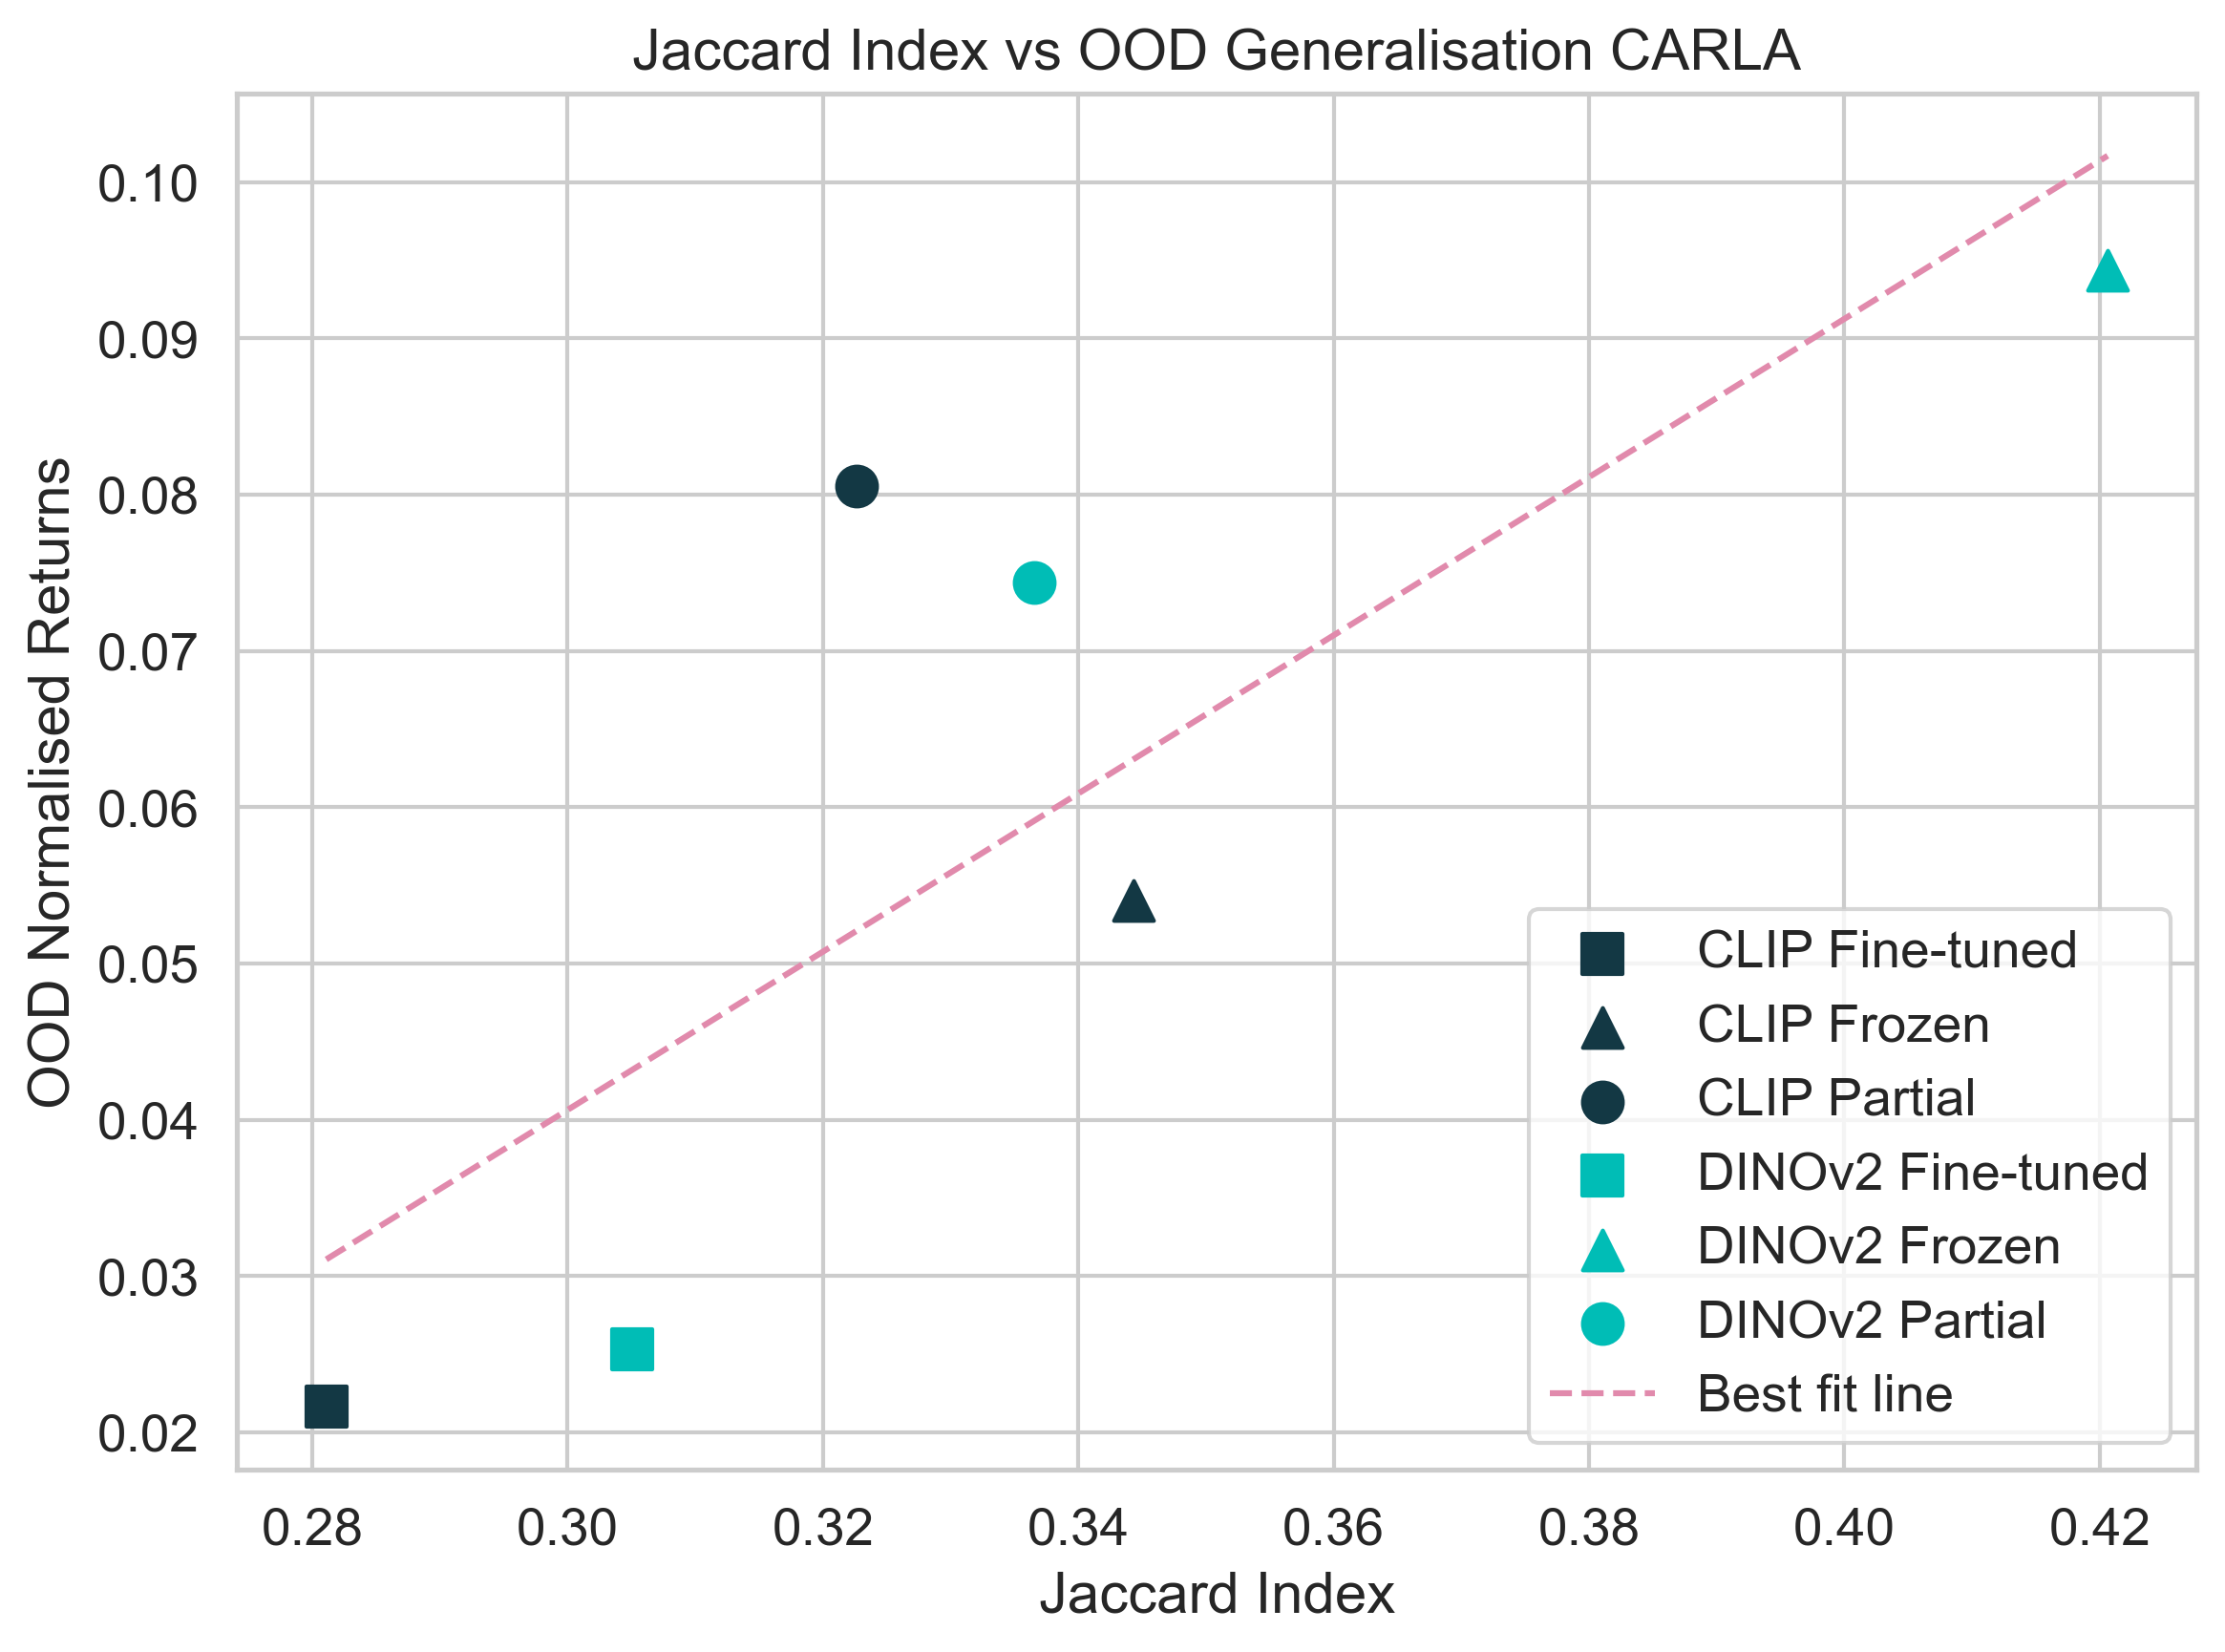

0.8045003589062955

In [27]:
data = {
    'model': [
        'DINOv2', 'DINOv2', 'DINOv2',
        'CLIP', 'CLIP', 'CLIP'
    ],
    'config': [
        'Frozen', 'Partial', 'Fine-tuned',
        'Frozen', 'Partial', 'Fine-tuned',
    ],
    'jaccard': carla_jaccard_mean,
    'imagenet': sorted(carla_imagenet_mean[:3], reverse=True) + sorted(carla_imagenet_mean[3:], reverse=True),
    'id_performance': [
        0.141108, 0.175559, 0.192213,
        0.127449, 0.180962, 0.157970
    ],
    'ood_generalisation': [
        0.094335, 0.074363, 0.025301,
        0.054035, 0.080551, 0.021624
    ],
}



df = pd.DataFrame(data)
# Call the function
plot_correlation(
    df['jaccard'], 
    df['ood_generalisation'], 
    df['model'], 
    df['config'],
    xlabel='Jaccard Index', 
    ylabel='OOD Normalised Returns',
    title='Jaccard Index vs OOD Generalisation CARLA'
)

Pearson correlation: 0.92


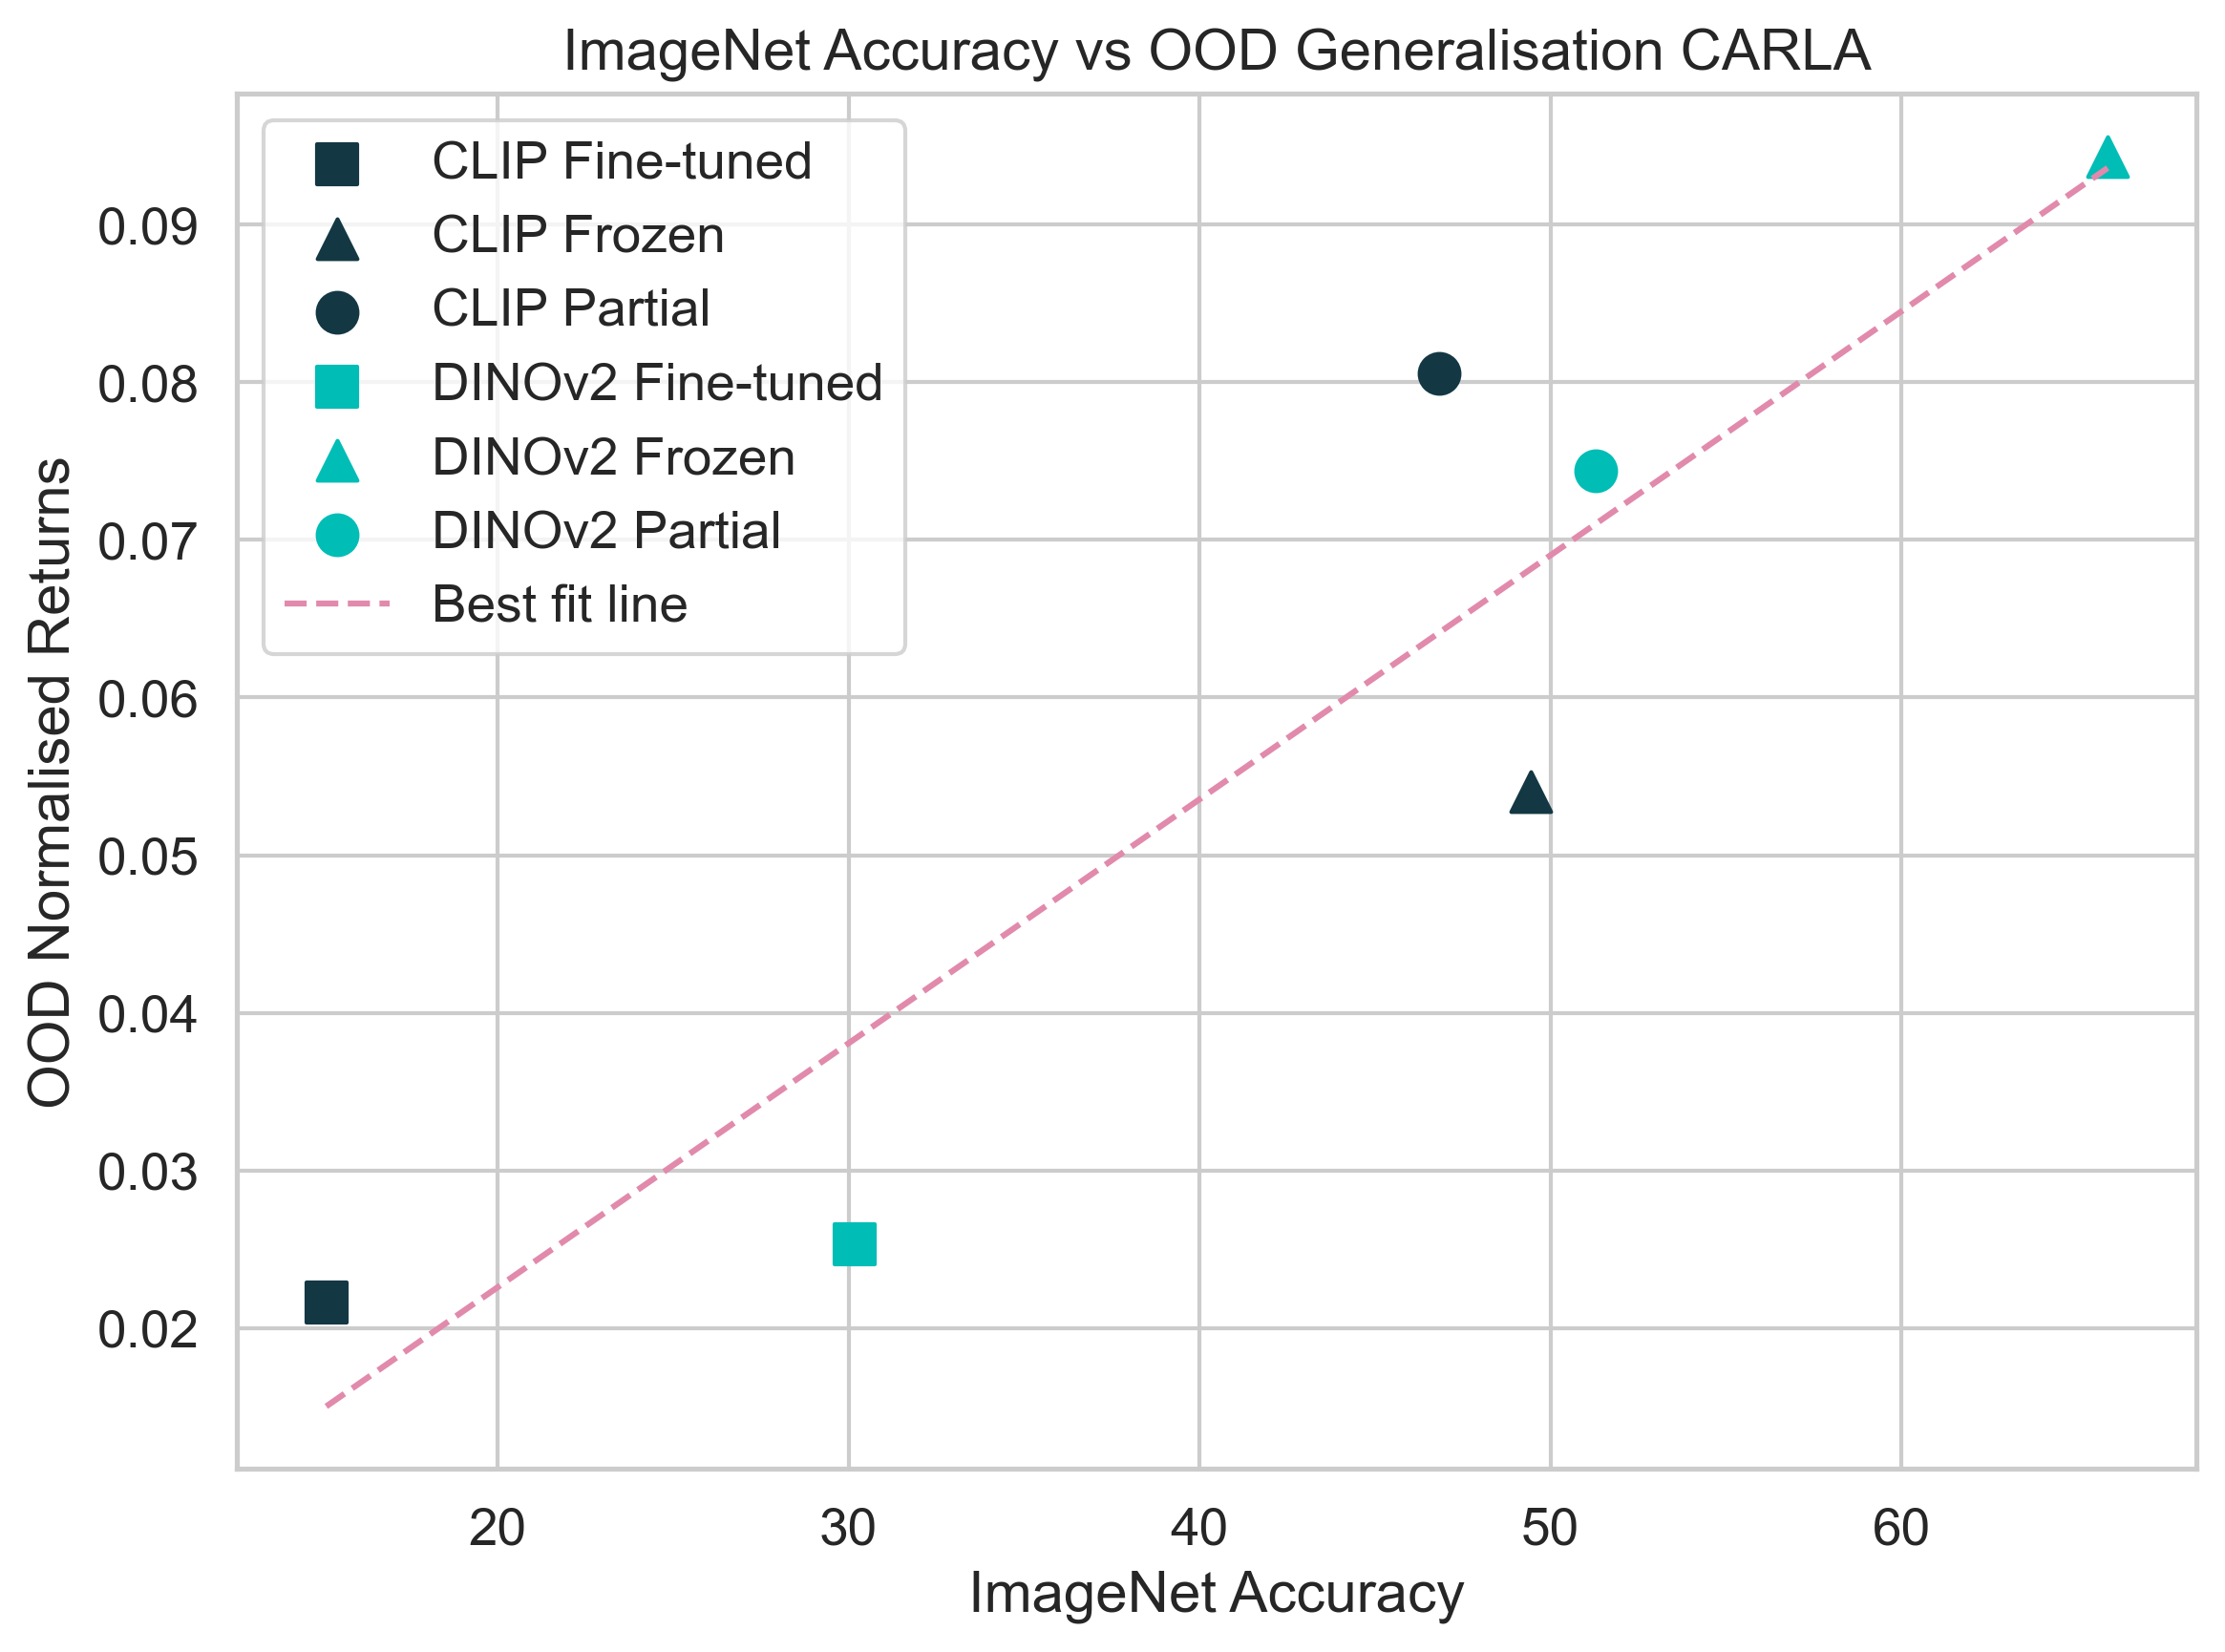

0.9195570124061597

In [28]:
plot_correlation(
    df['imagenet'], 
    df['ood_generalisation'], 
    df['model'], 
    df['config'],
    xlabel='ImageNet Accuracy', 
    ylabel='OOD Normalised Returns',
    title='ImageNet Accuracy vs OOD Generalisation CARLA'
)

Pearson correlation: -0.22


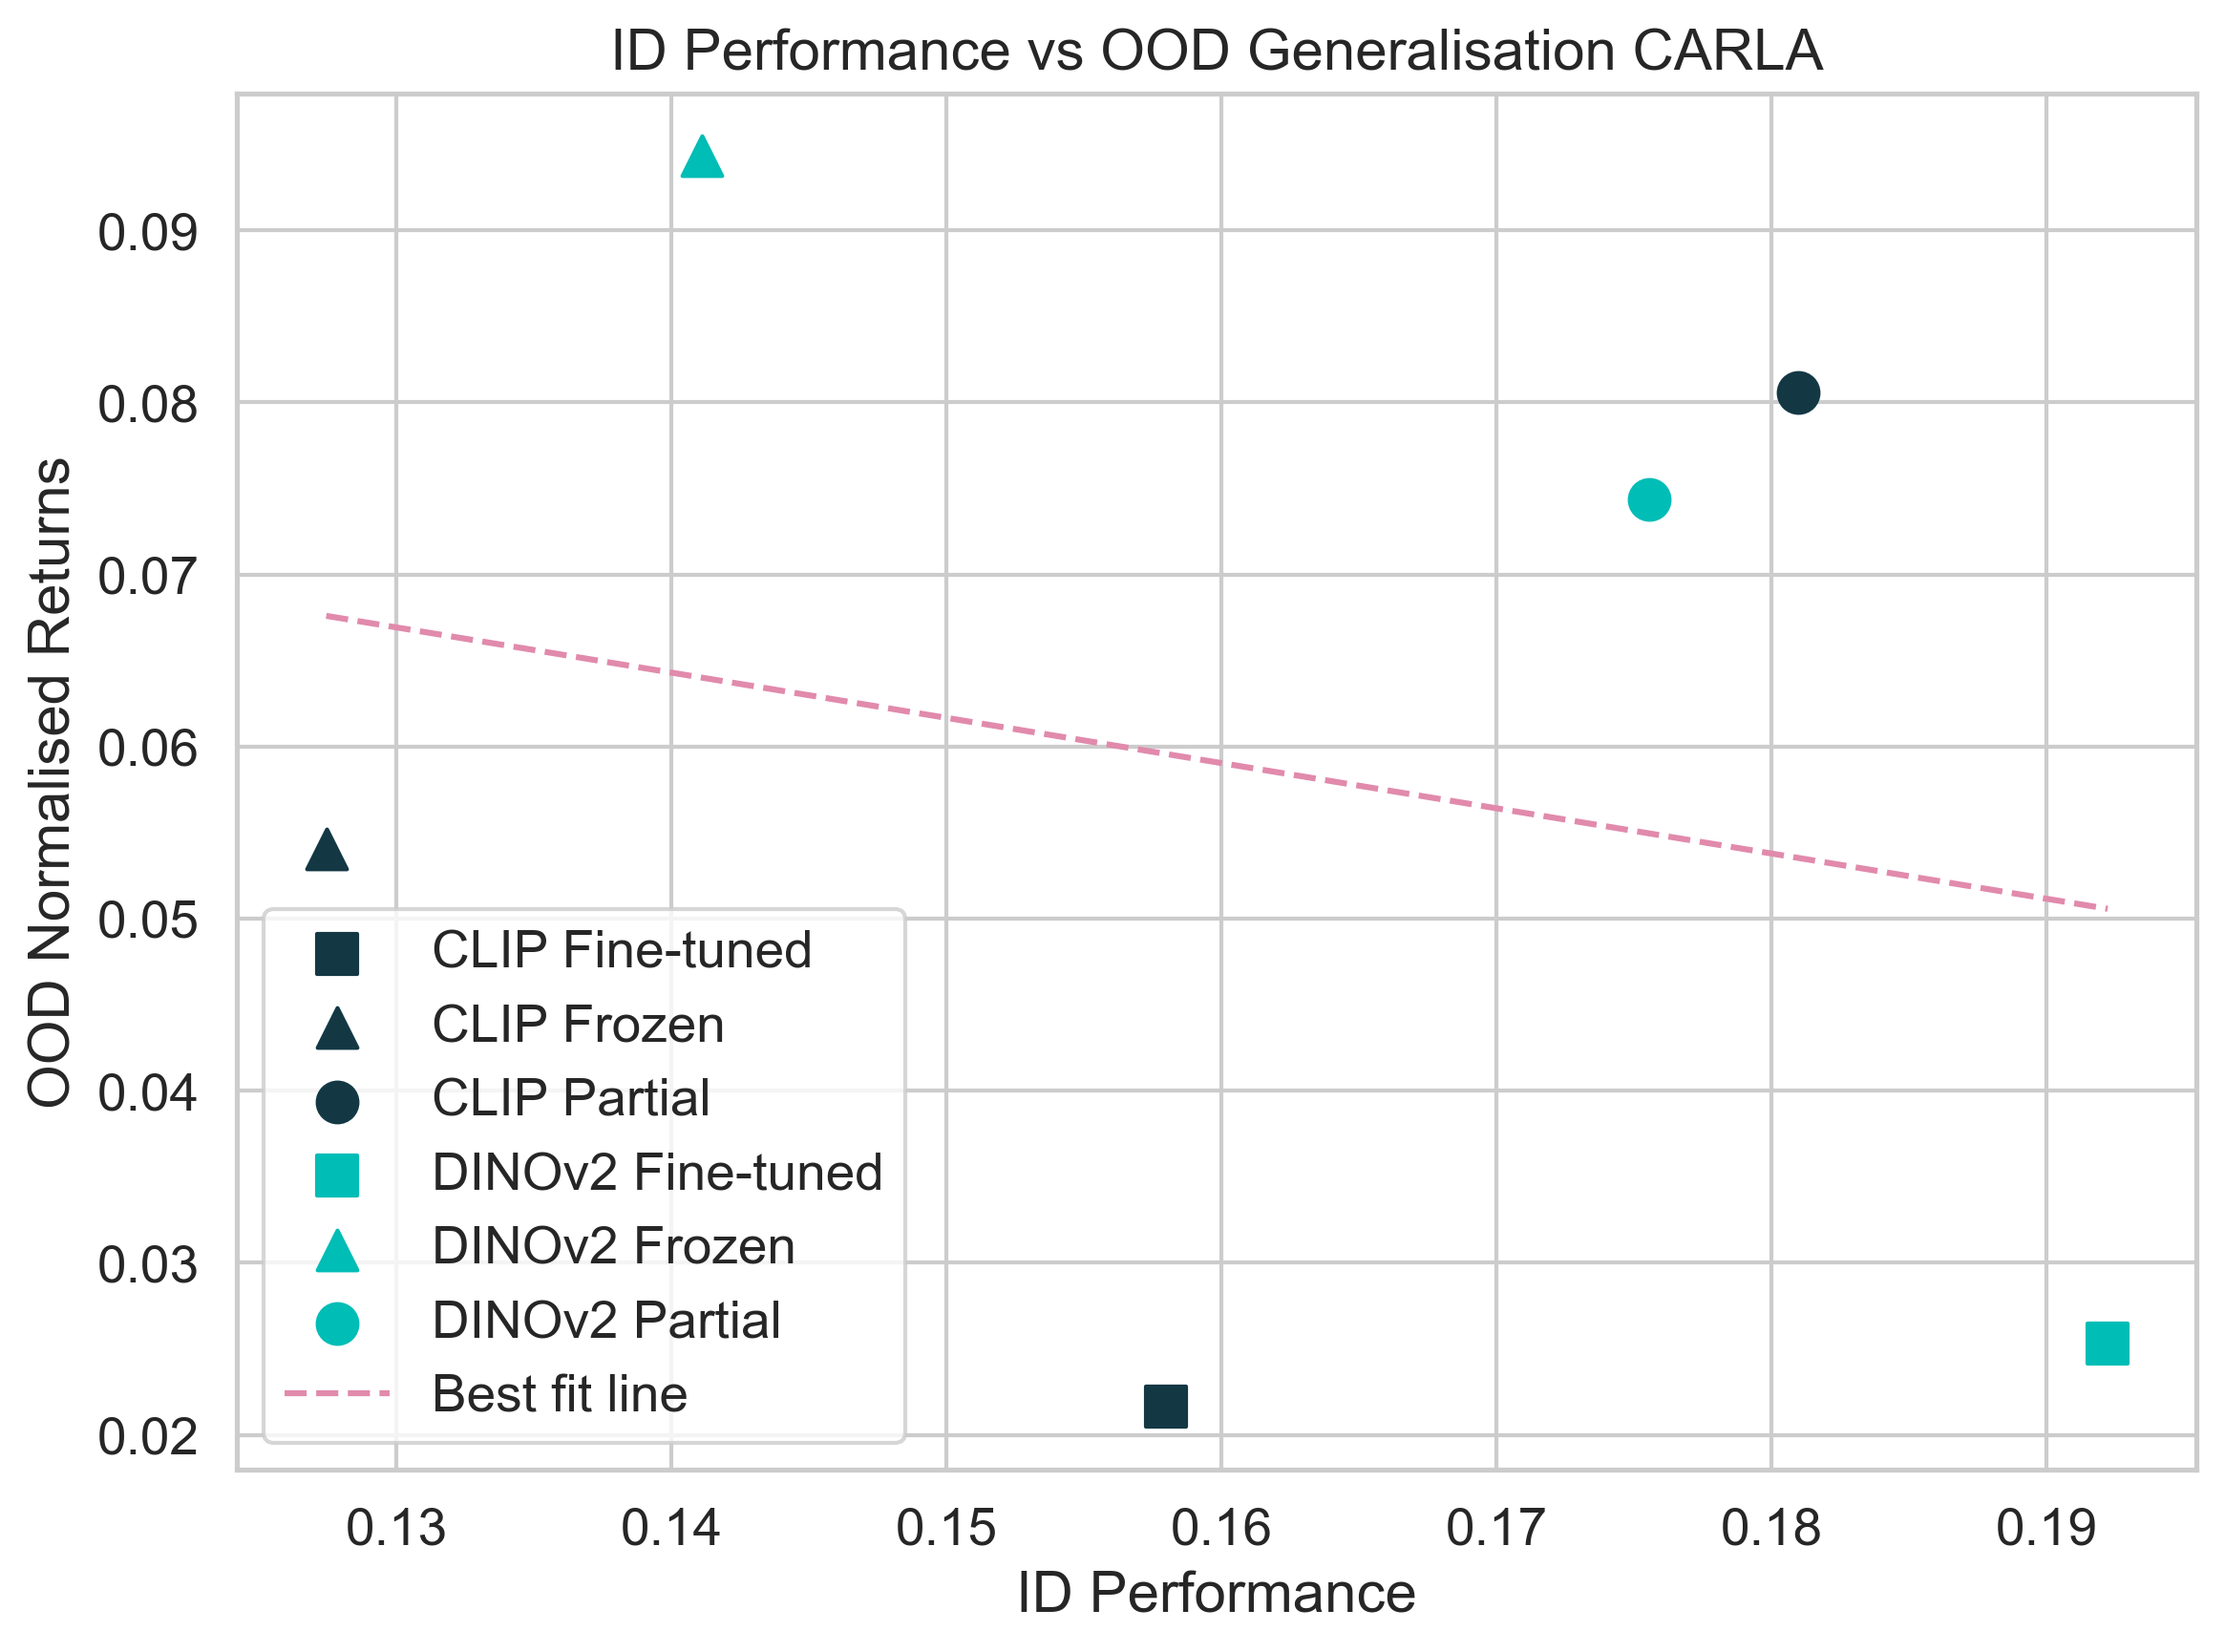

-0.21812853943750604

In [29]:
plot_correlation(
    df['id_performance'], 
    df['ood_generalisation'], 
    df['model'], 
    df['config'],
    xlabel='ID Performance', 
    ylabel='OOD Normalised Returns',
    title='ID Performance vs OOD Generalisation CARLA'
)

{'con': [0.020441, 0.020444, 0.020452, 0.020442, 0.020441, 0.020441, 0.020441], 'dyn': [25.265211, 24.316788, 27.322145, 29.175451, 16.089951, 22.641464, 28.377621], 'image': [166.301422, 677.794373, 588.341567, 544.465925, 835.42787, 651.739963, 541.945828], 'policy': [0.010501, 0.006771, 0.025531, -0.018042, 0.00261, 0.002744, 0.00864], 'rep': [25.265211, 24.316788, 27.322145, 29.175451, 16.089951, 22.641464, 28.377621], 'repval': [1.166019, 0.983611, 1.147768, 1.091156, 1.102121, 1.061075, 0.999933], 'rew': [0.579171, 0.568113, 0.514484, 0.532242, 0.610523, 0.554828, 0.542938], 'value': [1.109765, 0.902321, 1.086068, 1.065561, 0.963385, 0.986547, 0.970798], 'ood': [-0.002785, 0.029589, 0.033893, -0.002662, 0.027372, 0.027361, -0.002644]}
Pearson correlation: 0.53


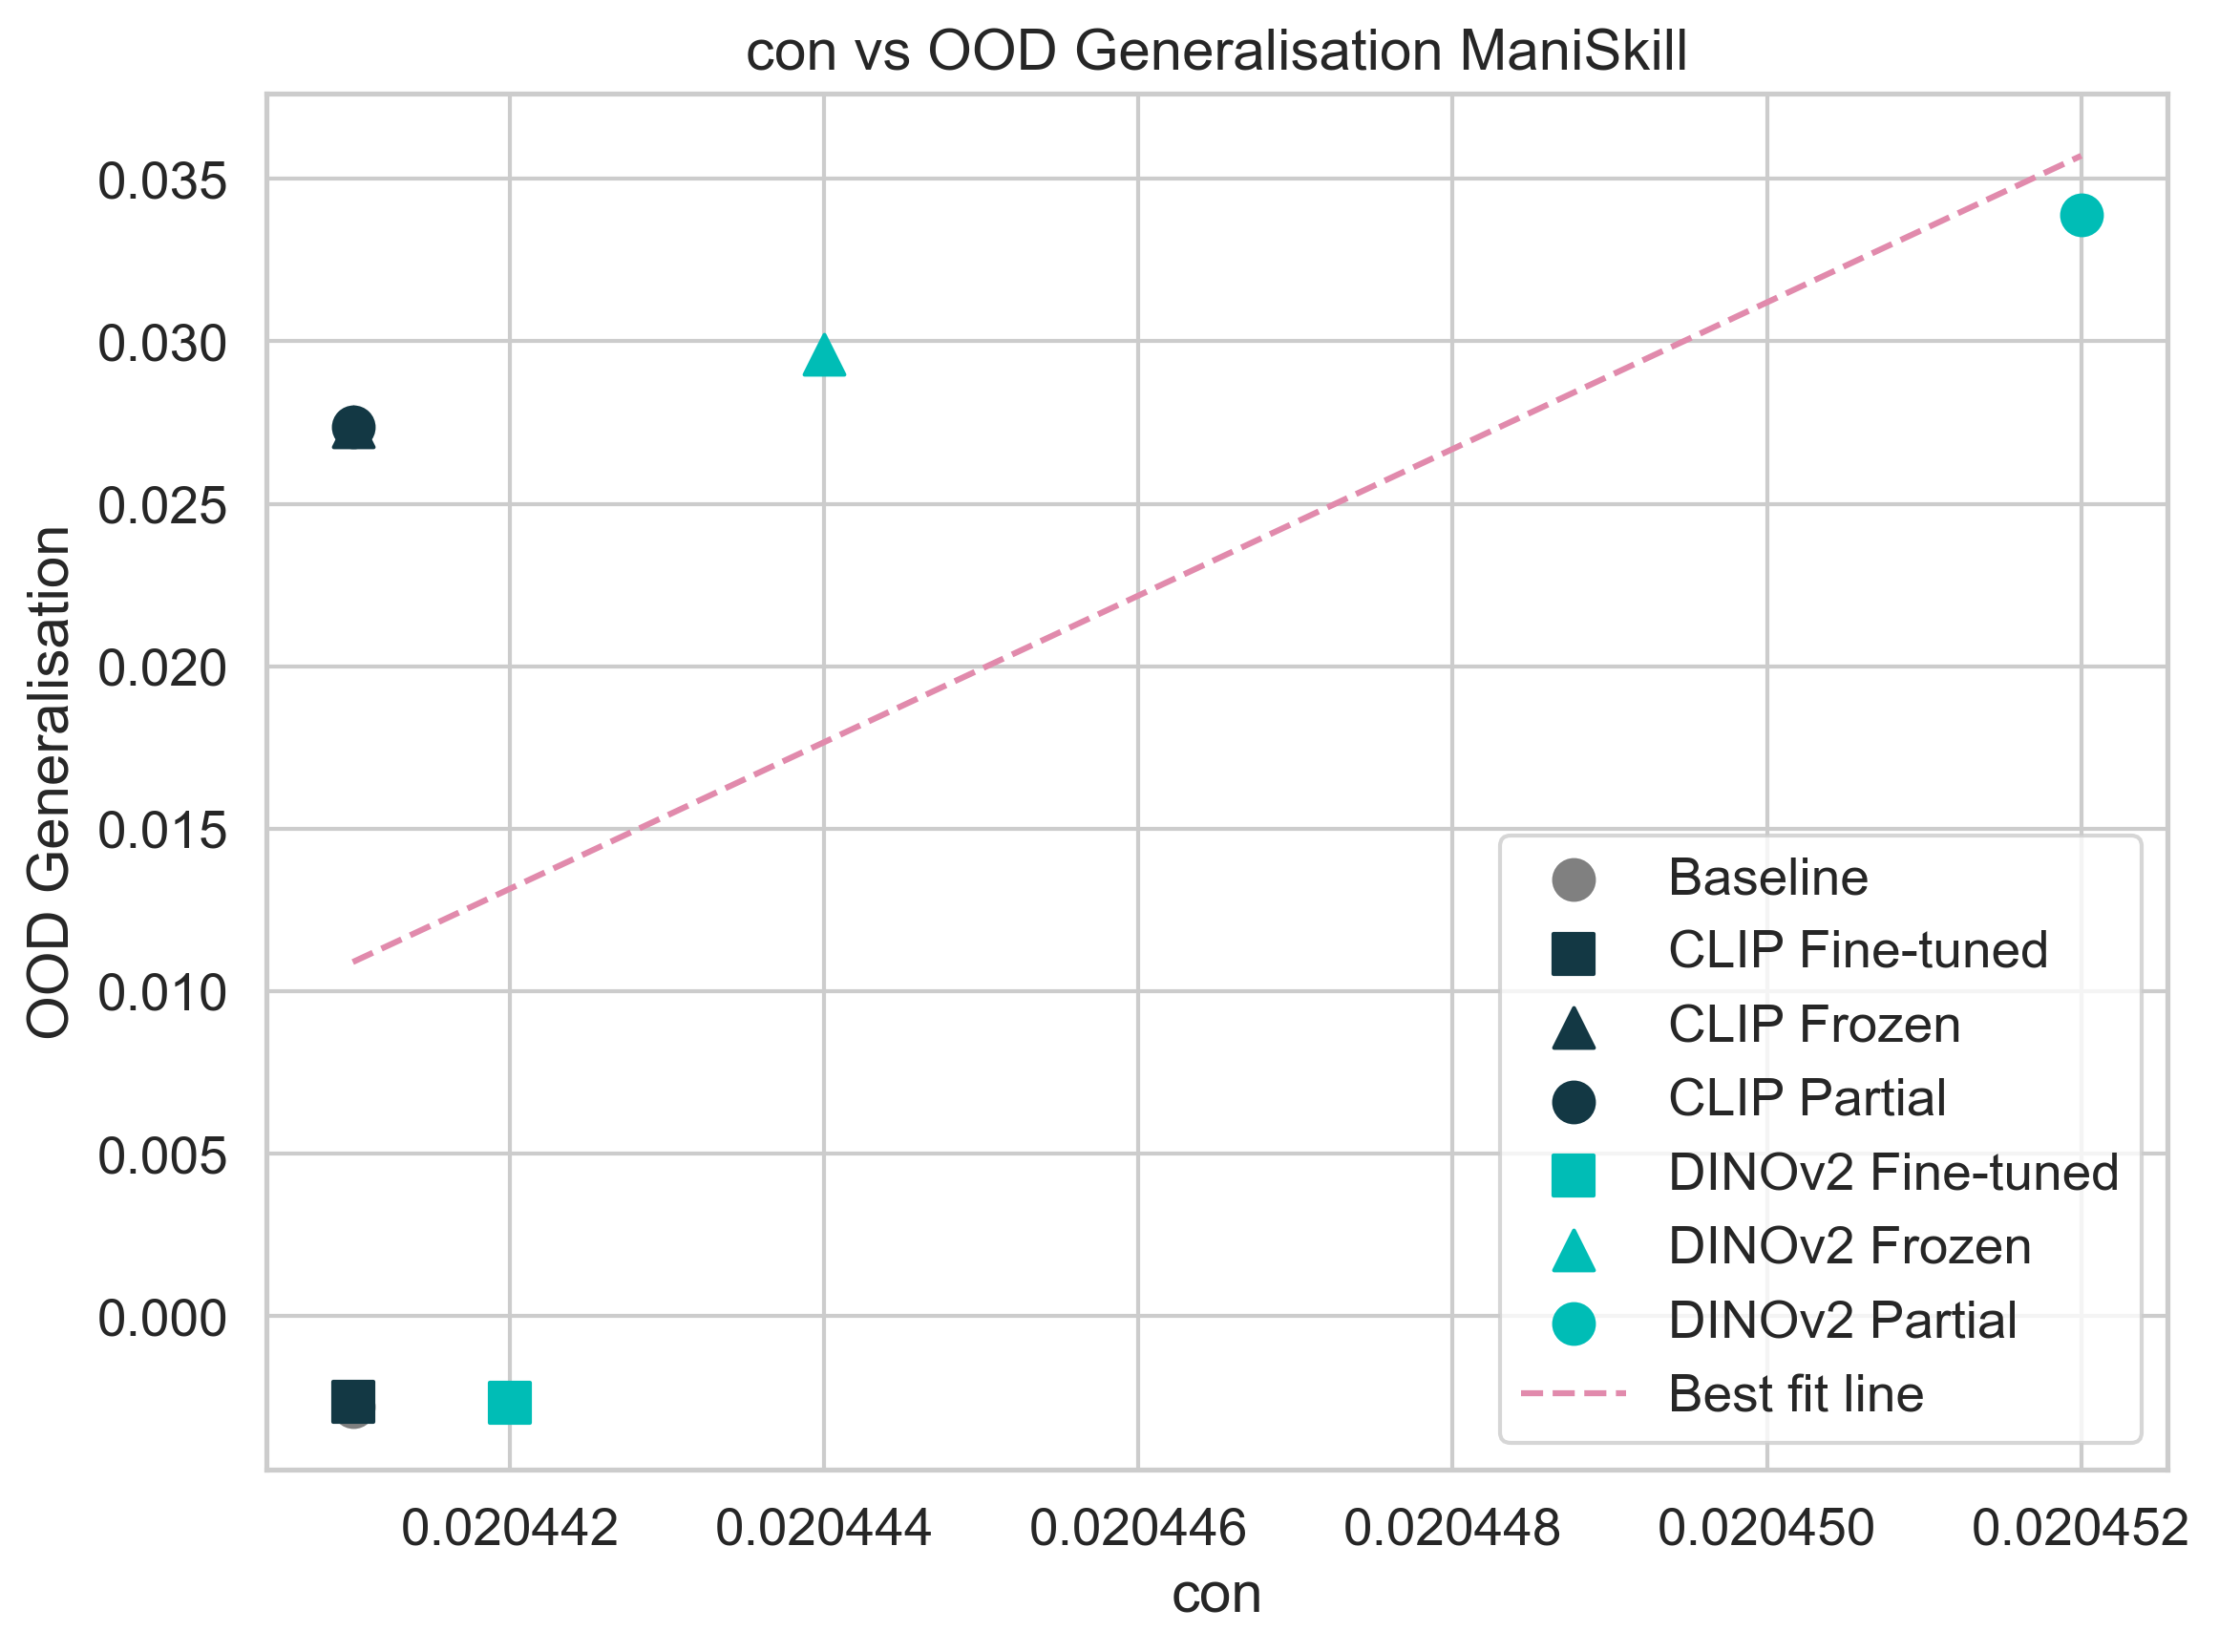

Pearson correlation: -0.52


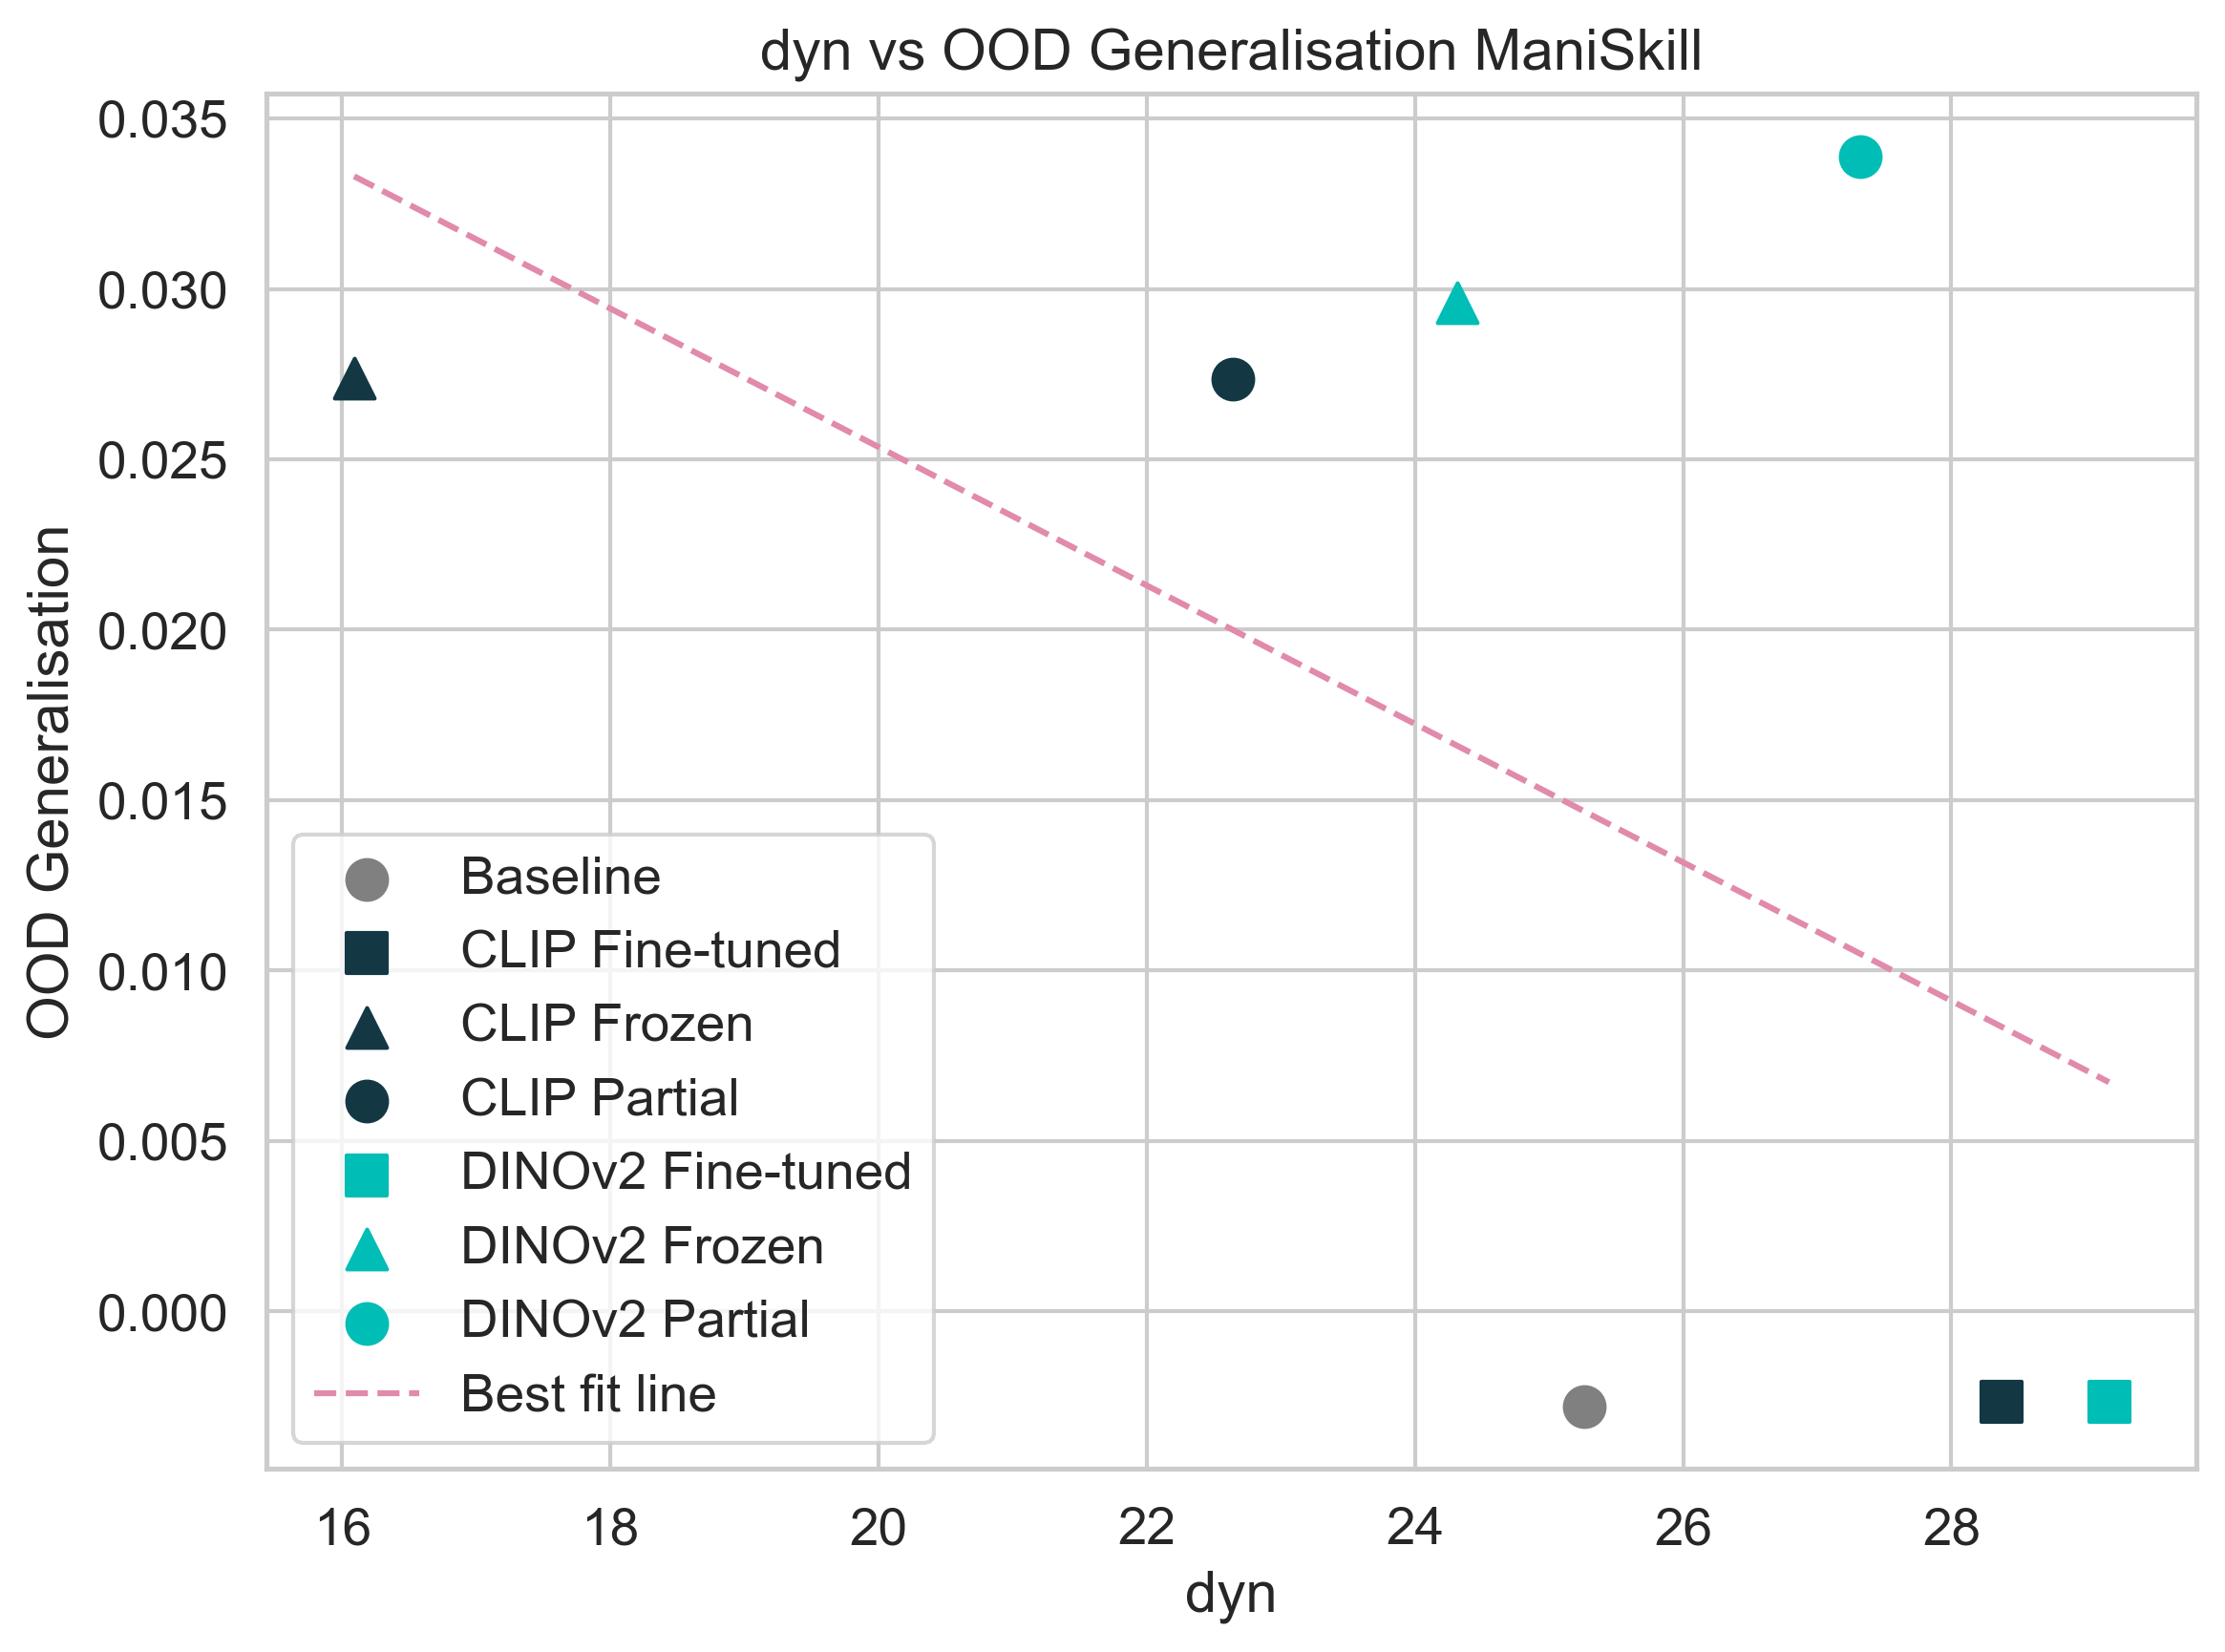

Pearson correlation: 0.67


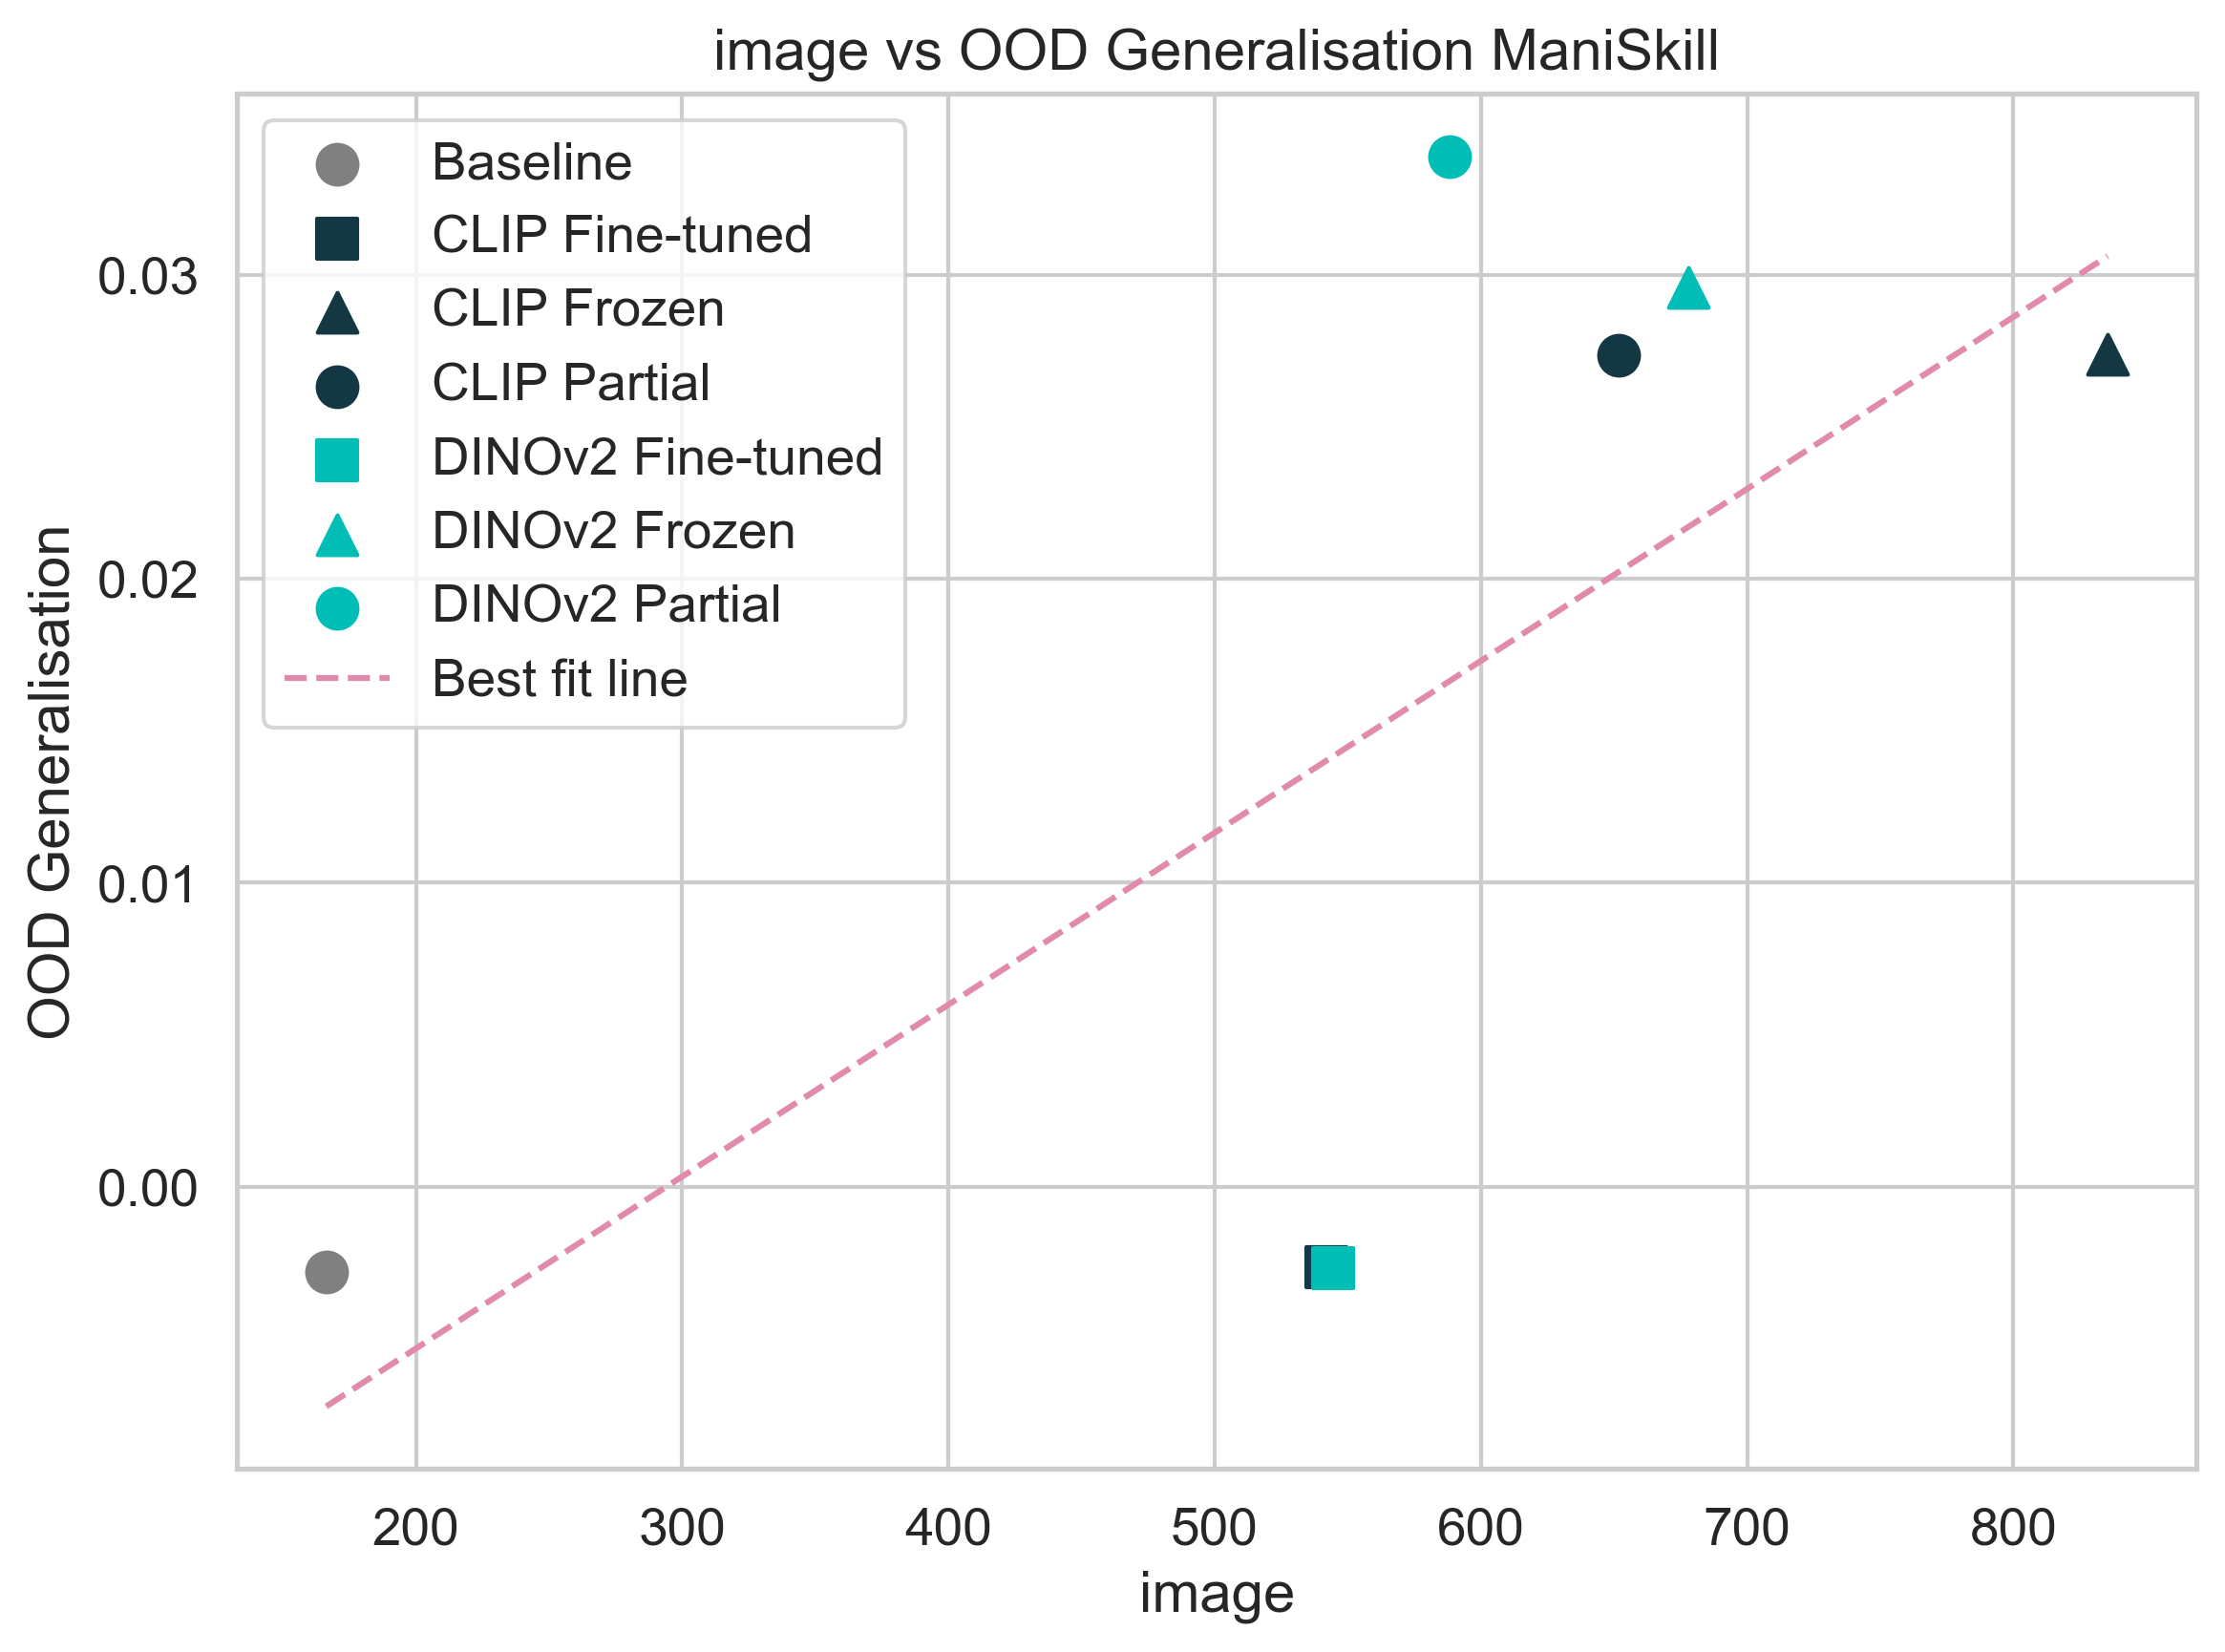

Pearson correlation: 0.44


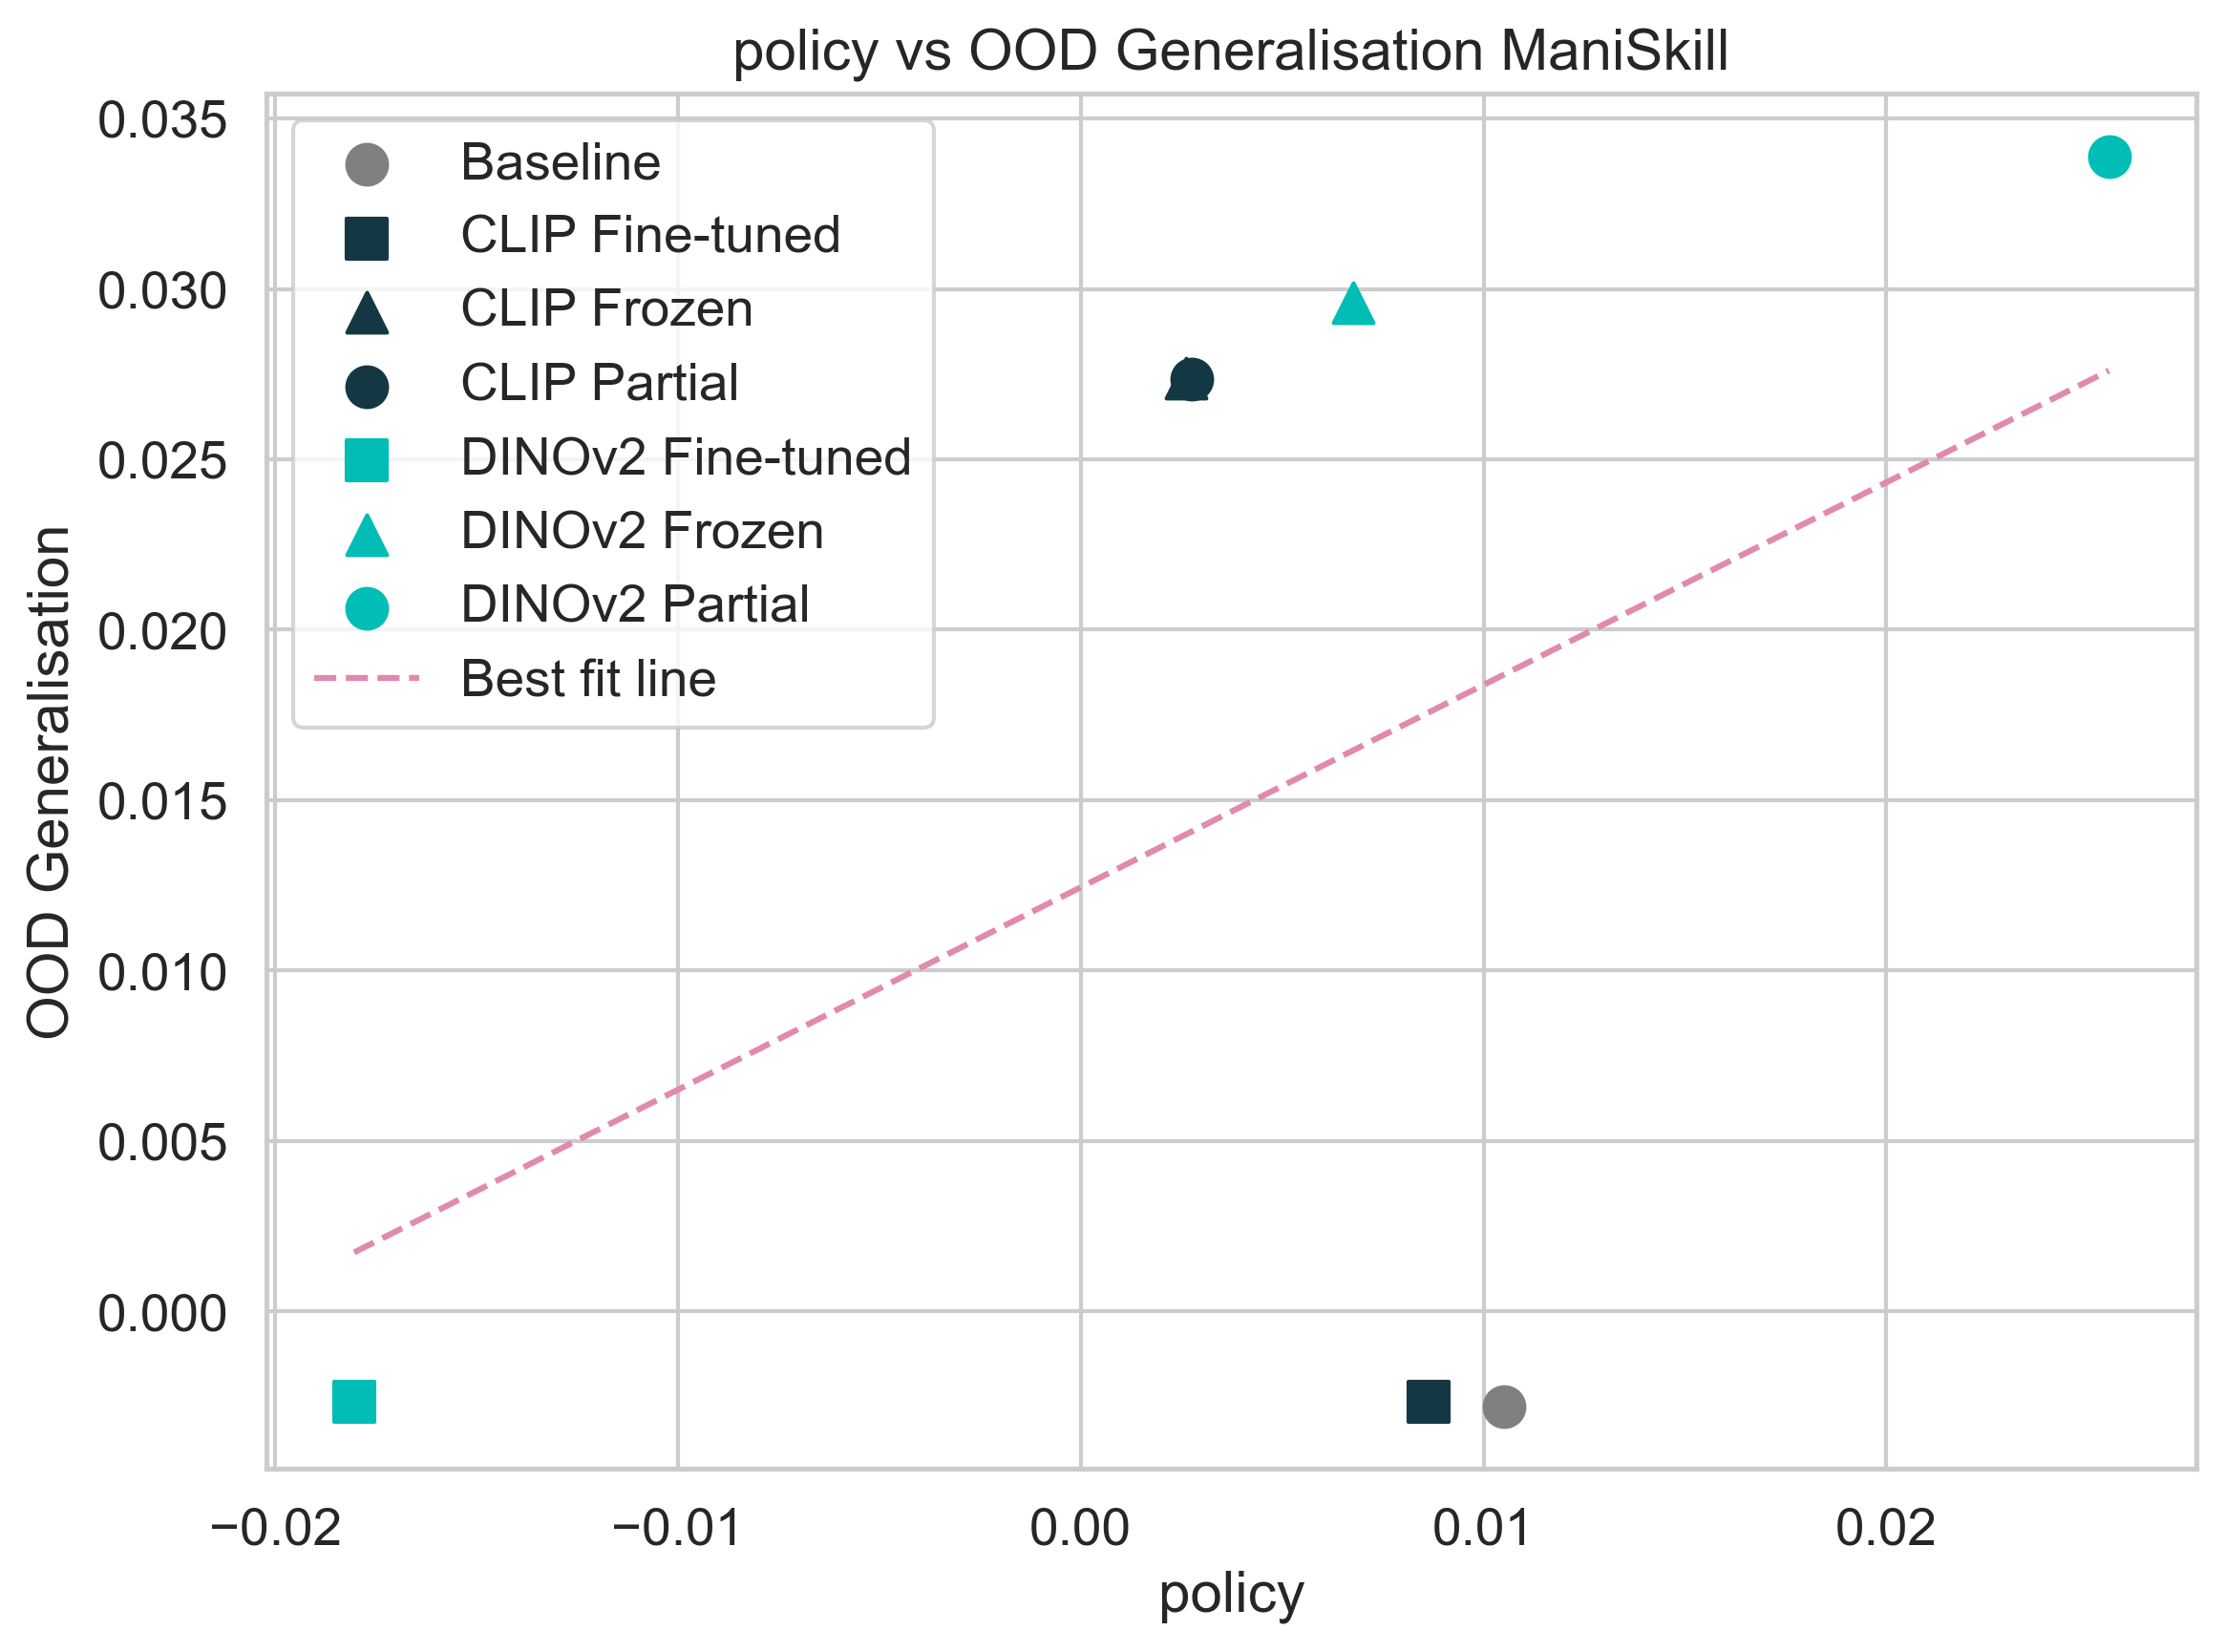

Pearson correlation: -0.52


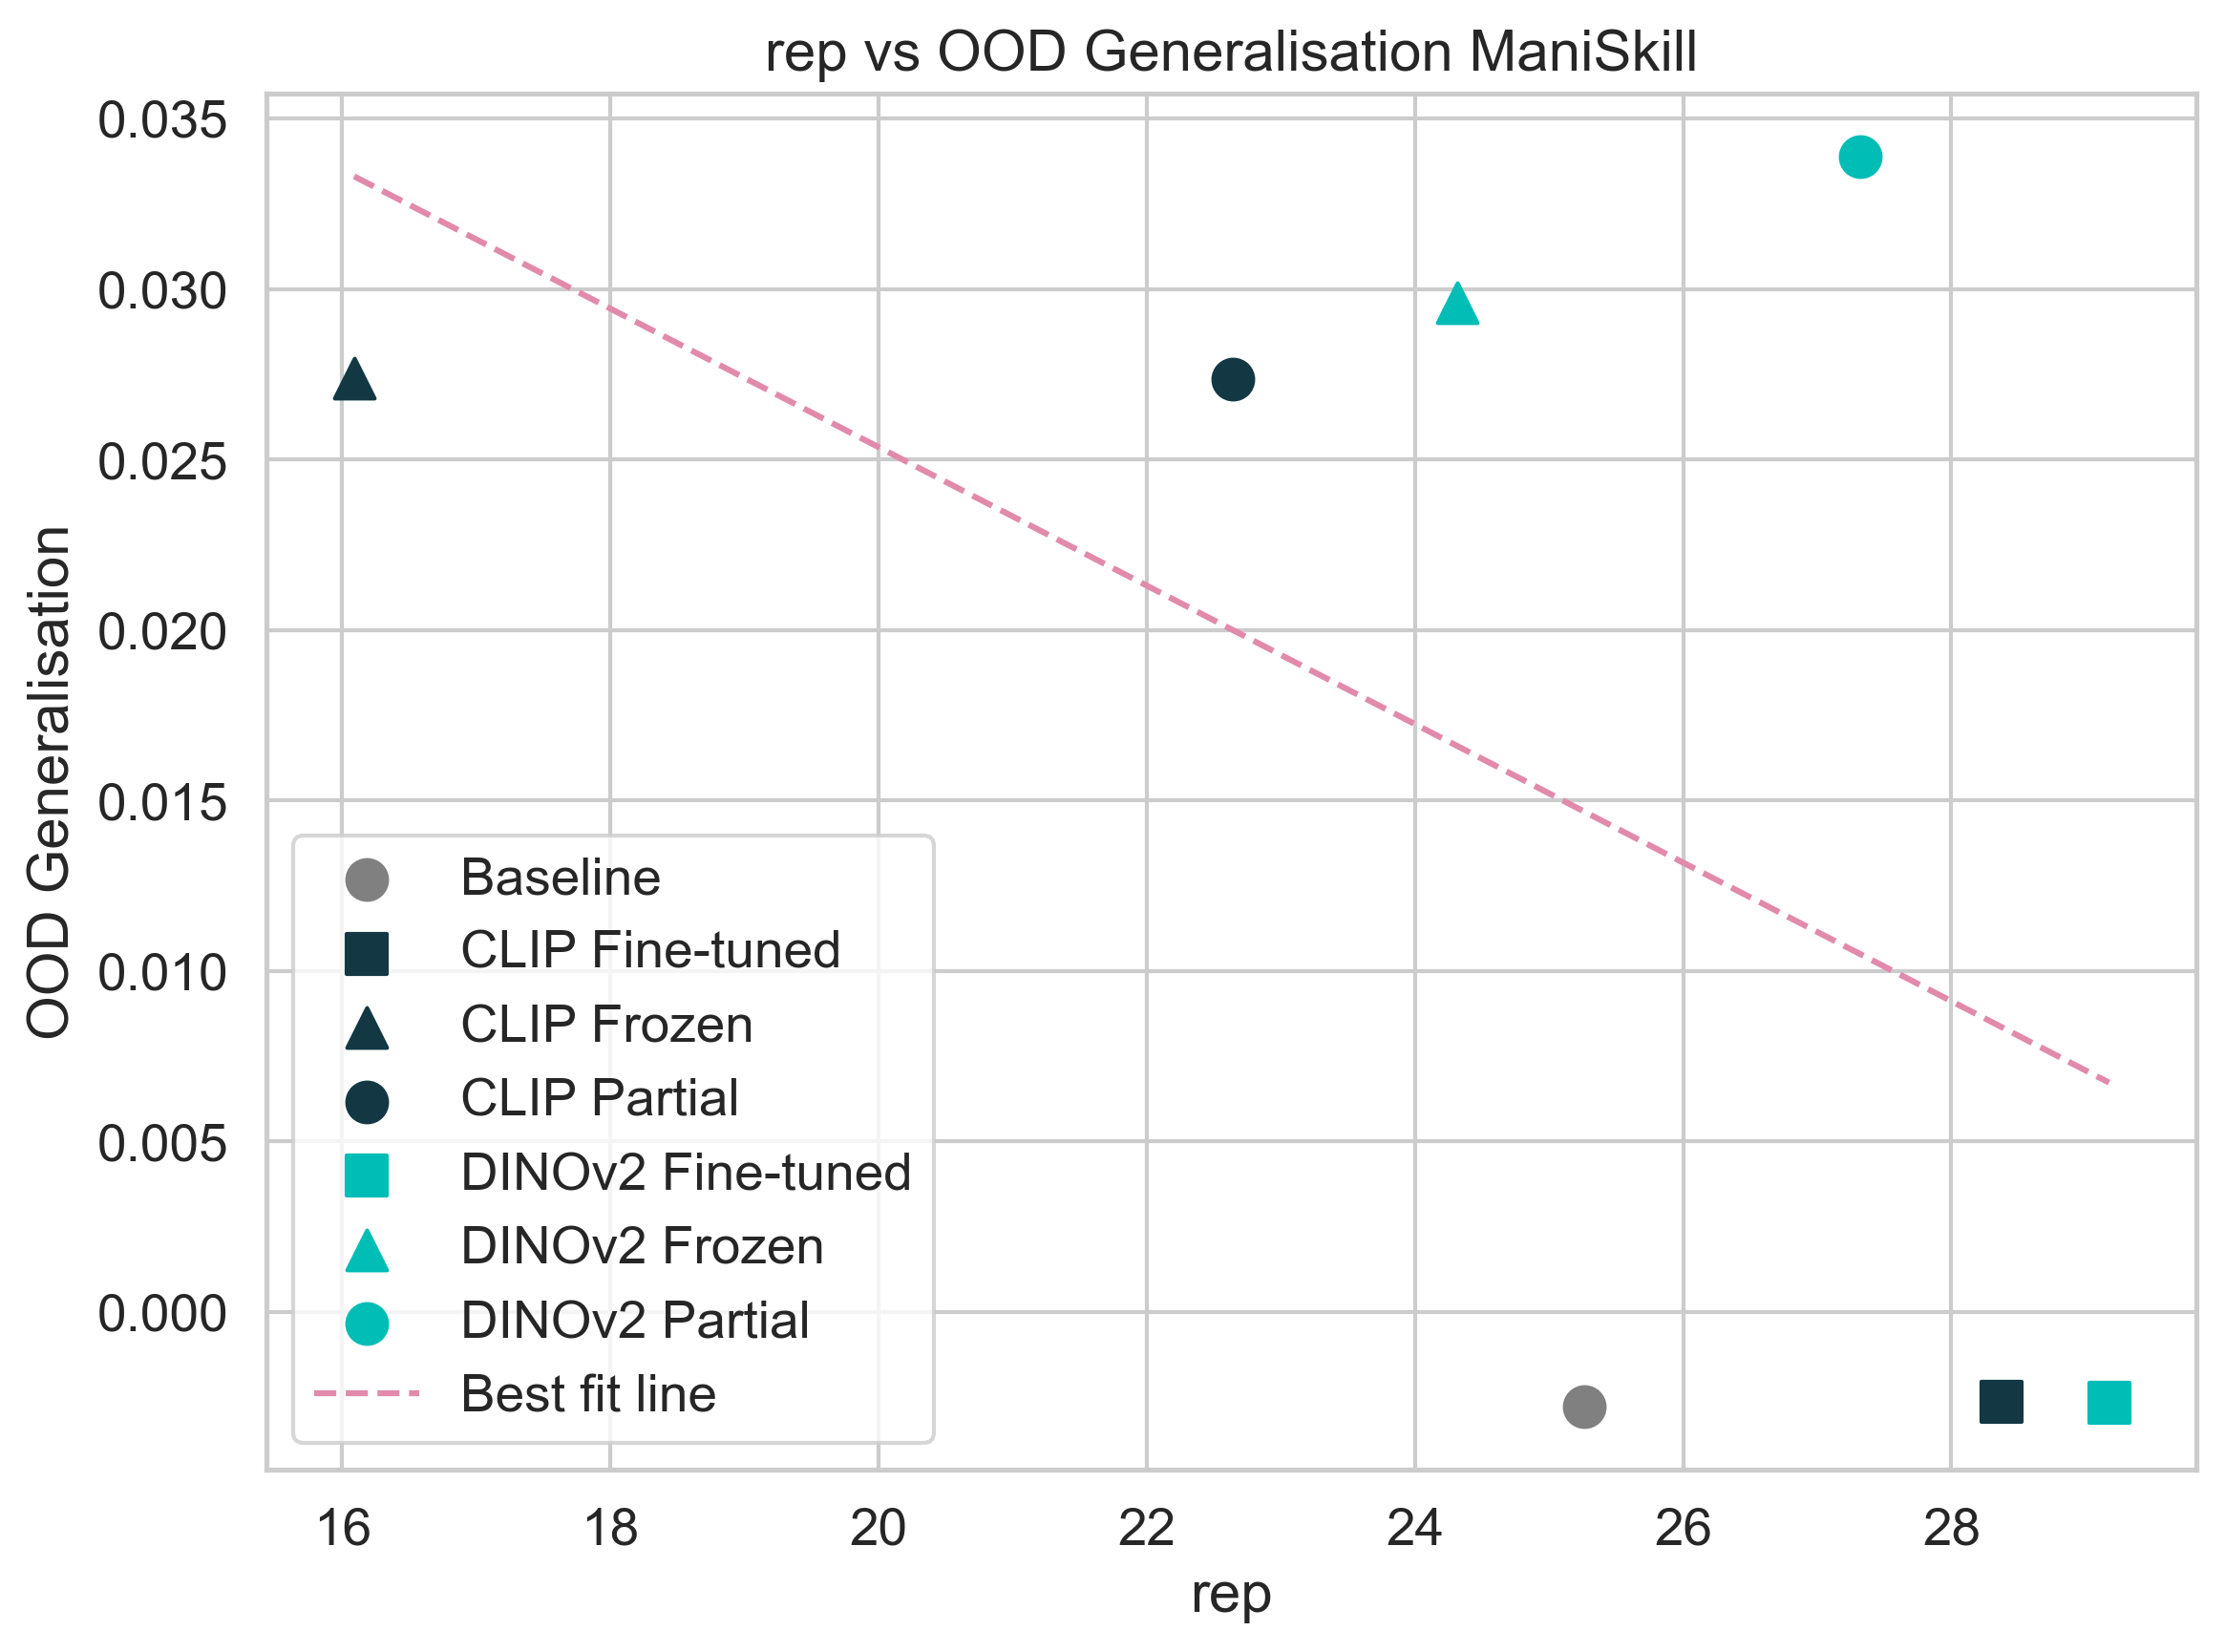

Pearson correlation: -0.05


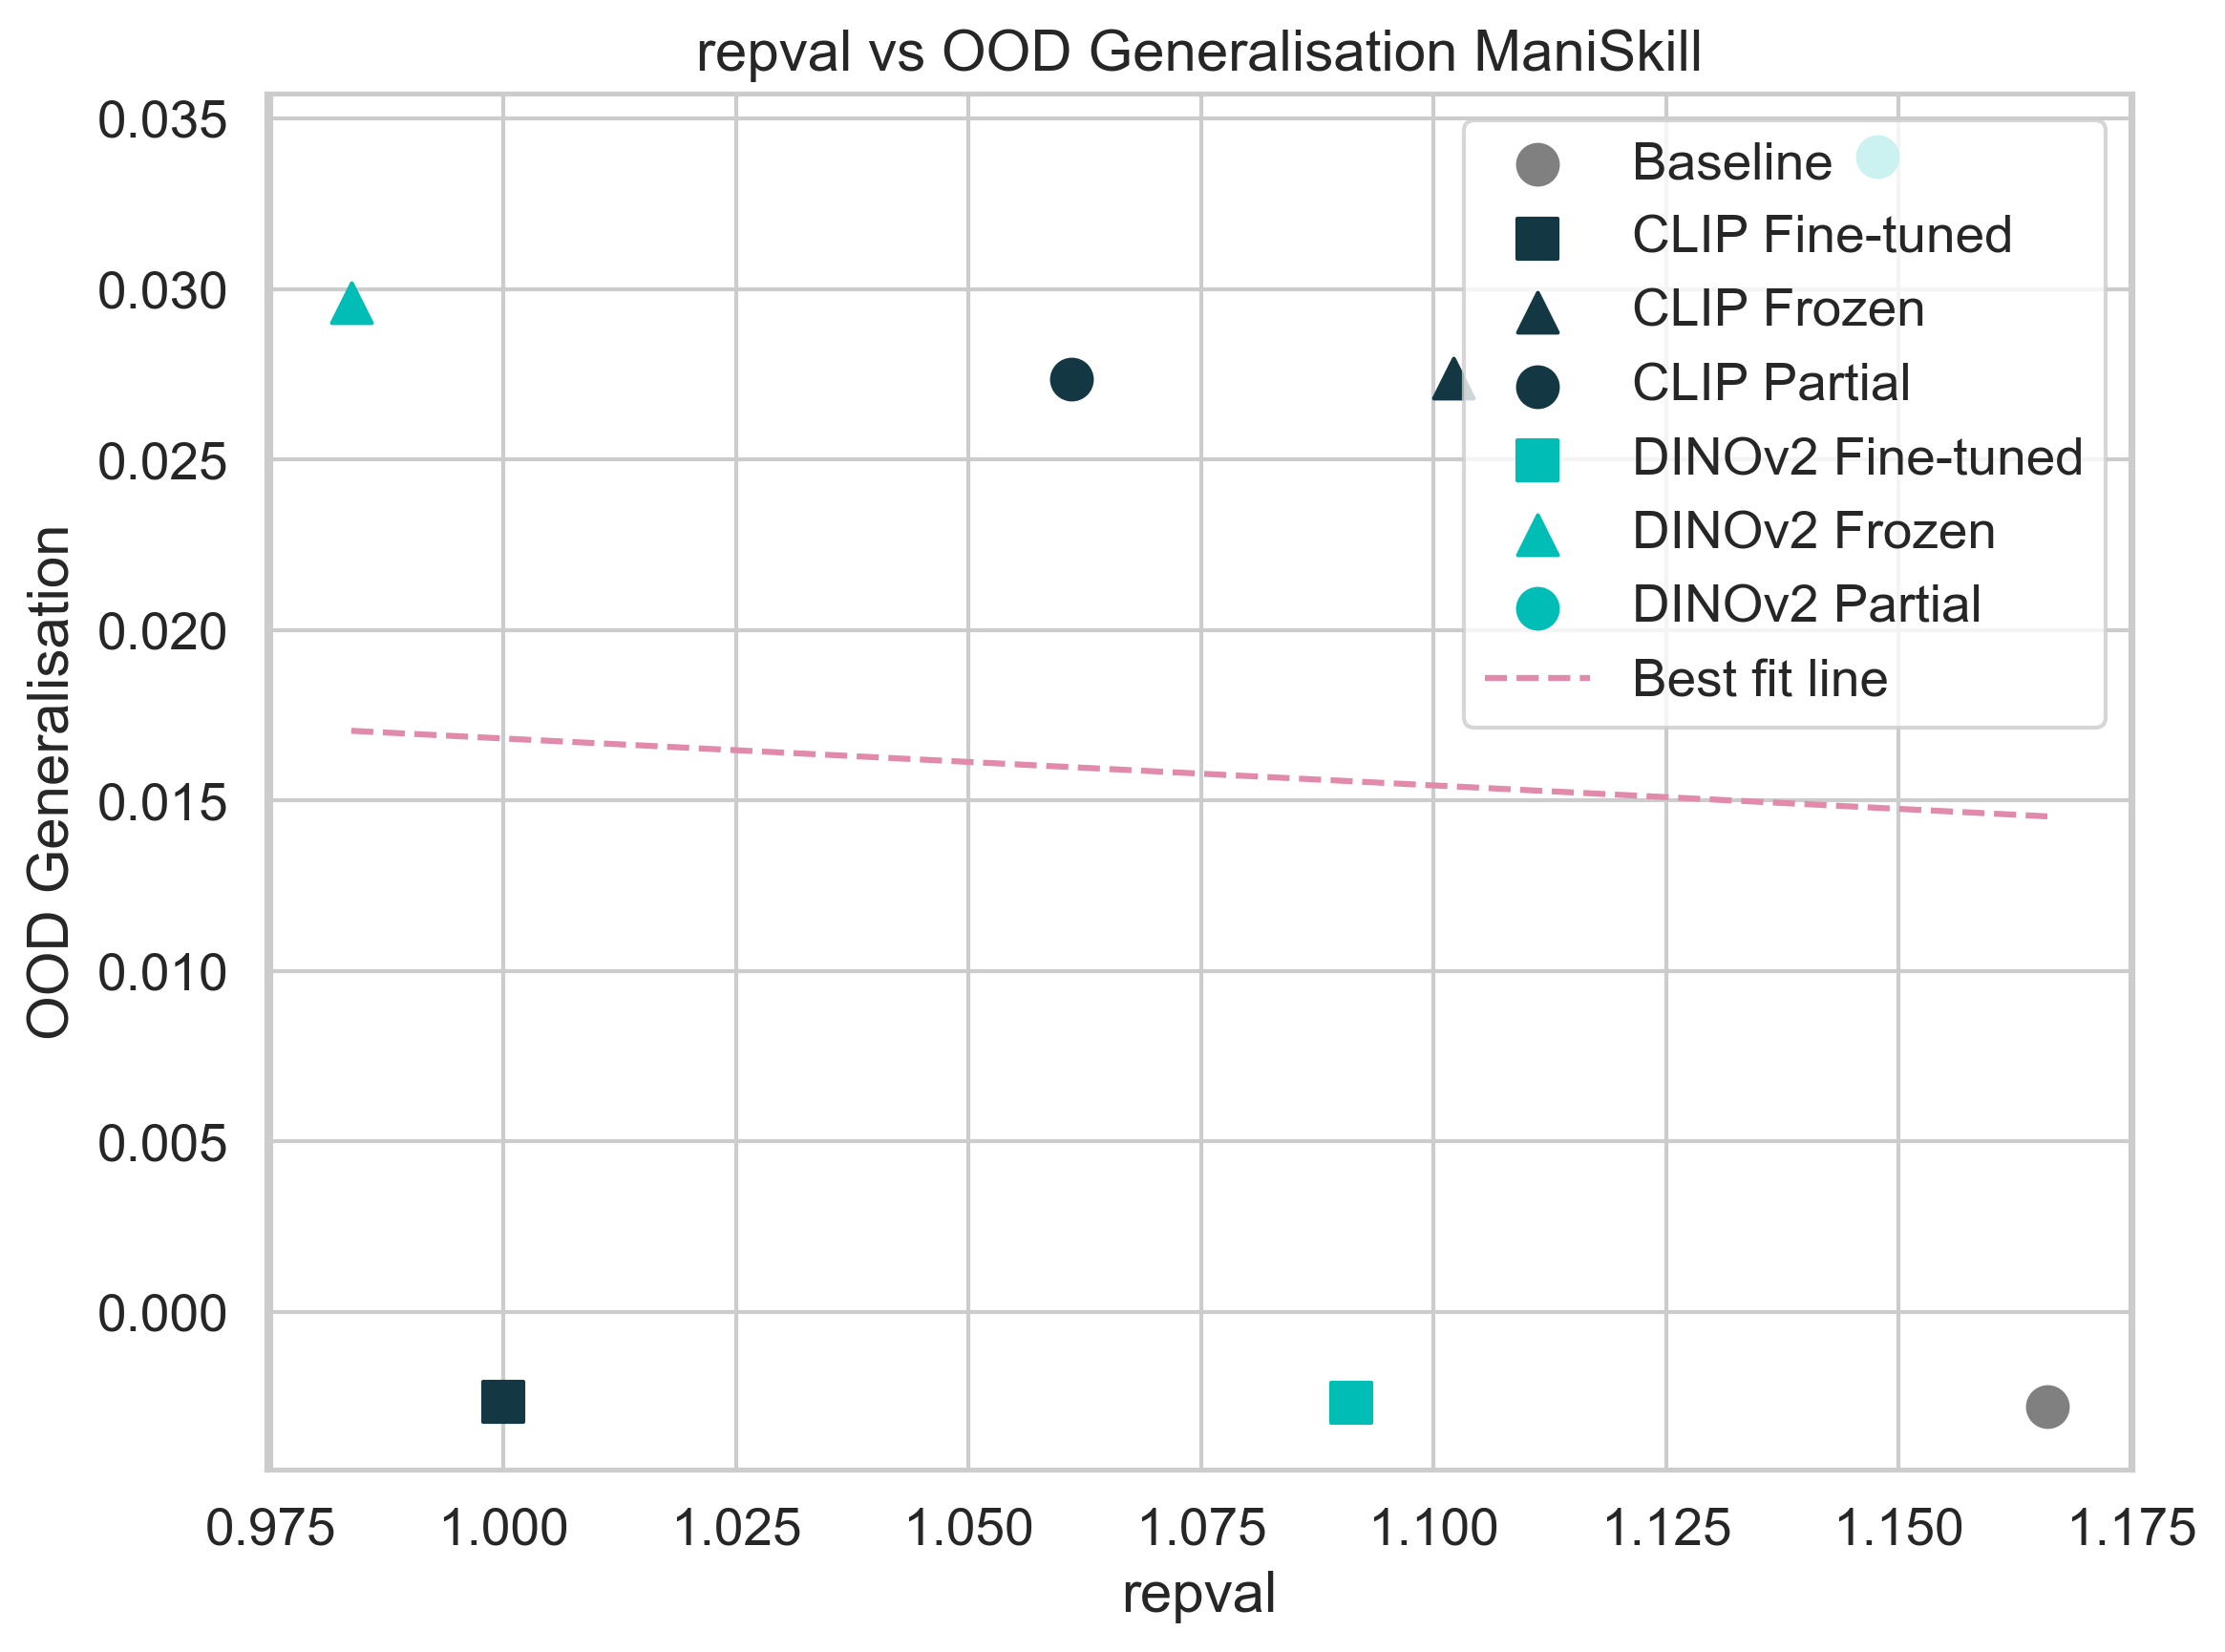

Pearson correlation: 0.09


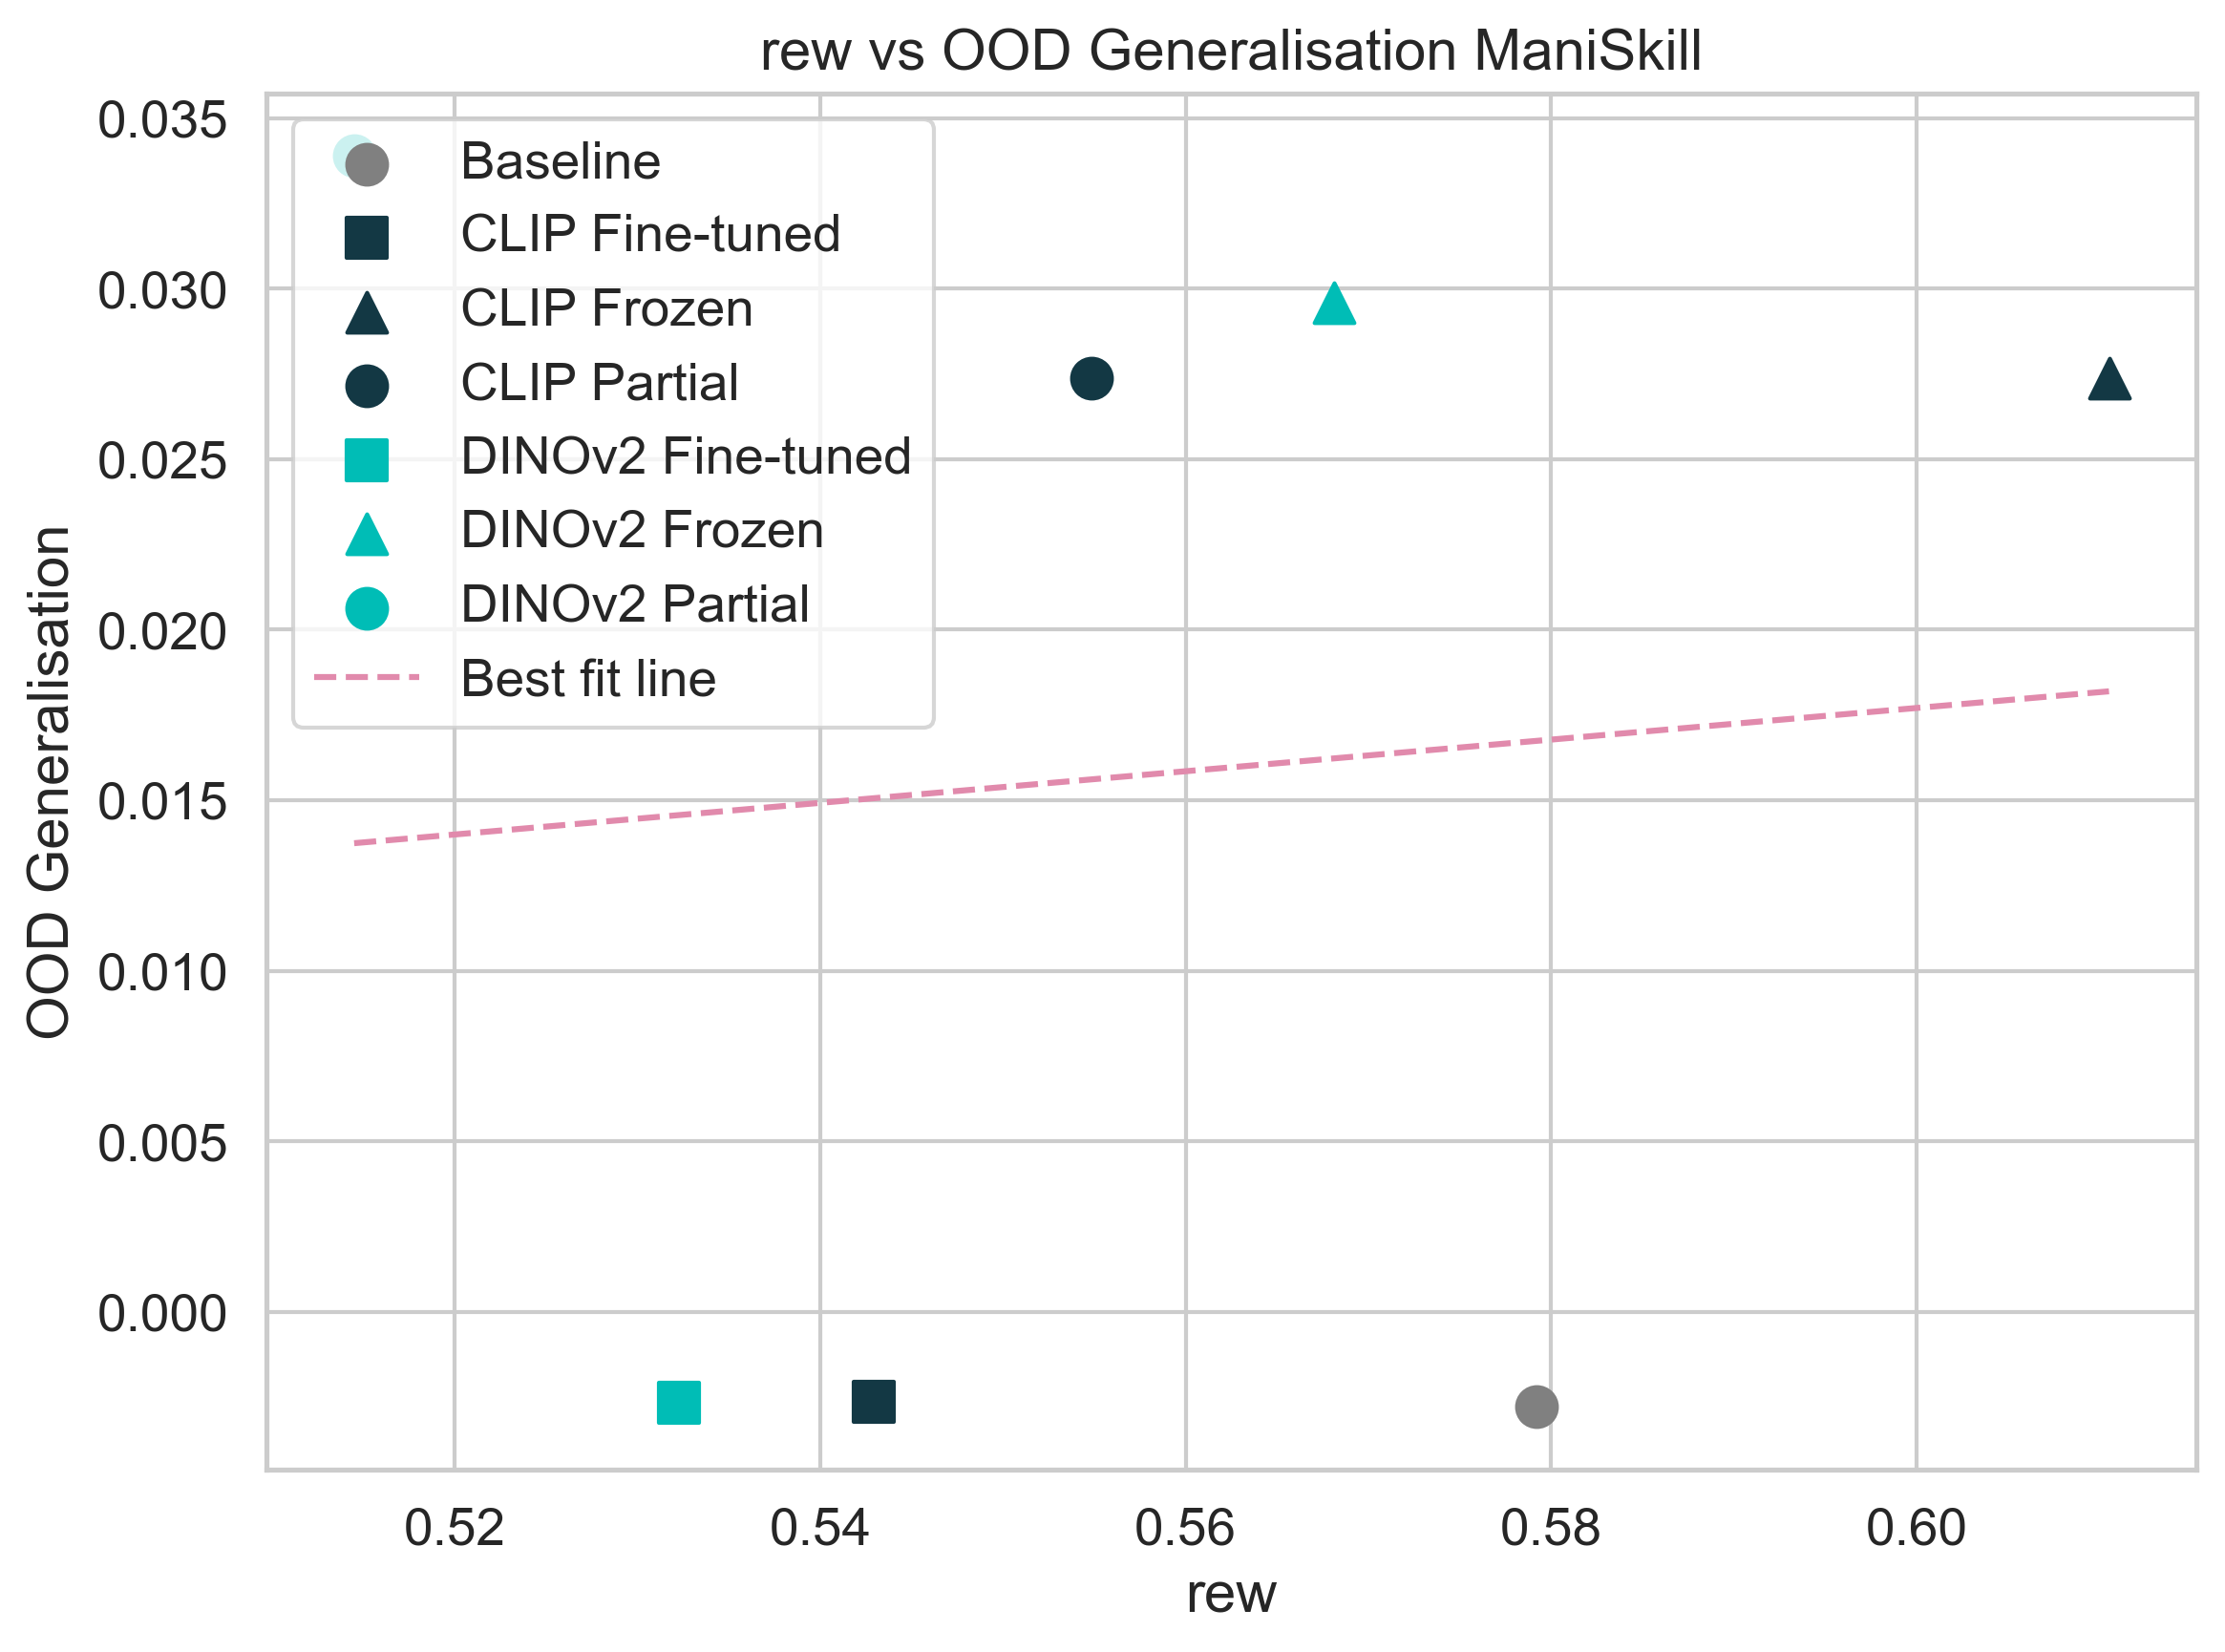

Pearson correlation: -0.39


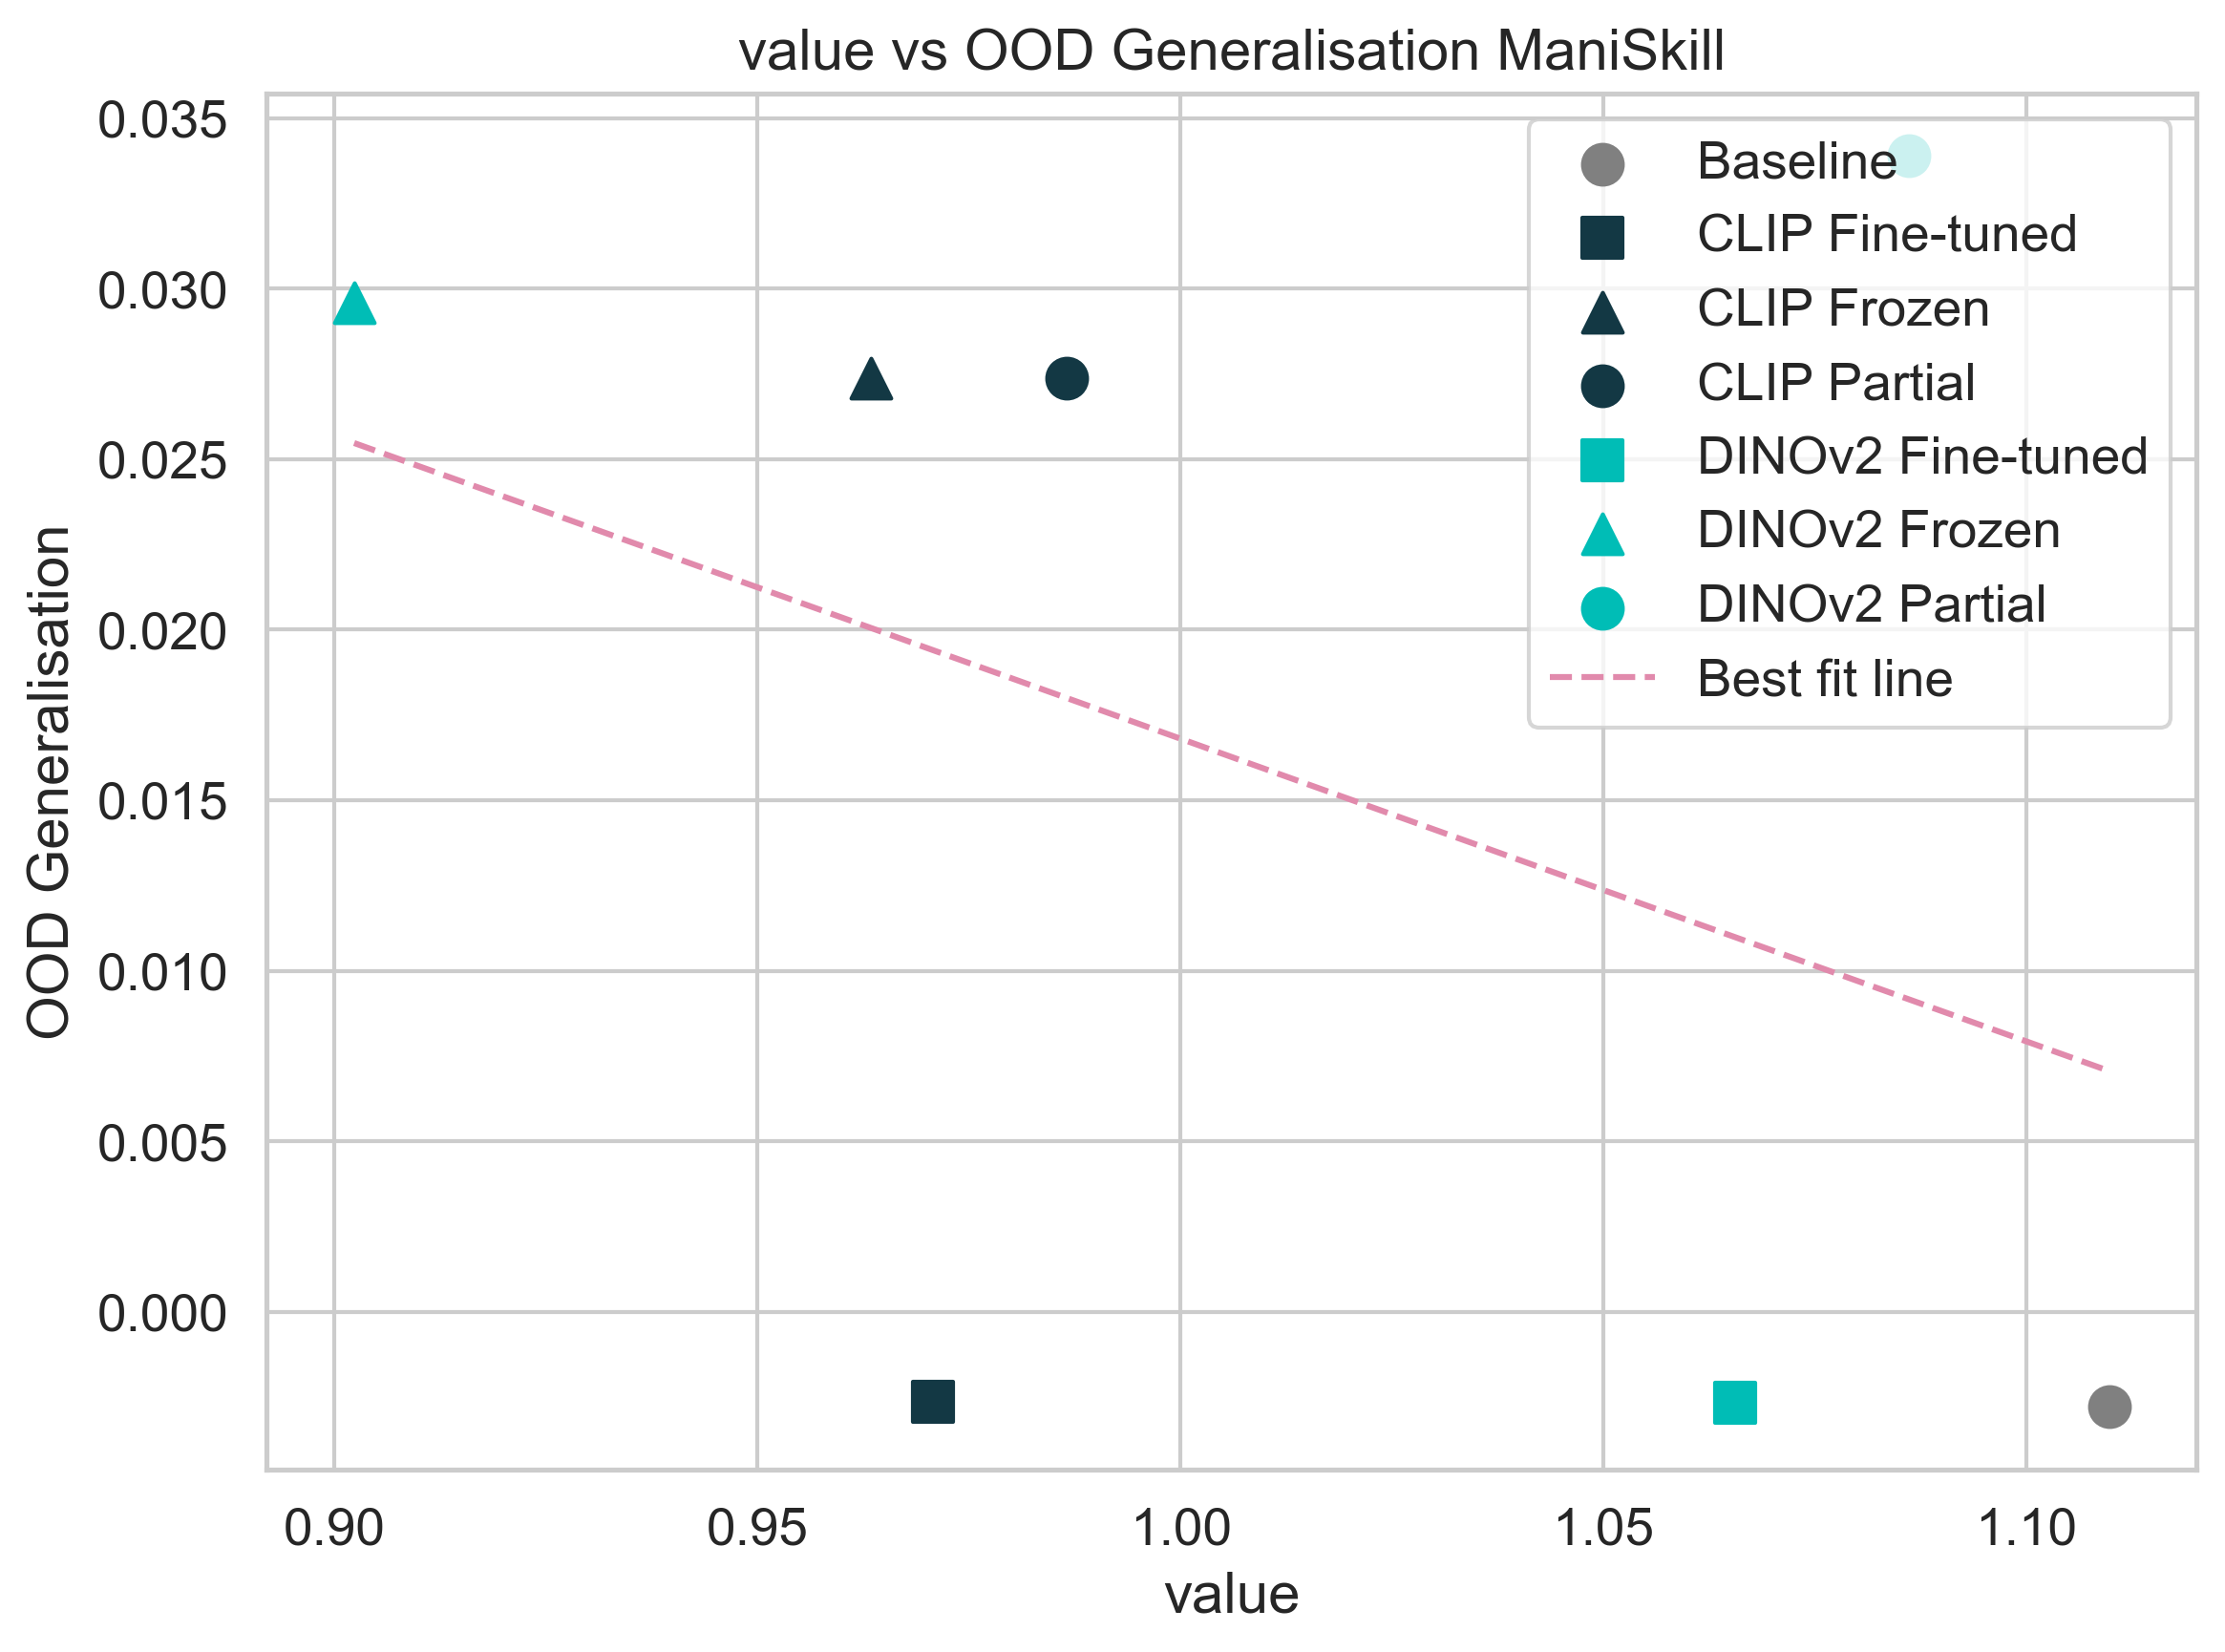

Pearson correlation: 1.00


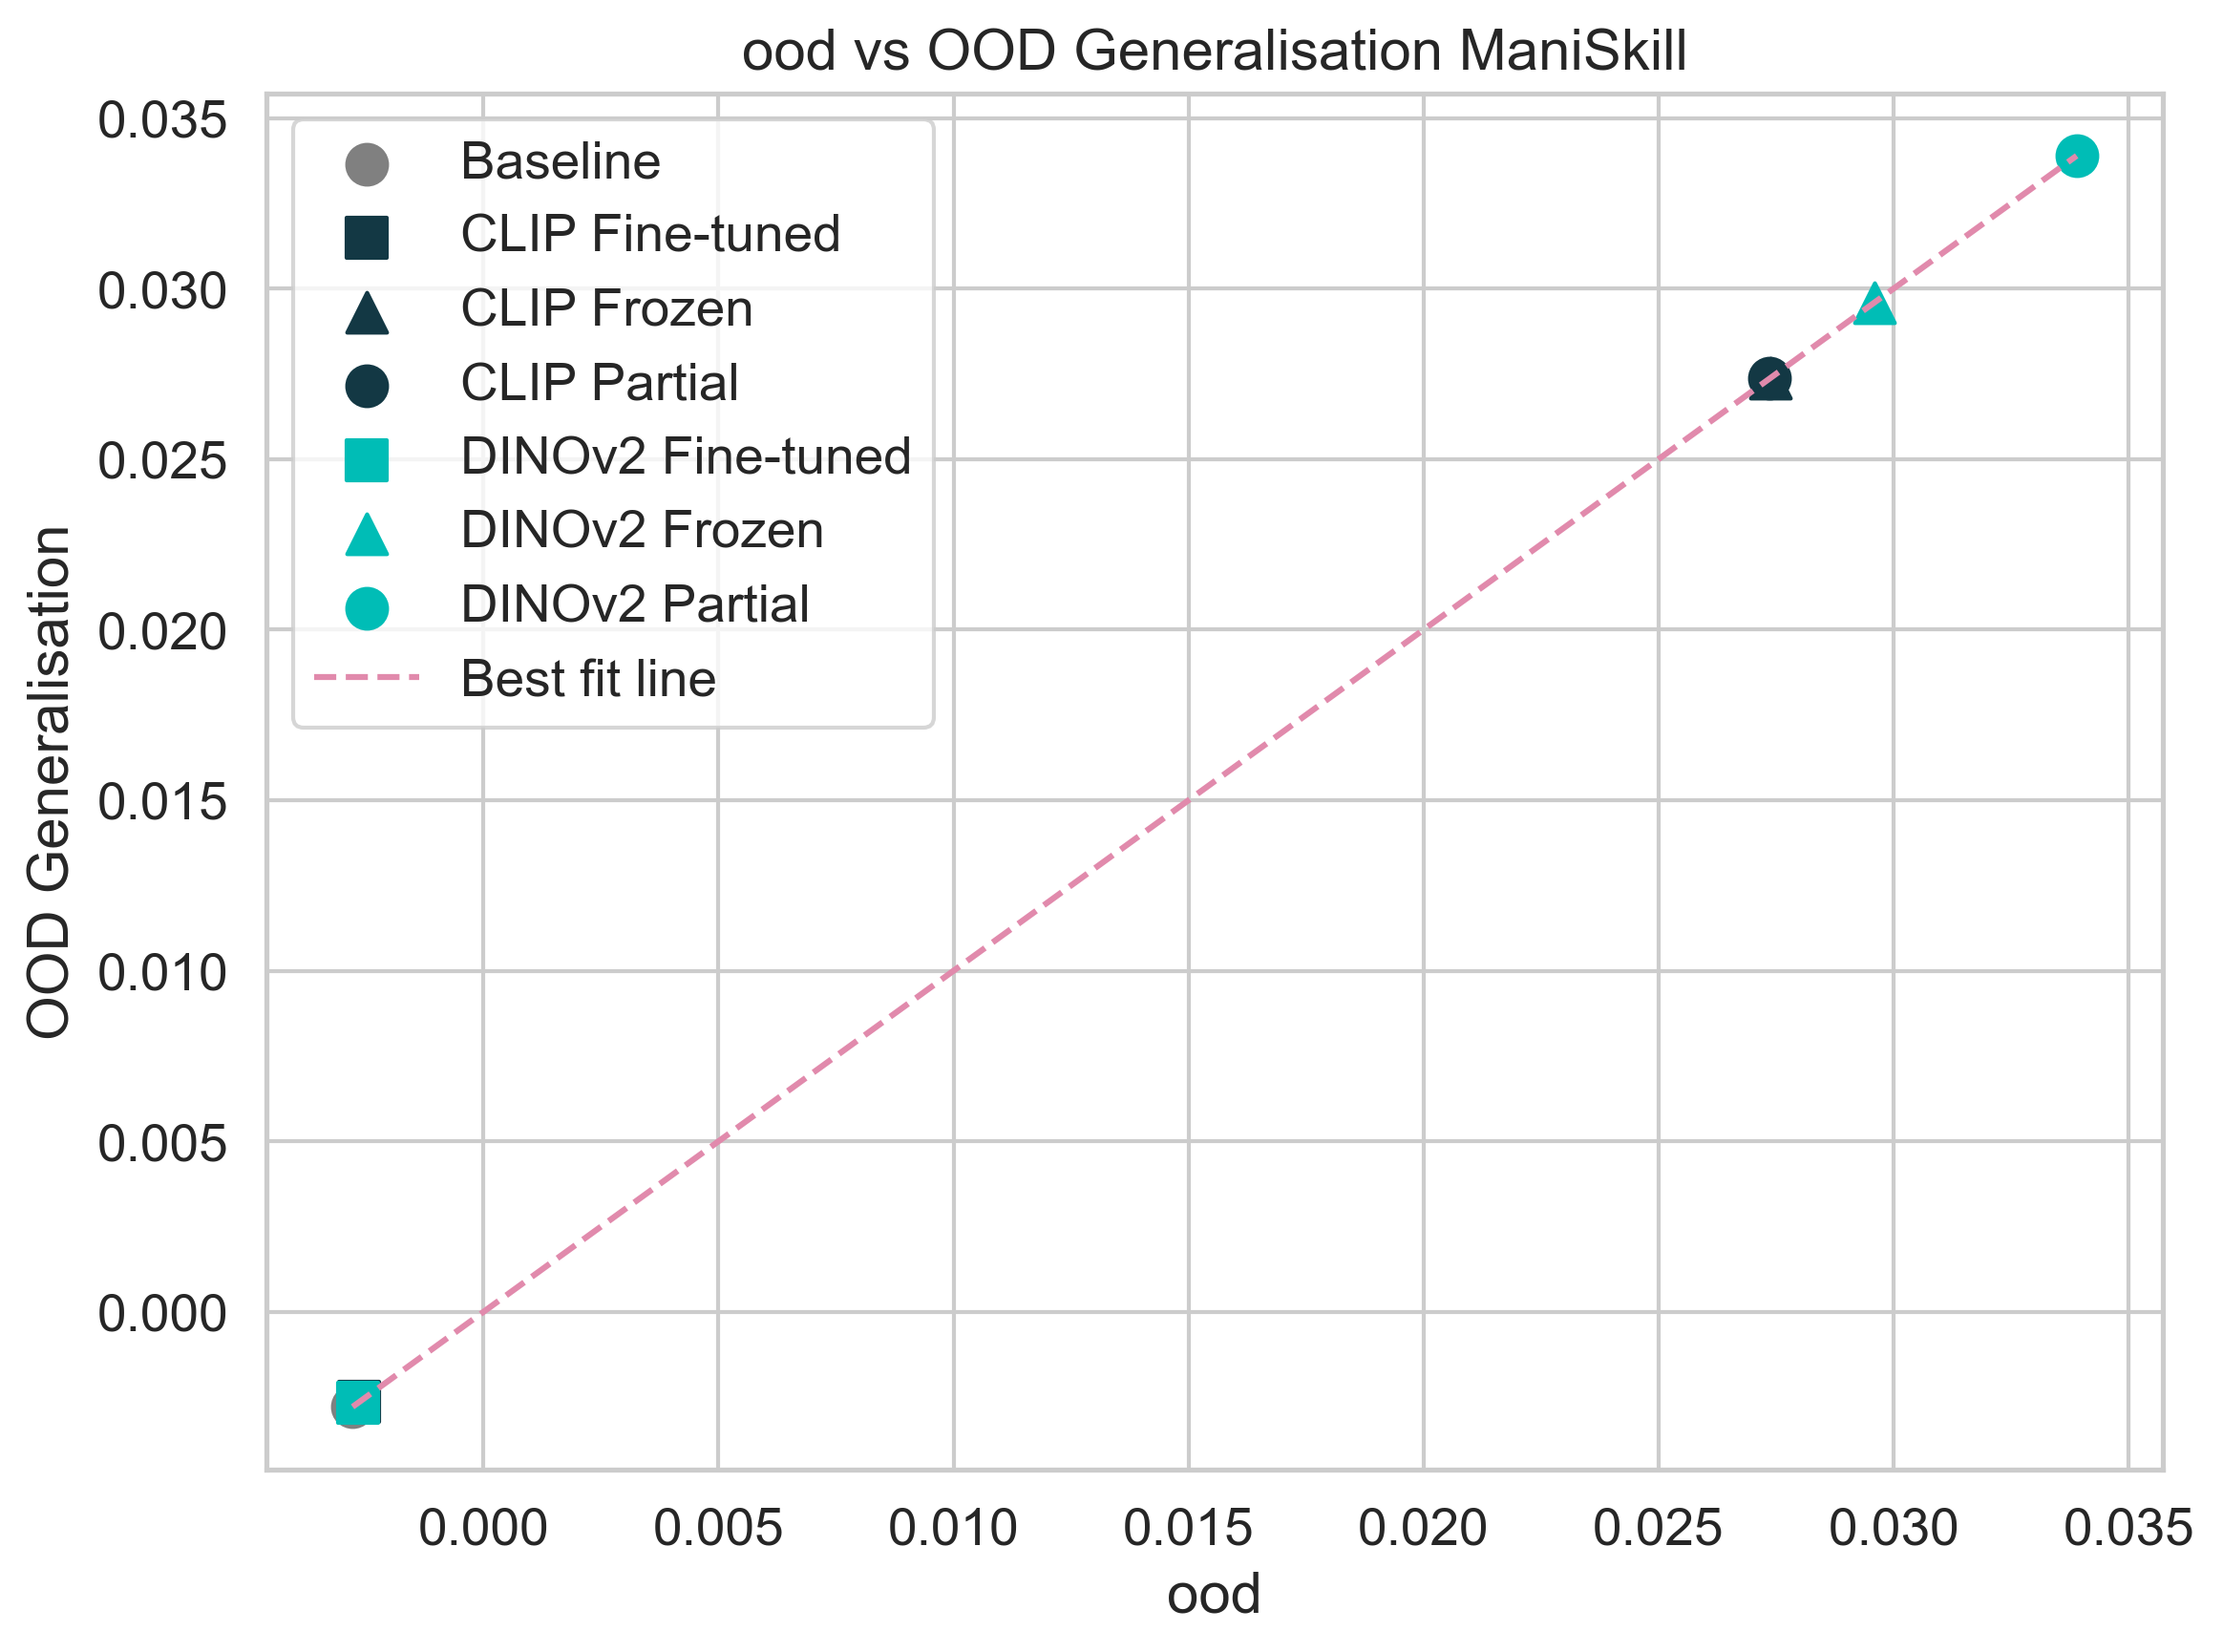

In [30]:
import csv
data = {
    'model': [
        'Baseline', 
        'DINOv2', 'DINOv2', 'DINOv2',
        'CLIP', 'CLIP', 'CLIP',
    ],
    'config': [
        '', 
        'Frozen', 'Partial', 'Fine-tuned',
        'Frozen', 'Partial', 'Fine-tuned',
    ],
}
correlation = {}
with open('logdir/losses/loss_summary.csv', 'r') as f:
    reader = csv.DictReader(f)
    for row in reader:
        for key in list(row.keys())[1:]:
            val = float(row[key])
            correlation[key] = [val] if key not in correlation else correlation[key] + [val]

df = pd.DataFrame(data)
print(correlation)

for key in correlation.keys():
    plot_correlation(
        correlation[key], 
        correlation['ood'], 
        df['model'], 
        df['config'],
        xlabel=key, 
        ylabel='OOD Generalisation',
        title=f'{key} vs OOD Generalisation ManiSkill'
    )
    plt.close()